In [1]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import pickle
import json
from scipy import stats
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           f1_score, precision_score, recall_score, roc_auc_score, 
                           roc_curve, auc, precision_recall_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.initializers import HeNormal, GlorotUniform
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model

# Check GPU
print("=" * 60)
print("SYSTEM INFORMATION")
print("=" * 60)
print(f"TensorFlow Version: {tf.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")

gpu_devices = tf.config.list_physical_devices('GPU')
if len(gpu_devices) > 0:
    print(f"✓ GPU Available: {len(gpu_devices)} device(s)")
    for device in gpu_devices:
        print(f"  - {device}")
else:
    print("✗ GPU Not Available - Using CPU")

print("\nAll libraries imported successfully!")
print("=" * 60)

2025-12-07 01:40:05.307143: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


SYSTEM INFORMATION
TensorFlow Version: 2.20.0
NumPy Version: 2.3.5
Pandas Version: 2.3.3
✗ GPU Not Available - Using CPU

All libraries imported successfully!


W0000 00:00:1765064408.099608   18029 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:

# Cell 2: Load Data
print("\n" + "=" * 60)
print("LOADING DATASETS")
print("=" * 60)

try:
    events_df = pd.read_csv('data/events.csv')
    category_df = pd.read_csv('data/category_tree.csv')
    item_prop1 = pd.read_csv('data/item_properties_part1.csv')
    item_prop2 = pd.read_csv('data/item_properties_part2.csv')
    
    print("✓ Datasets loaded successfully!")
    
except FileNotFoundError as e:
    print(f"✗ Error: {e}")
    print("Please ensure all data files are in the 'data/' directory:")
    print("1. events.csv")
    print("2. category_tree.csv") 
    print("3. item_properties_part1.csv")
    print("4. item_properties_part2.csv")
    raise

print("\nDataset shapes:")
print(f"Events: {events_df.shape}")
print(f"Category: {category_df.shape}")
print(f"Item Properties 1: {item_prop1.shape}")
print(f"Item Properties 2: {item_prop2.shape}")

# Display first few rows
print("\nFirst 3 rows of events dataset:")
print(events_df.head(3))
print("\n" + "=" * 60)


LOADING DATASETS
✓ Datasets loaded successfully!

Dataset shapes:
Events: (2756101, 5)
Category: (1669, 2)
Item Properties 1: (10999999, 4)
Item Properties 2: (9275903, 4)

First 3 rows of events dataset:
       timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN



In [3]:
# Cell 3: Comprehensive Data Preprocessing
print("\n" + "=" * 60)
print("COMPREHENSIVE DATA PREPROCESSING")
print("=" * 60)

# 1. Initial Data Inspection
print("\n1. INITIAL DATA INSPECTION:")
print("-" * 40)

print("Data Types:")
print(events_df.dtypes)
print(f"\nColumns: {list(events_df.columns)}")

# 2. Convert timestamp
print("\n2. TIMESTAMP CONVERSION:")
events_df['datetime'] = pd.to_datetime(events_df['timestamp'], unit='ms')
events_df['date'] = events_df['datetime'].dt.date
events_df['hour'] = events_df['datetime'].dt.hour
events_df['weekday'] = events_df['datetime'].dt.dayofweek
events_df['weekday_name'] = events_df['datetime'].dt.day_name()
events_df['month'] = events_df['datetime'].dt.month
events_df['day'] = events_df['datetime'].dt.day

print(f"Time range: {events_df['datetime'].min()} to {events_df['datetime'].max()}")
print(f"Total days: {(events_df['datetime'].max() - events_df['datetime'].min()).days} days")

# 3. Handle Missing Values
print("\n3. MISSING VALUE ANALYSIS:")
print("-" * 40)

missing_data = events_df.isnull().sum()
missing_percentage = (missing_data / len(events_df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage': missing_percentage
})
print(missing_df[missing_df['Missing Values'] > 0])

# Check specific columns for NaN
if 'transactionid' in events_df.columns:
    nan_transactions = events_df['transactionid'].isna().sum()
    print(f"\nNaN in transactionid: {nan_transactions} ({nan_transactions/len(events_df)*100:.2f}%)")
    
    # For view events, transactionid should be NaN
    view_events = events_df[events_df['event'] == 'view']
    view_with_trans = view_events['transactionid'].notna().sum()
    print(f"View events with transactionid: {view_with_trans} (should be 0)")

# 4. Remove Duplicates
print("\n4. DUPLICATE ANALYSIS:")
print("-" * 40)

initial_count = len(events_df)
duplicate_count = events_df.duplicated().sum()
events_df = events_df.drop_duplicates()
final_count = len(events_df)

print(f"Initial records: {initial_count:,}")
print(f"Duplicate records: {duplicate_count:,} ({duplicate_count/initial_count*100:.2f}%)")
print(f"Records after deduplication: {final_count:,}")
print(f"Removed: {initial_count - final_count:,} records")

# 5. Data Type Conversion
print("\n5. DATA TYPE CONVERSION:")
print("-" * 40)

# Convert IDs to string for consistency
events_df['visitorid'] = events_df['visitorid'].astype(str)
events_df['itemid'] = events_df['itemid'].astype(str)

if 'transactionid' in events_df.columns:
    # Convert transactionid to string, keep NaN for view events
    events_df['transactionid'] = events_df['transactionid'].apply(
        lambda x: str(int(x)) if pd.notna(x) else np.nan
    )

print("✓ visitorid and itemid converted to string")
print(f"✓ Unique visitors: {events_df['visitorid'].nunique():,}")
print(f"✓ Unique items: {events_df['itemid'].nunique():,}")

# 6. Outlier Detection
print("\n6. OUTLIER DETECTION:")
print("-" * 40)

# Check for unrealistic timestamps (future dates or too old)
current_date = datetime.now()
max_date = events_df['datetime'].max()
min_date = events_df['datetime'].min()

print(f"Earliest date: {min_date}")
print(f"Latest date: {max_date}")
print(f"Days from now: {(current_date - max_date).days} days ago")

# Check for events with timestamps too far in future (shouldn't happen)
future_events = events_df[events_df['datetime'] > current_date]
print(f"Events with future timestamps: {len(future_events)}")

if len(future_events) > 0:
    events_df = events_df[events_df['datetime'] <= current_date]
    print(f"Removed {len(future_events)} future events")

# 7. Event Validation
print("\n7. EVENT VALIDATION:")
print("-" * 40)

# Check event types
event_types = events_df['event'].unique()
print(f"Event types: {event_types}")

# Check for invalid event types
valid_events = ['view', 'transaction', 'addtocart']
invalid_events = [e for e in event_types if e not in valid_events]

if invalid_events:
    print(f"⚠ Warning: Invalid event types found: {invalid_events}")
    # Remove invalid events
    events_df = events_df[events_df['event'].isin(valid_events)]
    print(f"Removed invalid events")

# 8. Statistical Summary
print("\n8. STATISTICAL SUMMARY:")
print("-" * 40)

print("Basic Statistics:")
print(f"Total events: {len(events_df):,}")
print(f"Average events per user: {len(events_df)/events_df['visitorid'].nunique():.1f}")
print(f"Average events per item: {len(events_df)/events_df['itemid'].nunique():.1f}")

# Event distribution
event_distribution = events_df['event'].value_counts()
print("\nEvent Distribution:")
for event, count in event_distribution.items():
    percentage = (count / len(events_df)) * 100
    print(f"  {event}: {count:,} ({percentage:.1f}%)")

print(f"\nView to Transaction ratio: {event_distribution['view']/event_distribution['transaction']:.1f}:1")

# 9. Session Analysis
print("\n9. SESSION ANALYSIS:")
print("-" * 40)

# Define sessions (30 minutes of inactivity)
events_df = events_df.sort_values(['visitorid', 'datetime'])
events_df['time_diff'] = events_df.groupby('visitorid')['datetime'].diff().dt.total_seconds() / 60

# New session if time difference > 30 minutes or new user
new_session = (events_df['time_diff'] > 30) | (events_df['time_diff'].isna())
events_df['session_id'] = new_session.cumsum()

session_stats = events_df.groupby('session_id').agg({
    'visitorid': 'first',
    'datetime': ['min', 'max', 'count']
}).reset_index()

session_stats.columns = ['session_id', 'visitorid', 'start_time', 'end_time', 'event_count']

session_stats['duration_minutes'] = (session_stats['end_time'] - session_stats['start_time']).dt.total_seconds() / 60

print(f"Total sessions: {events_df['session_id'].nunique():,}")
print(f"Average session length: {session_stats['event_count'].mean():.1f} events")
print(f"Median session length: {session_stats['event_count'].median():.1f} events")
print(f"Average session duration: {session_stats['duration_minutes'].mean():.1f} minutes")

# 10. Data Quality Report
print("\n10. DATA QUALITY REPORT:")
print("-" * 40)

quality_report = {
    'Total Records': len(events_df),
    'Unique Visitors': events_df['visitorid'].nunique(),
    'Unique Items': events_df['itemid'].nunique(),
    'Data Completeness': f"{(1 - events_df.isnull().sum().sum() / (len(events_df) * len(events_df.columns))) * 100:.1f}%",
    'Duplicate Rate': f"{(duplicate_count/initial_count)*100:.2f}%",
    'Valid Event Types': len([e for e in event_types if e in valid_events]),
    'Average Events per User': f"{len(events_df)/events_df['visitorid'].nunique():.1f}",
    'View to Transaction Ratio': f"{event_distribution['view']/event_distribution['transaction']:.1f}:1"
}

for metric, value in quality_report.items():
    print(f"{metric:30}: {value}")

print("\n" + "=" * 60)



COMPREHENSIVE DATA PREPROCESSING

1. INITIAL DATA INSPECTION:
----------------------------------------
Data Types:
timestamp          int64
visitorid          int64
event             object
itemid             int64
transactionid    float64
dtype: object

Columns: ['timestamp', 'visitorid', 'event', 'itemid', 'transactionid']

2. TIMESTAMP CONVERSION:
Time range: 2015-05-03 03:00:04.384000 to 2015-09-18 02:59:47.788000
Total days: 137 days

3. MISSING VALUE ANALYSIS:
----------------------------------------
               Missing Values  Percentage
transactionid         2733644    99.18519

NaN in transactionid: 2733644 (99.19%)
View events with transactionid: 0 (should be 0)

4. DUPLICATE ANALYSIS:
----------------------------------------
Initial records: 2,756,101
Duplicate records: 460 (0.02%)
Records after deduplication: 2,755,641
Removed: 460 records

5. DATA TYPE CONVERSION:
----------------------------------------
✓ visitorid and itemid converted to string
✓ Unique visitors: 1,4


EXPLORATORY DATA VISUALIZATION


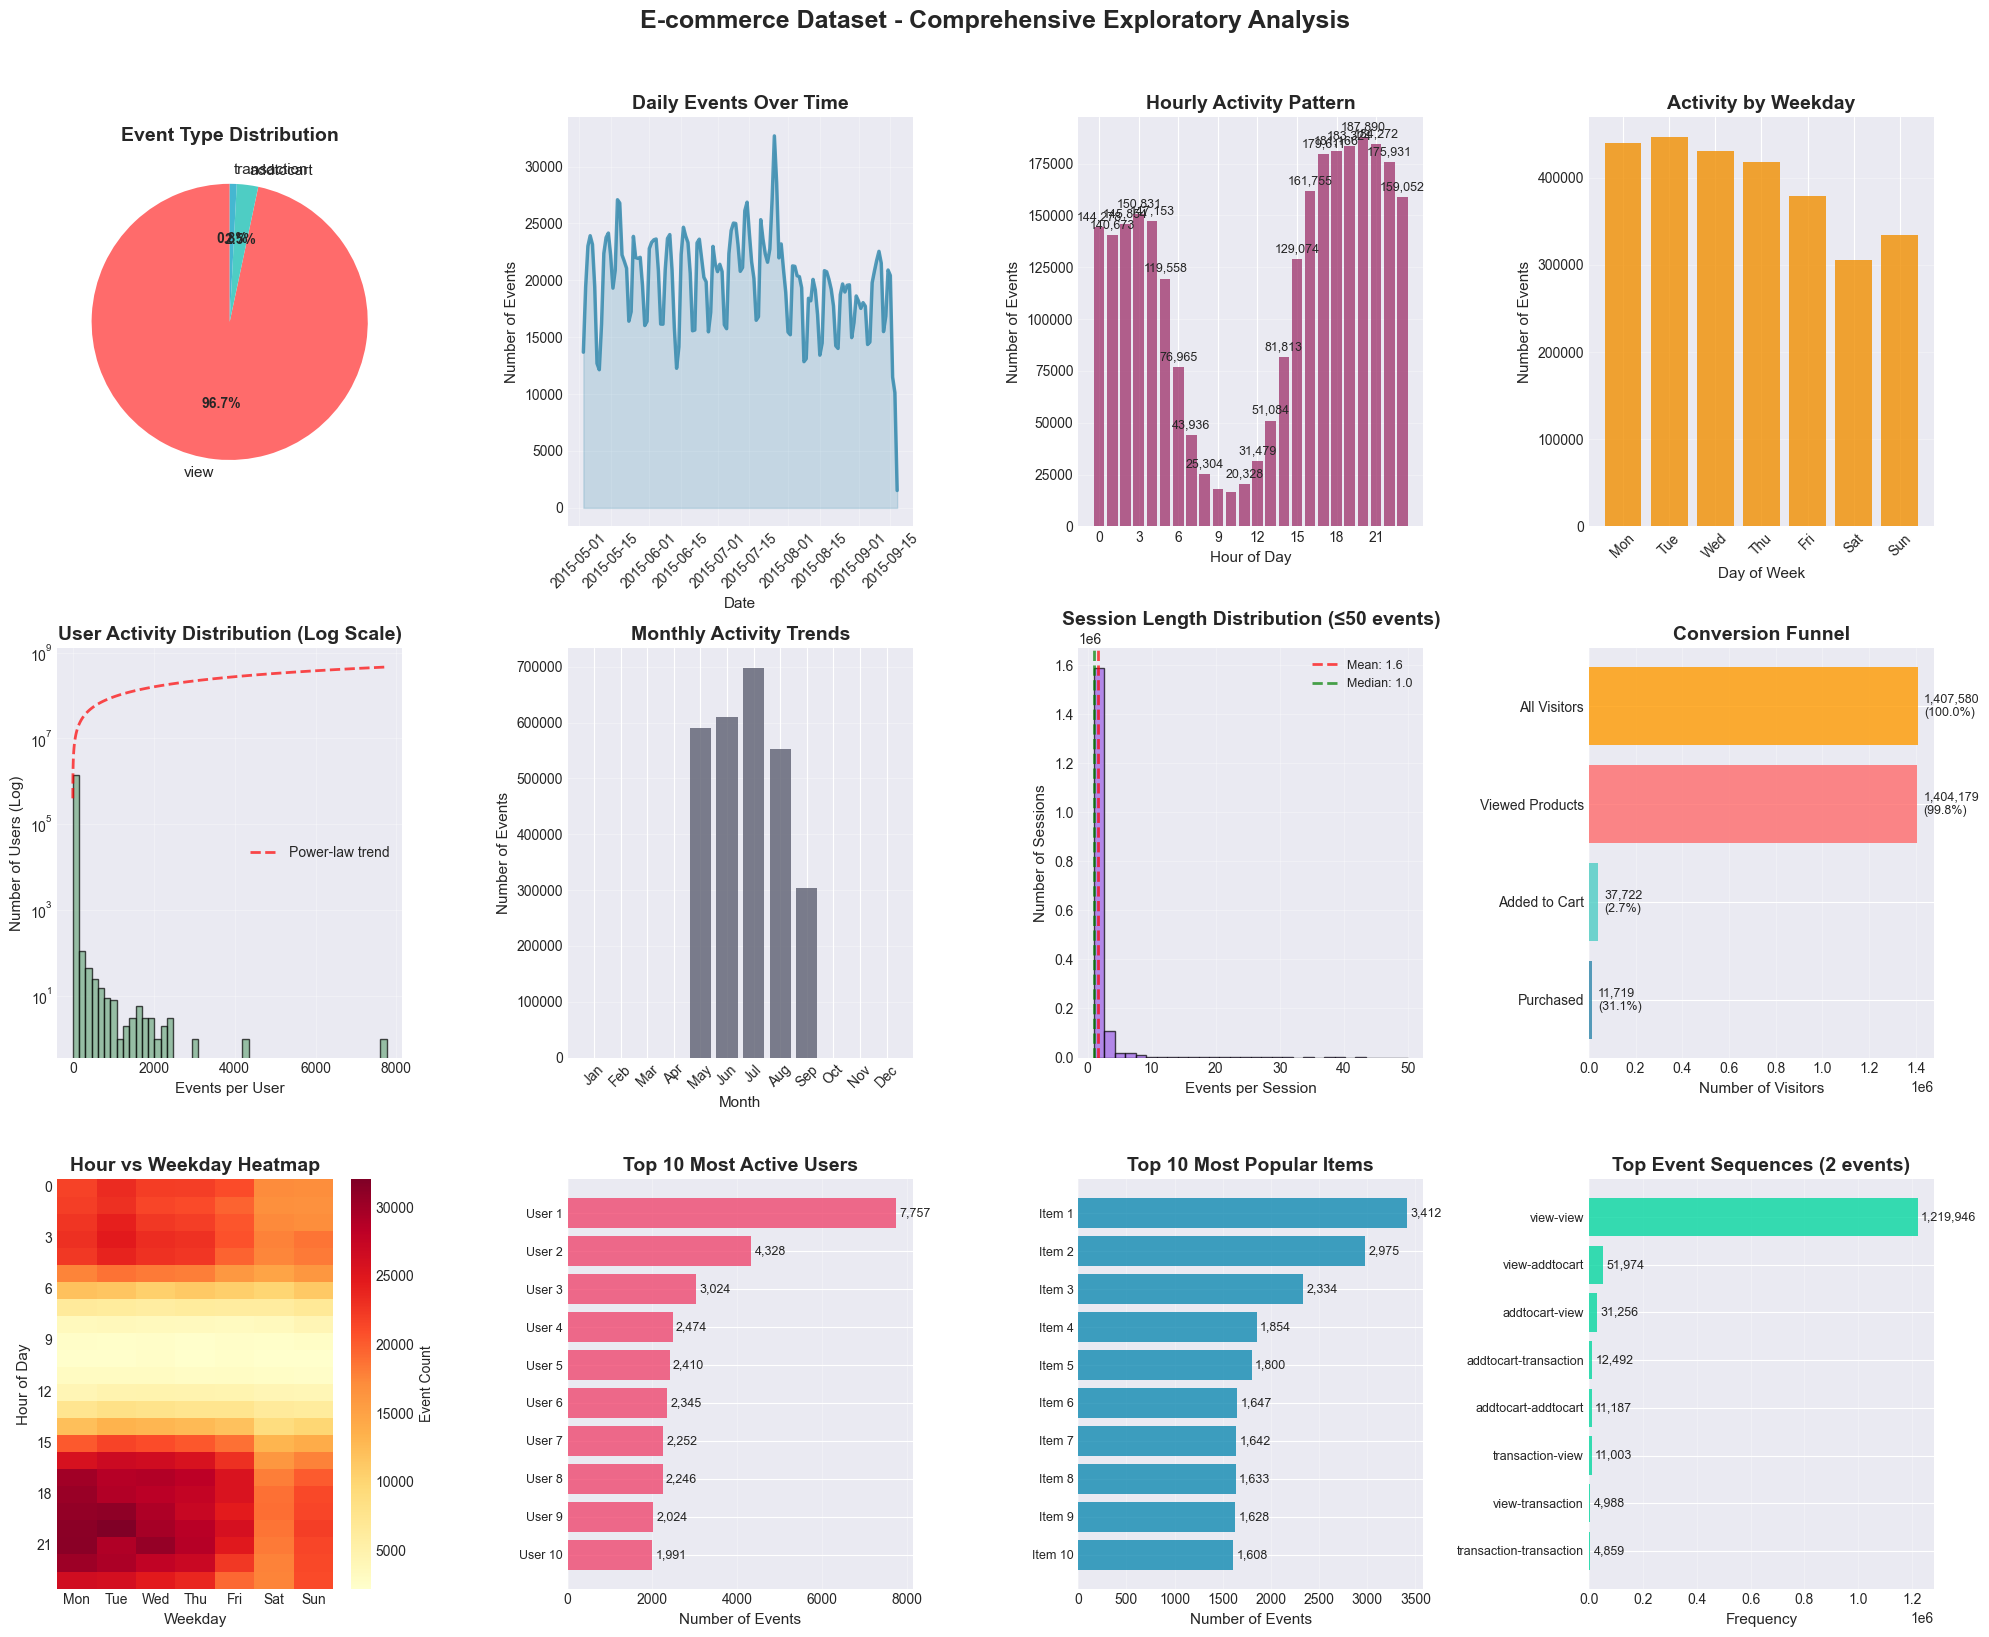


ADDITIONAL STATISTICAL INSIGHTS:
----------------------------------------

User Engagement Statistics:
Average events per user: 2.0
Median events per user: 1.0
Std dev events per user: 12.6
Max events per user: 7,757
Min events per user: 1

User Lifetime Statistics:
Average lifetime (days): 3.3
Median lifetime (days): 1.0
Active users (≥2 days): 124,929

Daily Activity Statistics:
Average events per day per user: 1.43
Median events per day per user: 1.00

Pareto Analysis (80/20 Rule):
Top 20% of users generate: 54.6% of all events
Number of highly active users (top 20%): 281,516

Retention Analysis:
Users active on multiple days: 124,929 (8.9%)
Single-day users: 1,282,651 (91.1%)



In [5]:
# Cell 4: Exploratory Data Visualization
print("\n" + "=" * 60)
print("EXPLORATORY DATA VISUALIZATION")
print("=" * 60)

# Create a figure with multiple subplots for comprehensive analysis
fig = plt.figure(figsize=(20, 16))
fig.suptitle('E-commerce Dataset - Comprehensive Exploratory Analysis', 
             fontsize=18, fontweight='bold', y=1.02)

# 1. Event distribution
ax1 = plt.subplot(3, 4, 1)
event_counts = events_df['event'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
wedges, texts, autotexts = ax1.pie(event_counts.values, labels=event_counts.index, 
                                  autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Event Type Distribution', fontsize=14, fontweight='bold')
# Make labels more readable
for text in texts:
    text.set_fontsize(11)
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

# 2. Daily events over time
ax2 = plt.subplot(3, 4, 2)
daily_events = events_df.set_index('datetime').resample('D').size()
ax2.plot(daily_events.index, daily_events.values, color='#2E86AB', linewidth=2.5, alpha=0.8)
ax2.fill_between(daily_events.index, daily_events.values, alpha=0.2, color='#2E86AB')
ax2.set_title('Daily Events Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('Number of Events', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# 3. Hourly activity pattern
ax3 = plt.subplot(3, 4, 3)
hourly_events = events_df['hour'].value_counts().sort_index()
bars = ax3.bar(hourly_events.index, hourly_events.values, color='#A23B72', alpha=0.8)
ax3.set_title('Hourly Activity Pattern', fontsize=14, fontweight='bold')
ax3.set_xlabel('Hour of Day', fontsize=11)
ax3.set_ylabel('Number of Events', fontsize=11)
ax3.set_xticks(range(0, 24, 3))
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels on top bars
for bar in bars:
    height = bar.get_height()
    if height > max(hourly_events.values) * 0.1:  # Only label significant bars
        ax3.text(bar.get_x() + bar.get_width()/2., height + max(hourly_events.values)*0.01,
                f'{int(height):,}', ha='center', va='bottom', fontsize=9)

# 4. Weekday activity
ax4 = plt.subplot(3, 4, 4)
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_events = events_df['weekday'].value_counts().sort_index()
bars = ax4.bar(range(len(weekday_names)), weekday_events.values, color='#F18F01', alpha=0.8)
ax4.set_title('Activity by Weekday', fontsize=14, fontweight='bold')
ax4.set_xlabel('Day of Week', fontsize=11)
ax4.set_ylabel('Number of Events', fontsize=11)
ax4.set_xticks(range(len(weekday_names)))
ax4.set_xticklabels([name[:3] for name in weekday_names], rotation=45)
ax4.grid(True, alpha=0.3, axis='y')

# 5. User activity distribution (log scale)
ax5 = plt.subplot(3, 4, 5)
user_event_counts = events_df.groupby('visitorid').size()
n, bins, patches = ax5.hist(user_event_counts, bins=50, color='#73AB84', 
                           edgecolor='black', alpha=0.7, log=True)
ax5.set_title('User Activity Distribution (Log Scale)', fontsize=14, fontweight='bold')
ax5.set_xlabel('Events per User', fontsize=11)
ax5.set_ylabel('Number of Users (Log)', fontsize=11)
ax5.grid(True, alpha=0.3)
ax5.set_yscale('log')

# Add power-law trend line if applicable
if len(user_event_counts) > 0:
    try:
        # Fit power law (simplified)
        x = np.sort(user_event_counts.values)
        y = np.arange(1, len(x) + 1) / len(x)
        mask = x > 0
        if mask.sum() > 10:
            coeffs = np.polyfit(np.log(x[mask]), np.log(y[mask]), 1)
            poly = np.poly1d(coeffs)
            x_fit = np.logspace(np.log10(x[mask].min()), np.log10(x[mask].max()), 100)
            y_fit = np.exp(poly(np.log(x_fit)))
            ax5.plot(x_fit, y_fit * len(x), 'r--', linewidth=2, alpha=0.7, 
                    label='Power-law trend')
            ax5.legend()
    except:
        pass

# 6. Monthly trends
ax6 = plt.subplot(3, 4, 6)
monthly_events = events_df.groupby('month').size()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_events = monthly_events.reindex(range(1, 13), fill_value=0)
bars = ax6.bar(range(1, 13), monthly_events.values, color='#5D5F71', alpha=0.8)
ax6.set_title('Monthly Activity Trends', fontsize=14, fontweight='bold')
ax6.set_xlabel('Month', fontsize=11)
ax6.set_ylabel('Number of Events', fontsize=11)
ax6.set_xticks(range(1, 13))
ax6.set_xticklabels(months, rotation=45)
ax6.grid(True, alpha=0.3, axis='y')

# 7. Session length distribution
ax7 = plt.subplot(3, 4, 7)
session_lengths = session_stats['event_count']
n, bins, patches = ax7.hist(session_lengths[session_lengths <= 50], bins=30, 
                           color='#9B5DE5', alpha=0.7, edgecolor='black')
ax7.set_title('Session Length Distribution (≤50 events)', fontsize=14, fontweight='bold')
ax7.set_xlabel('Events per Session', fontsize=11)
ax7.set_ylabel('Number of Sessions', fontsize=11)
ax7.grid(True, alpha=0.3)

# Add statistics
mean_len = session_lengths.mean()
median_len = session_lengths.median()
ax7.axvline(mean_len, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Mean: {mean_len:.1f}')
ax7.axvline(median_len, color='green', linestyle='--', linewidth=2, alpha=0.7, label=f'Median: {median_len:.1f}')
ax7.legend(fontsize=9)

# 8. Conversion funnel
ax8 = plt.subplot(3, 4, 8)
funnel_data = {
    'All Visitors': events_df['visitorid'].nunique(),
    'Viewed Products': events_df[events_df['event'] == 'view']['visitorid'].nunique(),
    'Added to Cart': events_df[events_df['event'] == 'addtocart']['visitorid'].nunique() if 'addtocart' in events_df['event'].unique() else 0,
    'Purchased': events_df[events_df['event'] == 'transaction']['visitorid'].nunique()
}

funnel_stages = list(funnel_data.keys())
funnel_values = list(funnel_data.values())

# Calculate percentages
funnel_percentages = [100]
for i in range(1, len(funnel_values)):
    if funnel_values[i-1] > 0:
        percentage = (funnel_values[i] / funnel_values[i-1]) * 100
        funnel_percentages.append(percentage)
    else:
        funnel_percentages.append(0)

# Create funnel chart
y_pos = np.arange(len(funnel_stages))
colors = ['#FF9A00', '#FF6B6B', '#4ECDC4', '#2E86AB']

bars = ax8.barh(y_pos, funnel_values, color=colors, alpha=0.8)
ax8.set_yticks(y_pos)
ax8.set_yticklabels(funnel_stages, fontsize=10)
ax8.invert_yaxis()
ax8.set_title('Conversion Funnel', fontsize=14, fontweight='bold')
ax8.set_xlabel('Number of Visitors', fontsize=11)
ax8.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, value, perc) in enumerate(zip(bars, funnel_values, funnel_percentages)):
    width = bar.get_width()
    ax8.text(width + max(funnel_values)*0.02, bar.get_y() + bar.get_height()/2,
             f'{value:,}\n({perc:.1f}%)', ha='left', va='center', fontsize=9)

# 9. Heatmap: Hour vs Weekday
ax9 = plt.subplot(3, 4, 9)
heatmap_data = events_df.pivot_table(index='hour', columns='weekday', 
                                     values='visitorid', aggfunc='count', fill_value=0)
sns.heatmap(heatmap_data, cmap='YlOrRd', ax=ax9, cbar_kws={'label': 'Event Count'})
ax9.set_title('Hour vs Weekday Heatmap', fontsize=14, fontweight='bold')
ax9.set_xlabel('Weekday', fontsize=11)
ax9.set_ylabel('Hour of Day', fontsize=11)
ax9.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# FIXED: Set appropriate y-tick labels for 24 hours
# Only show every 3rd hour label
ytick_positions = list(range(0, 24, 3))
ytick_labels = [str(i) for i in ytick_positions]
ax9.set_yticks([i + 0.5 for i in ytick_positions])  # Offset by 0.5 to center
ax9.set_yticklabels(ytick_labels, rotation=0)

# 10. Top active users
ax10 = plt.subplot(3, 4, 10)
top_users = events_df.groupby('visitorid').size().sort_values(ascending=False).head(10)
bars = ax10.barh(range(len(top_users)), top_users.values, color='#EF476F', alpha=0.8)
ax10.set_yticks(range(len(top_users)))
ax10.set_yticklabels([f"User {i}" for i in range(1, 11)], fontsize=9)
ax10.invert_yaxis()
ax10.set_title('Top 10 Most Active Users', fontsize=14, fontweight='bold')
ax10.set_xlabel('Number of Events', fontsize=11)
ax10.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax10.text(width + max(top_users.values)*0.01, bar.get_y() + bar.get_height()/2,
              f'{int(width):,}', ha='left', va='center', fontsize=9)

# 11. Top popular items
ax11 = plt.subplot(3, 4, 11)
top_items = events_df.groupby('itemid').size().sort_values(ascending=False).head(10)
bars = ax11.barh(range(len(top_items)), top_items.values, color='#118AB2', alpha=0.8)
ax11.set_yticks(range(len(top_items)))
ax11.set_yticklabels([f"Item {i}" for i in range(1, 11)], fontsize=9)
ax11.invert_yaxis()
ax11.set_title('Top 10 Most Popular Items', fontsize=14, fontweight='bold')
ax11.set_xlabel('Number of Events', fontsize=11)
ax11.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax11.text(width + max(top_items.values)*0.01, bar.get_y() + bar.get_height()/2,
              f'{int(width):,}', ha='left', va='center', fontsize=9)

# 12. Event sequence analysis
ax12 = plt.subplot(3, 4, 12)

# Get sequences of events for users with multiple events
user_sequences = events_df.groupby('visitorid')['event'].apply(list)
sequence_lengths = user_sequences.apply(len)

# Analyze common 2-event sequences
two_event_sequences = {}
for seq in user_sequences[sequence_lengths >= 2]:
    for i in range(len(seq) - 1):
        sequence = f"{seq[i]}-{seq[i+1]}"
        two_event_sequences[sequence] = two_event_sequences.get(sequence, 0) + 1

# Get top sequences
top_sequences = sorted(two_event_sequences.items(), key=lambda x: x[1], reverse=True)[:8]
sequences = [seq[0] for seq in top_sequences]
counts = [seq[1] for seq in top_sequences]

bars = ax12.barh(range(len(sequences)), counts, color='#06D6A0', alpha=0.8)
ax12.set_yticks(range(len(sequences)))
ax12.set_yticklabels(sequences, fontsize=9)
ax12.invert_yaxis()
ax12.set_title('Top Event Sequences (2 events)', fontsize=14, fontweight='bold')
ax12.set_xlabel('Frequency', fontsize=11)
ax12.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax12.text(width + max(counts)*0.01, bar.get_y() + bar.get_height()/2,
              f'{int(width):,}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Additional statistical analysis
print("\nADDITIONAL STATISTICAL INSIGHTS:")
print("-" * 40)

# User engagement analysis
user_engagement = events_df.groupby('visitorid').agg({
    'event': 'count',
    'datetime': ['min', 'max']
}).reset_index()
user_engagement.columns = ['visitorid', 'event_count', 'first_event', 'last_event']

user_engagement['user_lifetime_days'] = (user_engagement['last_event'] - user_engagement['first_event']).dt.days + 1
user_engagement['events_per_day'] = user_engagement['event_count'] / user_engagement['user_lifetime_days'].replace(0, 1)

print(f"\nUser Engagement Statistics:")
print(f"Average events per user: {user_engagement['event_count'].mean():.1f}")
print(f"Median events per user: {user_engagement['event_count'].median():.1f}")
print(f"Std dev events per user: {user_engagement['event_count'].std():.1f}")
print(f"Max events per user: {user_engagement['event_count'].max():,}")
print(f"Min events per user: {user_engagement['event_count'].min():,}")

print(f"\nUser Lifetime Statistics:")
print(f"Average lifetime (days): {user_engagement['user_lifetime_days'].mean():.1f}")
print(f"Median lifetime (days): {user_engagement['user_lifetime_days'].median():.1f}")
print(f"Active users (≥2 days): {(user_engagement['user_lifetime_days'] > 1).sum():,}")

print(f"\nDaily Activity Statistics:")
print(f"Average events per day per user: {user_engagement['events_per_day'].mean():.2f}")
print(f"Median events per day per user: {user_engagement['events_per_day'].median():.2f}")

# Pareto analysis (80/20 rule)
sorted_users = user_engagement.sort_values('event_count', ascending=False)
sorted_users['cumulative_percentage'] = sorted_users['event_count'].cumsum() / sorted_users['event_count'].sum() * 100

top_20_percent = len(sorted_users) * 0.2
top_users_20 = sorted_users.head(int(top_20_percent))
percentage_of_events = top_users_20['event_count'].sum() / sorted_users['event_count'].sum() * 100

print(f"\nPareto Analysis (80/20 Rule):")
print(f"Top 20% of users generate: {percentage_of_events:.1f}% of all events")
print(f"Number of highly active users (top 20%): {int(top_20_percent):,}")

# Retention analysis
print("\nRetention Analysis:")
# Simple retention: users with events on multiple days
multi_day_users = user_engagement[user_engagement['user_lifetime_days'] > 1]
print(f"Users active on multiple days: {len(multi_day_users):,} ({len(multi_day_users)/len(user_engagement)*100:.1f}%)")
print(f"Single-day users: {(user_engagement['user_lifetime_days'] == 1).sum():,} ({(user_engagement['user_lifetime_days'] == 1).sum()/len(user_engagement)*100:.1f}%)")

print("\n" + "=" * 60)

In [6]:
# Cell 5: Time-Based Splitting (CRITICAL - No Leakage)
print("\n" + "=" * 60)
print("TIME-BASED SPLITTING (NO DATA LEAKAGE)")
print("=" * 60)

# Keep only essential columns for efficiency
print("\nPreparing data for time-based splitting...")
events_df_clean = events_df[['timestamp', 'visitorid', 'event', 'itemid', 'transactionid', 'datetime']].copy()

# Sort by datetime to ensure proper splitting
events_df_clean = events_df_clean.sort_values('datetime').reset_index(drop=True)

# 80/15/5 split by time (Train/Validation/Test)
print("\nPerforming time-based split...")
train_ratio = 0.80
val_ratio = 0.15
test_ratio = 0.05

# Calculate split indices based on time
split_idx_80 = int(len(events_df_clean) * train_ratio)
split_idx_95 = int(len(events_df_clean) * (train_ratio + val_ratio))

# Split data
train_events_raw = events_df_clean.iloc[:split_idx_80].copy()
val_events_raw = events_df_clean.iloc[split_idx_80:split_idx_95].copy()
test_events_raw = events_df_clean.iloc[split_idx_95:].copy()

print(f"\nSplit Statistics:")
print(f"Training set:   {len(train_events_raw):,} events ({len(train_events_raw)/len(events_df_clean)*100:.1f}%)")
print(f"Validation set: {len(val_events_raw):,} events ({len(val_events_raw)/len(events_df_clean)*100:.1f}%)")
print(f"Test set:       {len(test_events_raw):,} events ({len(test_events_raw)/len(events_df_clean)*100:.1f}%)")

print(f"\nTime Ranges:")
print(f"Training:   {train_events_raw['datetime'].min()} to {train_events_raw['datetime'].max()}")
print(f"Validation: {val_events_raw['datetime'].min()} to {val_events_raw['datetime'].max()}")
print(f"Test:       {test_events_raw['datetime'].min()} to {test_events_raw['datetime'].max()}")

# Verify no overlap
print(f"\nLeakage Check:")
print(f"Training max < Validation min: {train_events_raw['datetime'].max() < val_events_raw['datetime'].min()}")
print(f"Validation max < Test min: {val_events_raw['datetime'].max() < test_events_raw['datetime'].min()}")
print("✓ All splits are chronologically separated - NO DATA LEAKAGE")

# Create features for each split separately
print("\nCreating time-based features for each split...")

def add_time_features(df):
    """Add time-based features to dataframe"""
    df_copy = df.copy()
    df_copy['date'] = df_copy['datetime'].dt.date
    df_copy['hour'] = df_copy['datetime'].dt.hour
    df_copy['weekday'] = df_copy['datetime'].dt.dayofweek
    df_copy['weekday_name'] = df_copy['datetime'].dt.day_name()
    df_copy['month'] = df_copy['datetime'].dt.month
    df_copy['is_weekend'] = df_copy['weekday'].isin([5, 6]).astype(int)
    df_copy['hour_category'] = pd.cut(df_copy['hour'], 
                                     bins=[-1, 6, 12, 18, 24], 
                                     labels=['Night', 'Morning', 'Afternoon', 'Evening'])
    return df_copy

train_events = add_time_features(train_events_raw)
val_events = add_time_features(val_events_raw)
test_events = add_time_features(test_events_raw)

print("\nFeature Engineering Summary:")
print(f"Training set features: {train_events.shape[1]} columns")
print(f"Validation set features: {val_events.shape[1]} columns")
print(f"Test set features: {test_events.shape[1]} columns")

print("\n" + "=" * 60)



TIME-BASED SPLITTING (NO DATA LEAKAGE)

Preparing data for time-based splitting...

Performing time-based split...

Split Statistics:
Training set:   2,204,512 events (80.0%)
Validation set: 413,346 events (15.0%)
Test set:       137,783 events (5.0%)

Time Ranges:
Training:   2015-05-03 03:00:04.384000 to 2015-08-18 04:23:01.129000
Validation: 2015-08-18 04:23:20.445000 to 2015-09-10 02:44:01.814000
Test:       2015-09-10 02:44:02.167000 to 2015-09-18 02:59:47.788000

Leakage Check:
Training max < Validation min: True
Validation max < Test min: True
✓ All splits are chronologically separated - NO DATA LEAKAGE

Creating time-based features for each split...

Feature Engineering Summary:
Training set features: 13 columns
Validation set features: 13 columns
Test set features: 13 columns



In [7]:
# Cell 6: Prepare Item-Category Mapping
print("\n" + "=" * 60)
print("ITEM-CATEGORY MAPPING PREPARATION")
print("=" * 60)

print("\nProcessing item properties...")
item_prop = pd.concat([item_prop1, item_prop2], ignore_index=True)

# Filter for category information
print("Extracting category information...")
item_categories = item_prop[item_prop['property'] == 'categoryid'].copy()

# Clean category IDs
item_categories['categoryid'] = pd.to_numeric(item_categories['value'], errors='coerce')
item_categories = item_categories.dropna(subset=['categoryid'])
item_categories['categoryid'] = item_categories['categoryid'].astype(int)

# Keep only essential columns and remove duplicates
item_categories = item_categories[['itemid', 'categoryid']].drop_duplicates()

print(f"Raw item-category pairs: {item_categories.shape[0]:,}")

# Handle multiple categories per item (take the most common)
print("\nHandling multiple categories per item...")
item_category_counts = item_categories.groupby(['itemid', 'categoryid']).size().reset_index(name='count')
item_main_category = item_category_counts.loc[item_category_counts.groupby('itemid')['count'].idxmax()]
item_categories = item_main_category[['itemid', 'categoryid']]

print(f"Unique item-category pairs after deduplication: {item_categories.shape[0]:,}")
print(f"Unique items with category: {item_categories['itemid'].nunique():,}")

# Merge with category tree
print("\nMerging with category hierarchy...")
category_df_clean = category_df.copy()
category_df_clean['categoryid'] = pd.to_numeric(category_df_clean['categoryid'], errors='coerce')
category_df_clean['parentid'] = pd.to_numeric(category_df_clean['parentid'], errors='coerce')

# Clean category tree
category_df_clean = category_df_clean.dropna(subset=['categoryid', 'parentid'])
category_df_clean['categoryid'] = category_df_clean['categoryid'].astype(int)
category_df_clean['parentid'] = category_df_clean['parentid'].astype(int)

# Merge
item_categories_full = item_categories.merge(category_df_clean, on='categoryid', how='left')

print(f"\nCategory Statistics:")
print(f"Total items with category mapping: {item_categories_full['itemid'].nunique():,}")
print(f"Items with parent category: {item_categories_full['parentid'].notna().sum():,}")
print(f"Unique parent categories: {item_categories_full['parentid'].nunique():,}")

# Handle missing parent categories
missing_parent = item_categories_full['parentid'].isna().sum()
if missing_parent > 0:
    print(f"\nItems with missing parent category: {missing_parent:,}")
    # Fill missing parent with -1
    item_categories_full['parentid'] = item_categories_full['parentid'].fillna(-1).astype(int)
    print("✓ Missing parent categories filled with -1")

# Create a simplified mapping for efficiency
item_category_mapping = item_categories_full[['itemid', 'parentid']].drop_duplicates()

print(f"\nFinal item-category mapping: {item_category_mapping.shape}")
print("✓ Item-category mapping prepared successfully!")

print("\n" + "=" * 60)



ITEM-CATEGORY MAPPING PREPARATION

Processing item properties...
Extracting category information...
Raw item-category pairs: 442,432

Handling multiple categories per item...
Unique item-category pairs after deduplication: 417,053
Unique items with category: 417,053

Merging with category hierarchy...

Category Statistics:
Total items with category mapping: 417,053
Items with parent category: 416,891
Unique parent categories: 297

Items with missing parent category: 162
✓ Missing parent categories filled with -1

Final item-category mapping: (417053, 2)
✓ Item-category mapping prepared successfully!



In [10]:
# Cell 7: Create User Features (Training Data Only)
print("\n" + "=" * 60)
print("USER FEATURE ENGINEERING (TRAINING DATA ONLY)")
print("=" * 60)

def create_user_features(events_subset, item_category_mapping):
    """Create comprehensive user features using ONLY the provided subset"""
    print(f"Processing {len(events_subset):,} events for {events_subset['visitorid'].nunique():,} users...")
    
    # Start timer
    start_time = datetime.now()
    
    # 1. User's overall engagement statistics
    print("1. Calculating basic user statistics...")
    
    user_stats = events_subset.groupby('visitorid').agg({
        'itemid': 'count',  # Total events
        'datetime': ['min', 'max', 'nunique'],  # First, last event, active days
        'event': lambda x: (x == 'transaction').sum()  # Purchase count
    }).reset_index()
    
    # Flatten column names
    user_stats.columns = ['visitorid', 'total_events', 'first_event', 'last_event', 
                         'active_days', 'purchase_count']
    
    # Calculate derived metrics
    user_stats['user_lifetime_days'] = (user_stats['last_event'] - user_stats['first_event']).dt.days + 1
    user_stats['events_per_day'] = user_stats['total_events'] / user_stats['user_lifetime_days'].replace(0, 1)
    user_stats['purchase_frequency'] = user_stats['purchase_count'] / user_stats['user_lifetime_days'].replace(0, 1)
    
    # Recency
    reference_date = events_subset['datetime'].max()
    user_stats['days_since_last_event'] = (reference_date - user_stats['last_event']).dt.days
    user_stats['days_since_first_event'] = (reference_date - user_stats['first_event']).dt.days
    
    # 2. User's browsing behavior
    print("2. Analyzing browsing behavior...")
    
    view_events = events_subset[events_subset['event'] == 'view']
    addtocart_events = events_subset[events_subset['event'] == 'addtocart'] if 'addtocart' in events_subset['event'].unique() else pd.DataFrame()
    
    view_stats = view_events.groupby('visitorid').agg({
        'itemid': ['count', 'nunique'],  # Total views, unique items viewed
        'datetime': 'count'  # Same as count, for consistency
    }).reset_index()
    
    if len(view_stats.columns) == 3:  # Handle flattening
        view_stats.columns = ['visitorid', 'total_views', 'unique_items_viewed']
    else:
        view_stats.columns = ['visitorid', 'total_views', 'unique_items_viewed', '_']
        view_stats = view_stats.drop('_', axis=1)
    
    # Add to cart statistics (if available)
    if len(addtocart_events) > 0:
        cart_stats = addtocart_events.groupby('visitorid').agg({
            'itemid': 'count'
        }).reset_index()
        cart_stats.columns = ['visitorid', 'add_to_cart_count']
    else:
        cart_stats = pd.DataFrame(columns=['visitorid', 'add_to_cart_count'])
    
    # 3. User's purchase behavior
    print("3. Analyzing purchase behavior...")
    
    purchase_events = events_subset[events_subset['event'] == 'transaction']
    
    if len(purchase_events) > 0:
        purchase_stats = purchase_events.groupby('visitorid').agg({
            'itemid': ['count', 'nunique', lambda x: x.mode()[0] if len(x.mode()) > 0 else np.nan],  # Count, unique, most purchased
            'datetime': lambda x: (x.max() - x.min()).days if len(x) > 1 else 0  # Purchase span
        }).reset_index()
        
        purchase_stats.columns = ['visitorid', 'total_purchases', 'unique_items_purchased', 
                                 'most_purchased_item', 'purchase_time_span']
        
        # Calculate purchase intervals
        purchase_events_sorted = purchase_events.sort_values(['visitorid', 'datetime'])
        purchase_events_sorted['time_diff'] = purchase_events_sorted.groupby('visitorid')['datetime'].diff()
        avg_purchase_interval = purchase_events_sorted.groupby('visitorid')['time_diff'].mean().dt.days.reset_index()
        avg_purchase_interval.columns = ['visitorid', 'avg_purchase_interval_days']
    else:
        purchase_stats = pd.DataFrame(columns=['visitorid', 'total_purchases', 'unique_items_purchased', 
                                              'most_purchased_item', 'purchase_time_span'])
        avg_purchase_interval = pd.DataFrame(columns=['visitorid', 'avg_purchase_interval_days'])
    
    # 4. User's category preferences
    print("4. Determining category preferences...")
    
    # Get user's viewed items with categories
    user_viewed_items = view_events[['visitorid', 'itemid']].drop_duplicates()
    
    # FIXED: Ensure itemid types match before merging
    # Convert item_category_mapping itemid to string to match events data
    item_category_mapping_fixed = item_category_mapping.copy()
    item_category_mapping_fixed['itemid'] = item_category_mapping_fixed['itemid'].astype(str)
    
    user_viewed_items = user_viewed_items.merge(item_category_mapping_fixed, on='itemid', how='left')
    
    # Get user's purchased items with categories
    if len(purchase_events) > 0:
        user_purchased_items = purchase_events[['visitorid', 'itemid']].drop_duplicates()
        user_purchased_items = user_purchased_items.merge(item_category_mapping_fixed, on='itemid', how='left')
    else:
        user_purchased_items = pd.DataFrame(columns=['visitorid', 'itemid', 'parentid'])
    
    # Favorite viewed category
    if len(user_viewed_items) > 0:
        viewed_category_counts = user_viewed_items.groupby(['visitorid', 'parentid']).size().reset_index(name='view_count')
        
        if len(viewed_category_counts) > 0:
            # Handle cases where idxmax might fail
            try:
                favorite_viewed_category = viewed_category_counts.loc[viewed_category_counts.groupby('visitorid')['view_count'].idxmax()]
                favorite_viewed_category = favorite_viewed_category[['visitorid', 'parentid']].rename(
                    columns={'parentid': 'fav_viewed_category'})
            except:
                # Fallback: take first category for each user
                favorite_viewed_category = viewed_category_counts.groupby('visitorid').first().reset_index()[['visitorid', 'parentid']]
                favorite_viewed_category = favorite_viewed_category.rename(columns={'parentid': 'fav_viewed_category'})
        else:
            favorite_viewed_category = pd.DataFrame(columns=['visitorid', 'fav_viewed_category'])
    else:
        favorite_viewed_category = pd.DataFrame(columns=['visitorid', 'fav_viewed_category'])
    
    # Favorite purchased category
    if len(user_purchased_items) > 0 and 'parentid' in user_purchased_items.columns:
        purchased_category_counts = user_purchased_items.groupby(['visitorid', 'parentid']).size().reset_index(name='purchase_count')
        
        if len(purchased_category_counts) > 0:
            try:
                favorite_purchased_category = purchased_category_counts.loc[purchased_category_counts.groupby('visitorid')['purchase_count'].idxmax()]
                favorite_purchased_category = favorite_purchased_category[['visitorid', 'parentid']].rename(
                    columns={'parentid': 'fav_purchased_category'})
            except:
                # Fallback: take first category for each user
                favorite_purchased_category = purchased_category_counts.groupby('visitorid').first().reset_index()[['visitorid', 'parentid']]
                favorite_purchased_category = favorite_purchased_category.rename(columns={'parentid': 'fav_purchased_category'})
        else:
            favorite_purchased_category = pd.DataFrame(columns=['visitorid', 'fav_purchased_category'])
    else:
        favorite_purchased_category = pd.DataFrame(columns=['visitorid', 'fav_purchased_category'])
    
    # 5. Session behavior
    print("5. Analyzing session behavior...")
    
    # Calculate sessions (reusing from earlier)
    events_with_sessions = events_subset.copy()
    events_with_sessions = events_with_sessions.sort_values(['visitorid', 'datetime'])
    events_with_sessions['time_diff'] = events_with_sessions.groupby('visitorid')['datetime'].diff().dt.total_seconds() / 60
    new_session = (events_with_sessions['time_diff'] > 30) | (events_with_sessions['time_diff'].isna())
    events_with_sessions['session_id'] = new_session.cumsum()
    
    session_stats = events_with_sessions.groupby(['visitorid', 'session_id']).agg({
        'datetime': ['min', 'max', 'count'],
        'event': lambda x: (x == 'transaction').any()  # Whether session resulted in purchase
    }).reset_index()
    
    session_stats.columns = ['visitorid', 'session_id', 'session_start', 'session_end', 
                            'session_events', 'session_converted']
    
    user_session_stats = session_stats.groupby('visitorid').agg({
        'session_id': 'count',
        'session_events': ['mean', 'max', 'min', 'std'],
        'session_converted': 'mean'
    }).reset_index()
    
    # Flatten the multi-level columns
    user_session_stats.columns = ['visitorid', 'total_sessions', 'avg_session_events',
                                 'max_session_events', 'min_session_events', 'std_session_events',
                                 'conversion_rate_per_session']
    
    # 6. Merge all features
    print("6. Merging all user features...")
    
    # Start with all unique users
    all_users = pd.DataFrame({'visitorid': events_subset['visitorid'].unique()})
    
    # Sequential merge to handle missing data
    features_list = [
        user_stats,
        view_stats,
        cart_stats if len(cart_stats) > 0 else pd.DataFrame(columns=['visitorid', 'add_to_cart_count']),
        purchase_stats,
        avg_purchase_interval if 'visitorid' in avg_purchase_interval.columns else pd.DataFrame(columns=['visitorid', 'avg_purchase_interval_days']),
        favorite_viewed_category,
        favorite_purchased_category,
        user_session_stats
    ]
    
    user_features = all_users.copy()
    for feature_df in features_list:
        if len(feature_df) > 0 and 'visitorid' in feature_df.columns:
            user_features = user_features.merge(feature_df, on='visitorid', how='left')
    
    # 7. Calculate derived features
    print("7. Calculating derived features...")
    
    # View to purchase conversion rate
    user_features['view_to_purchase_rate'] = user_features['total_purchases'] / user_features['total_views'].replace(0, 1)
    
    # Cart to purchase conversion (if cart data available)
    if 'add_to_cart_count' in user_features.columns:
        user_features['cart_to_purchase_rate'] = user_features['total_purchases'] / user_features['add_to_cart_count'].replace(0, 1)
    
    # Purchase intensity
    user_features['purchase_intensity'] = user_features['total_purchases'] / user_features['total_events'].replace(0, 1)
    
    # Browse to purchase ratio
    user_features['browse_to_purchase_ratio'] = user_features['total_views'] / user_features['total_purchases'].replace(0, 1)
    
    # Recency score (higher = more recent)
    # FIXED: Handle scalar max_days correctly
    max_days = user_features['days_since_last_event'].max()
    if max_days == 0:
        max_days = 1  # Avoid division by zero
    user_features['recency_score'] = 1 - (user_features['days_since_last_event'] / max_days)
    
    # Frequency score
    max_freq = user_features['total_events'].max()
    if max_freq == 0:
        max_freq = 1  # Avoid division by zero
    user_features['frequency_score'] = user_features['total_events'] / max_freq
    
    # Monetary score (simplified - using purchase count)
    max_monetary = user_features['total_purchases'].max()
    if max_monetary == 0:
        max_monetary = 1  # Avoid division by zero
    user_features['monetary_score'] = user_features['total_purchases'] / max_monetary
    
    # RFM score (combined)
    user_features['rfm_score'] = (user_features['recency_score'] + 
                                 user_features['frequency_score'] + 
                                 user_features['monetary_score']) / 3
    
    # 8. Handle missing values
    print("8. Handling missing values...")
    
    # Define fill values for each column type
    fill_values = {
        # Count columns
        'total_events': 0,
        'total_views': 0,
        'unique_items_viewed': 0,
        'add_to_cart_count': 0,
        'total_purchases': 0,
        'unique_items_purchased': 0,
        'total_sessions': 0,
        
        # Time columns
        'days_since_last_event': 999,
        'days_since_first_event': 999,
        'user_lifetime_days': 0,
        'purchase_time_span': 0,
        'avg_purchase_interval_days': 999,
        
        # Rate columns
        'events_per_day': 0,
        'purchase_frequency': 0,
        'view_to_purchase_rate': 0,
        'cart_to_purchase_rate': 0 if 'add_to_cart_count' in user_features.columns else np.nan,
        'purchase_intensity': 0,
        'browse_to_purchase_ratio': 999,  # High ratio means views but no purchases
        'conversion_rate_per_session': 0,
        
        # Score columns
        'recency_score': 0,
        'frequency_score': 0,
        'monetary_score': 0,
        'rfm_score': 0,
        
        # Session metrics
        'avg_session_events': 0,
        'max_session_events': 0,
        'min_session_events': 0,
        'std_session_events': 0,
        
        # Category columns
        'fav_viewed_category': -1,
        'fav_purchased_category': -1,
        'most_purchased_item': '-1'
    }
    
    # Apply fill values
    for col, fill_value in fill_values.items():
        if col in user_features.columns:
            user_features[col] = user_features[col].fillna(fill_value)
    
    # 9. Final cleaning
    print("9. Final cleaning and formatting...")
    
    # Ensure proper data types
    categorical_cols = ['fav_viewed_category', 'fav_purchased_category', 'most_purchased_item']
    for col in categorical_cols:
        if col in user_features.columns:
            user_features[col] = user_features[col].astype(str)
    
    # Convert infinity values to large numbers
    numeric_cols = user_features.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        user_features[col] = user_features[col].replace([np.inf, -np.inf], 999)
    
    # Calculate processing time
    processing_time = (datetime.now() - start_time).total_seconds()
    
    print(f"\n✓ User features created successfully!")
    print(f"  Total users: {len(user_features):,}")
    print(f"  Total features: {len(user_features.columns):,}")
    print(f"  Processing time: {processing_time:.1f} seconds")
    
    return user_features

# Create user features for training data
print("\nCreating user features for TRAINING data...")
train_user_features = create_user_features(train_events, item_category_mapping)

print("\nTraining User Features Preview:")
print(f"Shape: {train_user_features.shape}")
print("\nFirst 3 rows:")
print(train_user_features.head(3))
print("\nColumn names:")
print(list(train_user_features.columns))

print("\n" + "=" * 60)


USER FEATURE ENGINEERING (TRAINING DATA ONLY)

Creating user features for TRAINING data...
Processing 2,204,512 events for 1,123,765 users...
1. Calculating basic user statistics...
2. Analyzing browsing behavior...
3. Analyzing purchase behavior...
4. Determining category preferences...
5. Analyzing session behavior...
6. Merging all user features...
7. Calculating derived features...
8. Handling missing values...
9. Final cleaning and formatting...

✓ User features created successfully!
  Total users: 1,123,765
  Total features: 35
  Processing time: 314.2 seconds

Training User Features Preview:
Shape: (1123765, 35)

First 3 rows:
  visitorid  total_events             first_event              last_event  \
0    693516             3 2015-05-03 03:00:04.384 2015-05-03 03:00:29.427   
1    829044             1 2015-05-03 03:00:11.289 2015-05-03 03:00:11.289   
2    652699             1 2015-05-03 03:00:13.048 2015-05-03 03:00:13.048   

   active_days  purchase_count  user_lifetime_da

In [12]:
# Cell 8: Create Item Features (Training Data Only)
print("\n" + "=" * 60)
print("ITEM FEATURE ENGINEERING (TRAINING DATA ONLY)")
print("=" * 60)

def create_item_features(events_subset, item_category_mapping):
    """Create comprehensive item features using ONLY the provided subset"""
    print(f"Processing {len(events_subset):,} events for {events_subset['itemid'].nunique():,} items...")
    
    start_time = datetime.now()
    
    # 1. Item popularity metrics
    print("1. Calculating basic item statistics...")
    
    # Get all unique items in the subset
    all_items = pd.DataFrame({'itemid': events_subset['itemid'].unique()})
    
    # Count different types of events
    purchase_counts = events_subset[events_subset['event'] == 'transaction'].groupby('itemid').size().reset_index(name='purchase_count')
    view_counts = events_subset[events_subset['event'] == 'view'].groupby('itemid').size().reset_index(name='view_count')
    
    # Add to cart counts (if available)
    if 'addtocart' in events_subset['event'].unique():
        cart_counts = events_subset[events_subset['event'] == 'addtocart'].groupby('itemid').size().reset_index(name='cart_count')
    else:
        cart_counts = pd.DataFrame(columns=['itemid', 'cart_count'])
    
    # Unique users
    unique_buyers = events_subset[events_subset['event'] == 'transaction'].groupby('itemid')['visitorid'].nunique().reset_index(name='unique_buyers')
    unique_viewers = events_subset.groupby('itemid')['visitorid'].nunique().reset_index(name='unique_viewers')
    
    # 2. Temporal item statistics
    print("2. Analyzing temporal patterns...")
    
    # First and last seen
    item_temporal = events_subset.groupby('itemid').agg({
        'datetime': ['min', 'max', 'nunique']  # First seen, last seen, active days
    }).reset_index()
    item_temporal.columns = ['itemid', 'first_seen', 'last_seen', 'active_days']
    
    # Item lifetime
    reference_date = events_subset['datetime'].max()
    item_temporal['item_lifetime_days'] = (reference_date - item_temporal['first_seen']).dt.days + 1
    item_temporal['days_since_last_seen'] = (reference_date - item_temporal['last_seen']).dt.days
    
    # Recency score
    # FIXED: Handle scalar max_days correctly
    max_days = item_temporal['days_since_last_seen'].max()
    if max_days == 0:
        max_days = 1  # Avoid division by zero
    item_temporal['item_recency_score'] = 1 - (item_temporal['days_since_last_seen'] / max_days)
    
    # 3. Purchase patterns
    print("3. Analyzing purchase patterns...")
    
    purchase_events = events_subset[events_subset['event'] == 'transaction']
    if len(purchase_events) > 0:
        # Purchase intervals
        purchase_events_sorted = purchase_events.sort_values(['itemid', 'datetime'])
        purchase_events_sorted['time_diff'] = purchase_events_sorted.groupby('itemid')['datetime'].diff()
        
        purchase_intervals = purchase_events_sorted.groupby('itemid').agg({
            'time_diff': ['mean', 'std', 'min', 'max']
        }).reset_index()
        
        purchase_intervals.columns = ['itemid', 'avg_purchase_interval_days', 
                                     'std_purchase_interval', 'min_purchase_interval', 
                                     'max_purchase_interval']
        
        # Convert timedelta to days
        for col in ['avg_purchase_interval_days', 'std_purchase_interval', 
                   'min_purchase_interval', 'max_purchase_interval']:
            purchase_intervals[col] = purchase_intervals[col].dt.total_seconds() / (24 * 3600)
    else:
        purchase_intervals = pd.DataFrame(columns=['itemid', 'avg_purchase_interval_days', 
                                                  'std_purchase_interval', 'min_purchase_interval', 
                                                  'max_purchase_interval'])
    
    # 4. Session-level item metrics
    print("4. Analyzing session behavior...")
    
    # Recreate sessions for item analysis
    events_with_sessions = events_subset.copy()
    events_with_sessions = events_with_sessions.sort_values(['visitorid', 'datetime'])
    events_with_sessions['time_diff'] = events_with_sessions.groupby('visitorid')['datetime'].diff().dt.total_seconds() / 60
    new_session = (events_with_sessions['time_diff'] > 30) | (events_with_sessions['time_diff'].isna())
    events_with_sessions['session_id'] = new_session.cumsum()
    
    # Item performance per session
    session_item_stats = events_with_sessions.groupby(['itemid', 'session_id']).agg({
        'event': lambda x: (x == 'transaction').any()
    }).reset_index()
    session_item_stats.columns = ['itemid', 'session_id', 'converted_in_session']
    
    item_session_stats = session_item_stats.groupby('itemid').agg({
        'session_id': 'count',
        'converted_in_session': 'mean'
    }).reset_index()
    item_session_stats.columns = ['itemid', 'sessions_featured', 'session_conversion_rate']
    
    # 5. Merge all item features
    print("5. Merging all item features...")
    
    # Start with all items
    item_features = all_items.copy()
    
    # List of feature dataframes to merge
    feature_dataframes = [
        purchase_counts,
        view_counts,
        cart_counts,
        unique_buyers,
        unique_viewers,
        item_temporal,
        purchase_intervals,
        item_session_stats
    ]
    
    for feature_df in feature_dataframes:
        if len(feature_df) > 0 and 'itemid' in feature_df.columns:
            item_features = item_features.merge(feature_df, on='itemid', how='left')
    
    # 6. Calculate derived metrics
    print("6. Calculating derived metrics...")
    
    # Conversion rates
    item_features['view_to_purchase_rate'] = item_features['purchase_count'] / item_features['view_count'].replace(0, 1)
    
    if 'cart_count' in item_features.columns:
        item_features['cart_to_purchase_rate'] = item_features['purchase_count'] / item_features['cart_count'].replace(0, 1)
        item_features['view_to_cart_rate'] = item_features['cart_count'] / item_features['view_count'].replace(0, 1)
    
    # Buyer engagement
    item_features['buyer_penetration'] = item_features['unique_buyers'] / item_features['unique_viewers'].replace(0, 1)
    item_features['avg_purchases_per_buyer'] = item_features['purchase_count'] / item_features['unique_buyers'].replace(0, 1)
    
    # Popularity scores
    # FIXED: Handle scalar max values correctly
    max_views = item_features['view_count'].max()
    max_views = max(max_views, 1)  # Ensure at least 1 to avoid division by zero
    
    max_purchases = item_features['purchase_count'].max()
    max_purchases = max(max_purchases, 1)  # Ensure at least 1 to avoid division by zero
    
    item_features['view_popularity_score'] = item_features['view_count'] / max_views
    item_features['purchase_popularity_score'] = item_features['purchase_count'] / max_purchases
    
    # Combined popularity score
    item_features['overall_popularity_score'] = (item_features['view_popularity_score'] + 
                                                item_features['purchase_popularity_score']) / 2
    
    # Velocity metrics (events per day)
    item_features['views_per_day'] = item_features['view_count'] / item_features['item_lifetime_days'].replace(0, 1)
    item_features['purchases_per_day'] = item_features['purchase_count'] / item_features['item_lifetime_days'].replace(0, 1)
    
    # 7. Add category information
    print("7. Adding category information...")
    
    # FIXED: Convert item_category_mapping itemid to string to match events data
    if not item_category_mapping.empty:
        item_category_mapping_fixed = item_category_mapping.copy()
        item_category_mapping_fixed['itemid'] = item_category_mapping_fixed['itemid'].astype(str)
        item_features = item_features.merge(item_category_mapping_fixed, on='itemid', how='left')
    else:
        item_features['parentid'] = -1
    
    # 8. Handle missing values
    print("8. Handling missing values...")
    
    # Define fill values
    fill_values = {
        # Count metrics
        'purchase_count': 0,
        'view_count': 0,
        'cart_count': 0,
        'unique_buyers': 0,
        'unique_viewers': 0,
        'active_days': 0,
        'sessions_featured': 0,
        
        # Time metrics
        'item_lifetime_days': 0,
        'days_since_last_seen': 999,
        'avg_purchase_interval_days': 999,
        'std_purchase_interval': 0,
        'min_purchase_interval': 999,
        'max_purchase_interval': 999,
        
        # Rate metrics
        'view_to_purchase_rate': 0,
        'cart_to_purchase_rate': 0 if 'cart_count' in item_features.columns else np.nan,
        'view_to_cart_rate': 0 if 'cart_count' in item_features.columns else np.nan,
        'buyer_penetration': 0,
        'avg_purchases_per_buyer': 0,
        'session_conversion_rate': 0,
        
        # Score metrics
        'item_recency_score': 0,
        'view_popularity_score': 0,
        'purchase_popularity_score': 0,
        'overall_popularity_score': 0,
        
        # Velocity metrics
        'views_per_day': 0,
        'purchases_per_day': 0,
        
        # Category
        'parentid': -1
    }
    
    for col, fill_value in fill_values.items():
        if col in item_features.columns:
            item_features[col] = item_features[col].fillna(fill_value)
    
    # 9. Final processing
    print("9. Final processing...")
    
    # Replace infinite values
    numeric_cols = item_features.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        item_features[col] = item_features[col].replace([np.inf, -np.inf], 999)
    
    # Ensure proper data types
    item_features['parentid'] = item_features['parentid'].astype(int)
    
    # Calculate processing time
    processing_time = (datetime.now() - start_time).total_seconds()
    
    print(f"\n✓ Item features created successfully!")
    print(f"  Total items: {len(item_features):,}")
    print(f"  Total features: {len(item_features.columns):,}")
    print(f"  Processing time: {processing_time:.1f} seconds")
    
    return item_features

# Create item features for training data
print("\nCreating item features for TRAINING data...")
train_item_features = create_item_features(train_events, item_category_mapping)

print("\nTraining Item Features Preview:")
print(f"Shape: {train_item_features.shape}")
print("\nFirst 3 rows:")
print(train_item_features.head(3))
print("\nColumn names:")
print(list(train_item_features.columns))

print("\n" + "=" * 60)


ITEM FEATURE ENGINEERING (TRAINING DATA ONLY)

Creating item features for TRAINING data...
Processing 2,204,512 events for 212,915 items...
1. Calculating basic item statistics...
2. Analyzing temporal patterns...
3. Analyzing purchase patterns...
4. Analyzing session behavior...
5. Merging all item features...
6. Calculating derived metrics...
7. Adding category information...
8. Handling missing values...
9. Final processing...

✓ Item features created successfully!
  Total items: 212,915
  Total features: 29
  Processing time: 200.5 seconds

Training Item Features Preview:
Shape: (212915, 29)

First 3 rows:
   itemid  purchase_count  view_count  cart_count  unique_buyers  \
0  297662             0.0        48.0         4.0            0.0   
1   60987             0.0        68.0         0.0            0.0   
2  252860             0.0       189.0         0.0            0.0   

   unique_viewers              first_seen               last_seen  \
0              38 2015-05-03 03:00:04.3


FEATURE ANALYSIS AND VISUALIZATION

1. USER FEATURE ANALYSIS:
----------------------------------------
Analyzing 8 key user features...


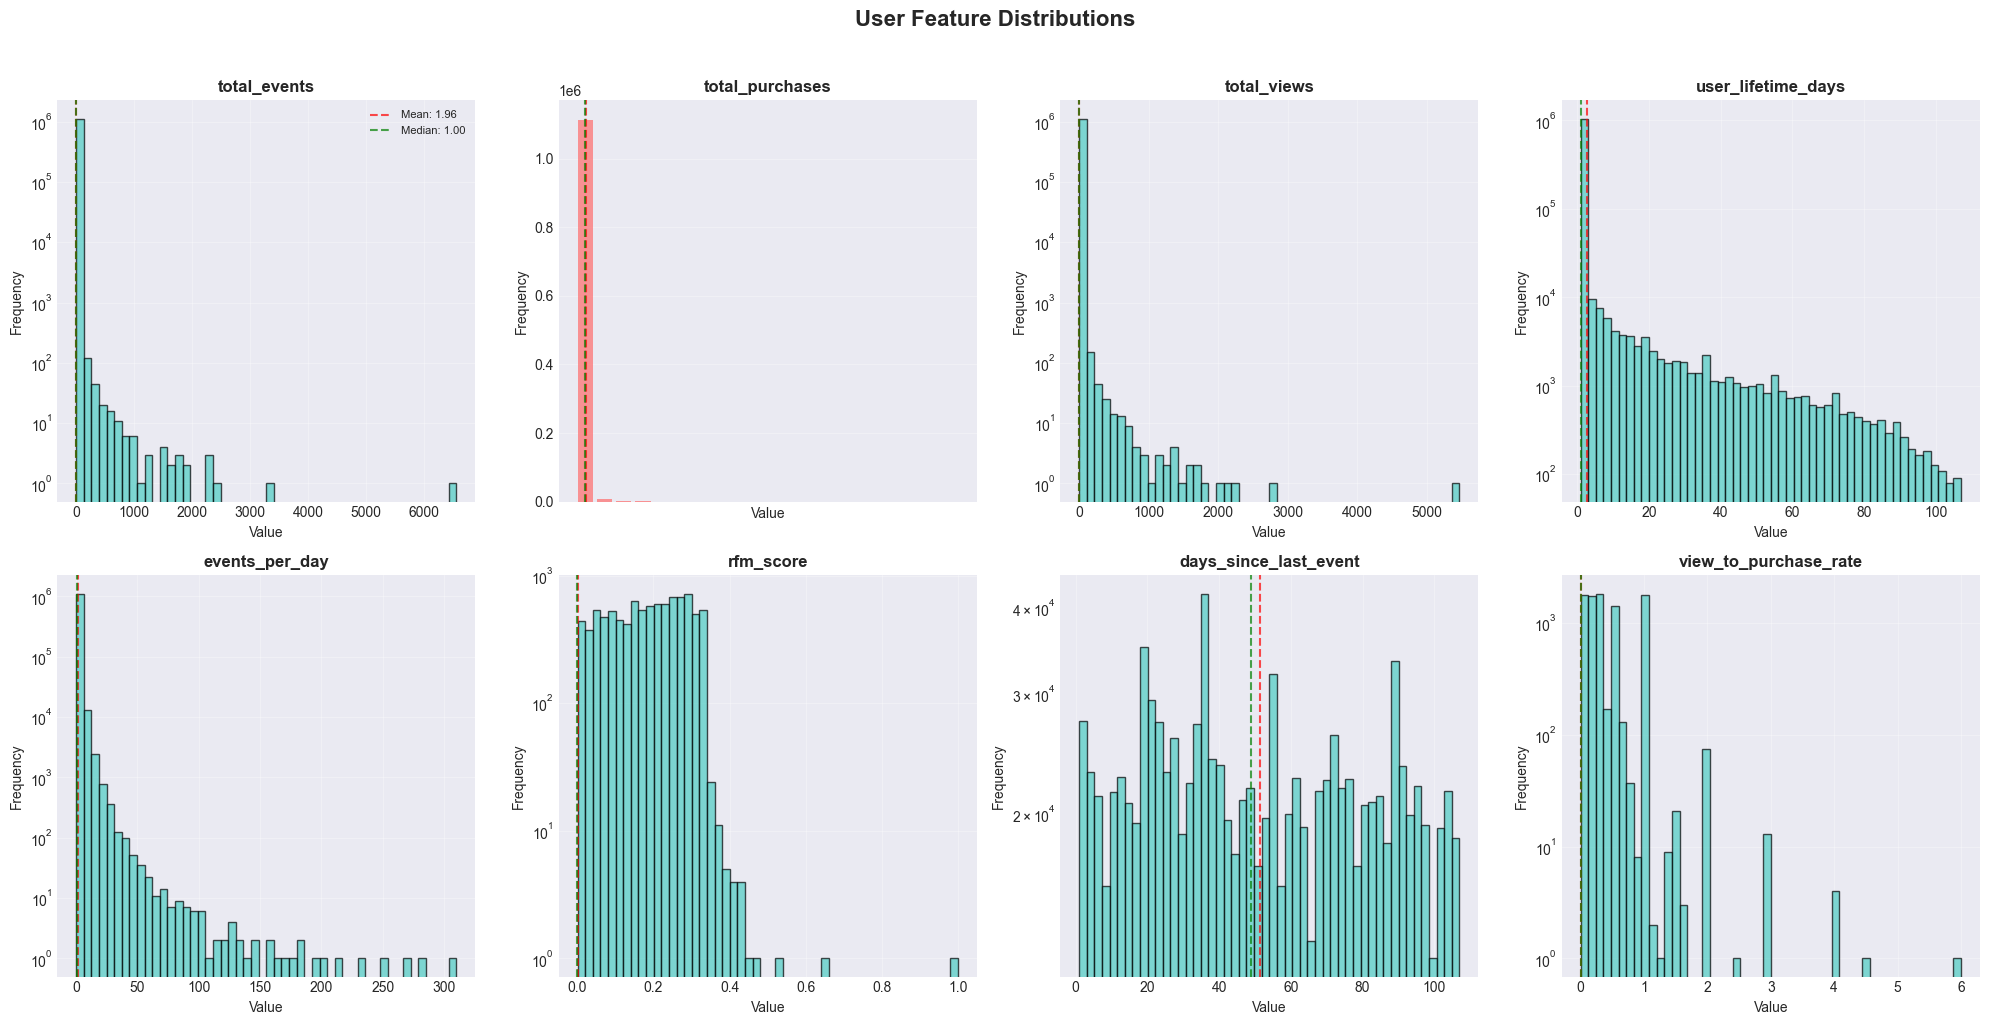


2. ITEM FEATURE ANALYSIS:
----------------------------------------
Analyzing 8 key item features...


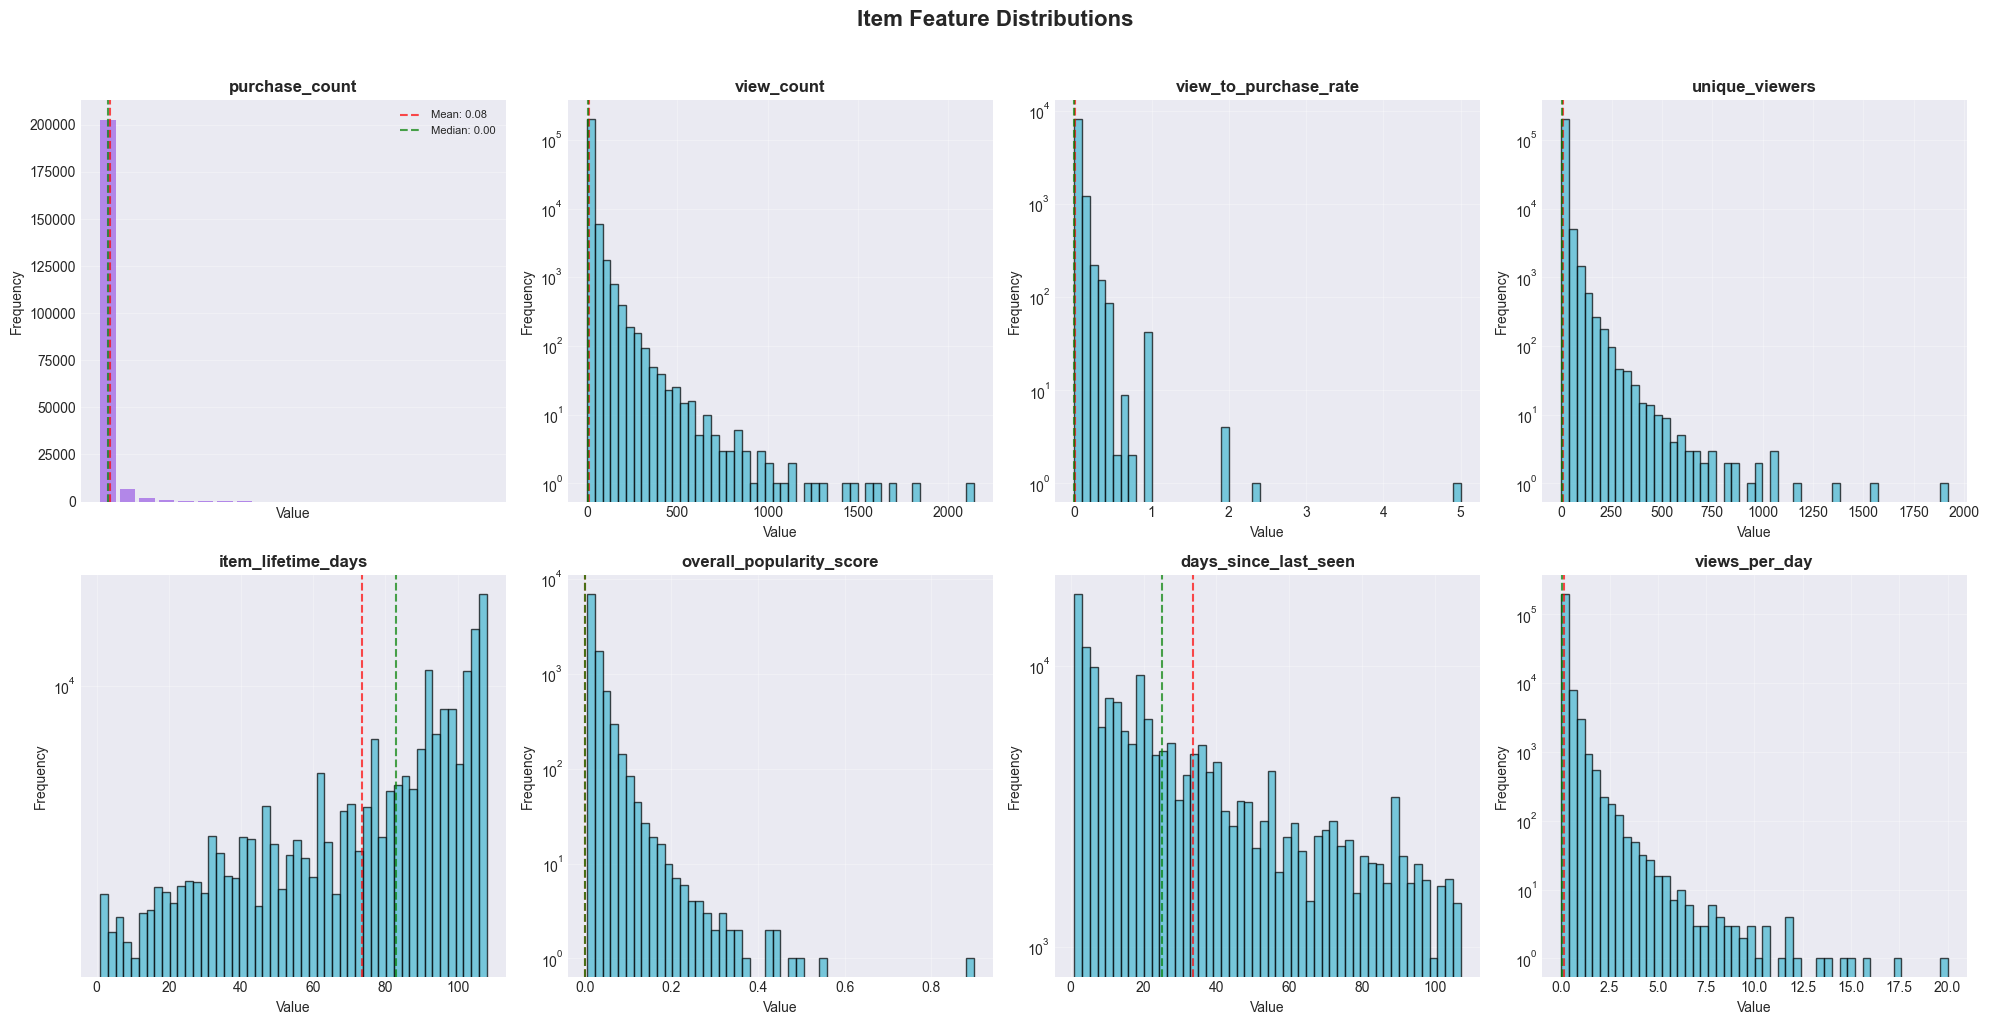


3. CORRELATION ANALYSIS:
----------------------------------------
Preparing combined feature set for correlation analysis...
Selected 15 user features and 15 item features


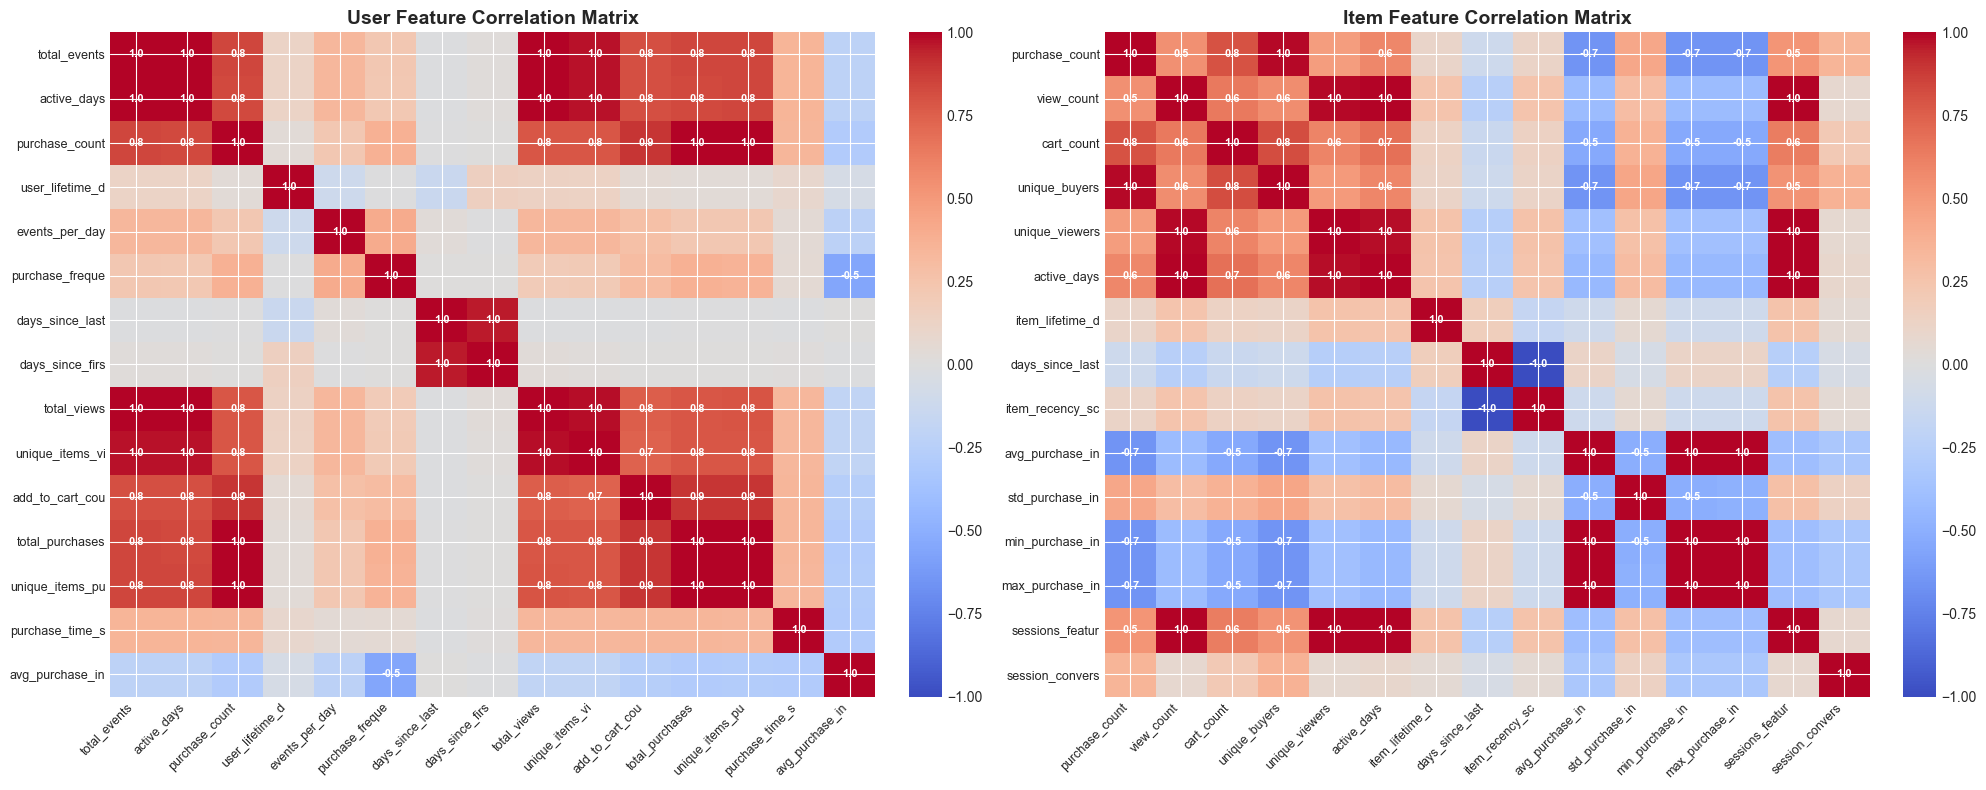


4. STATISTICAL SUMMARY:
----------------------------------------

User Features Summary:
                            mean        std       min   25%   50%   75%  \
total_events            1.961720  11.846721  1.000000   1.0   1.0   2.0   
total_purchases         0.015897   0.761578  0.000000   0.0   0.0   0.0   
total_views             1.897156  10.363297  0.000000   1.0   1.0   2.0   
user_lifetime_days      2.760995   8.843393  1.000000   1.0   1.0   1.0   
events_per_day          1.449626   1.971674  0.018692   1.0   1.0   1.0   
rfm_score               0.001521   0.018800  0.000000   0.0   0.0   0.0   
days_since_last_event  51.457704  30.650695  0.000000  25.0  49.0  78.0   
view_to_purchase_rate   0.003482   0.052362  0.000000   0.0   0.0   0.0   

                          max  
total_events           6557.0  
total_purchases         482.0  
total_views            5465.0  
user_lifetime_days      107.0  
events_per_day          310.0  
rfm_score                 1.0  
days_since

In [13]:
# Cell 9: Feature Analysis and Visualization
print("\n" + "=" * 60)
print("FEATURE ANALYSIS AND VISUALIZATION")
print("=" * 60)

# 1. User Feature Analysis
print("\n1. USER FEATURE ANALYSIS:")
print("-" * 40)

# Select key user features for analysis
key_user_features = [
    'total_events', 'total_purchases', 'total_views', 
    'user_lifetime_days', 'events_per_day', 'rfm_score',
    'days_since_last_event', 'view_to_purchase_rate'
]

# Filter to features that exist
available_user_features = [f for f in key_user_features if f in train_user_features.columns]

print(f"Analyzing {len(available_user_features)} key user features...")

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, feature in enumerate(available_user_features[:8]):  # Show first 8
    ax = axes[idx]
    
    # Handle different types of distributions
    if train_user_features[feature].nunique() > 100:
        # For continuous features with many values, use log scale
        data = train_user_features[feature]
        data = data[data > 0]  # Filter zeros for log scale
        
        if len(data) > 0:
            ax.hist(data, bins=50, alpha=0.7, color='#4ECDC4', edgecolor='black', log=True)
            ax.set_yscale('log')
    else:
        # For categorical or discrete features
        value_counts = train_user_features[feature].value_counts().head(20)
        if len(value_counts) > 10:
            ax.bar(range(len(value_counts)), value_counts.values, color='#FF6B6B', alpha=0.7)
            ax.set_xticks([])
        else:
            ax.bar(range(len(value_counts)), value_counts.values, color='#FF6B6B', alpha=0.7)
            ax.set_xticks(range(len(value_counts)))
            ax.set_xticklabels(value_counts.index, rotation=45, ha='right')
    
    ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Value', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    mean_val = train_user_features[feature].mean()
    median_val = train_user_features[feature].median()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Median: {median_val:.2f}')
    
    if idx == 0:  # Only show legend on first plot
        ax.legend(fontsize=8)

plt.suptitle('User Feature Distributions', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 2. Item Feature Analysis
print("\n2. ITEM FEATURE ANALYSIS:")
print("-" * 40)

# Select key item features for analysis
key_item_features = [
    'purchase_count', 'view_count', 'view_to_purchase_rate',
    'unique_viewers', 'item_lifetime_days', 'overall_popularity_score',
    'days_since_last_seen', 'views_per_day'
]

# Filter to features that exist
available_item_features = [f for f in key_item_features if f in train_item_features.columns]

print(f"Analyzing {len(available_item_features)} key item features...")

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, feature in enumerate(available_item_features[:8]):  # Show first 8
    ax = axes[idx]
    
    # Handle different types of distributions
    data = train_item_features[feature]
    
    if data.nunique() > 100:
        # For continuous features with many values
        data_positive = data[data > 0]
        
        if len(data_positive) > 0:
            ax.hist(data_positive, bins=50, alpha=0.7, color='#45B7D1', edgecolor='black', log=True)
            ax.set_yscale('log')
    else:
        # For categorical or discrete features
        value_counts = data.value_counts().head(20)
        if len(value_counts) > 10:
            ax.bar(range(len(value_counts)), value_counts.values, color='#9B5DE5', alpha=0.7)
            ax.set_xticks([])
        else:
            ax.bar(range(len(value_counts)), value_counts.values, color='#9B5DE5', alpha=0.7)
            ax.set_xticks(range(len(value_counts)))
            ax.set_xticklabels(value_counts.index, rotation=45, ha='right')
    
    ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Value', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    mean_val = data.mean()
    median_val = data.median()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Median: {median_val:.2f}')
    
    if idx == 0:
        ax.legend(fontsize=8)

plt.suptitle('Item Feature Distributions', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 3. Correlation Analysis
print("\n3. CORRELATION ANALYSIS:")
print("-" * 40)

# Combine user and item features for correlation analysis
print("Preparing combined feature set for correlation analysis...")

# Select numeric columns from user features
user_numeric_cols = train_user_features.select_dtypes(include=[np.number]).columns.tolist()
user_numeric_cols = [col for col in user_numeric_cols if train_user_features[col].nunique() > 1]

# Select numeric columns from item features
item_numeric_cols = train_item_features.select_dtypes(include=[np.number]).columns.tolist()
item_numeric_cols = [col for col in item_numeric_cols if train_item_features[col].nunique() > 1]

# Take top correlated features for visualization
top_user_features = user_numeric_cols[:15]  # First 15 numeric features
top_item_features = item_numeric_cols[:15]  # First 15 numeric features

print(f"Selected {len(top_user_features)} user features and {len(top_item_features)} item features")

# Create correlation matrices
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# User feature correlation
if len(top_user_features) > 1:
    user_corr = train_user_features[top_user_features].corr()
    im1 = axes[0].imshow(user_corr, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
    axes[0].set_title('User Feature Correlation Matrix', fontsize=14, fontweight='bold')
    axes[0].set_xticks(range(len(top_user_features)))
    axes[0].set_yticks(range(len(top_user_features)))
    axes[0].set_xticklabels([col[:15] for col in top_user_features], rotation=45, ha='right', fontsize=9)
    axes[0].set_yticklabels([col[:15] for col in top_user_features], fontsize=9)
    plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    
    # Add correlation values
    for i in range(len(top_user_features)):
        for j in range(len(top_user_features)):
            if abs(user_corr.iloc[i, j]) > 0.5:  # Only show strong correlations
                text = axes[0].text(j, i, f'{user_corr.iloc[i, j]:.1f}',
                                   ha="center", va="center", color="white", fontsize=8, fontweight='bold')

# Item feature correlation
if len(top_item_features) > 1:
    item_corr = train_item_features[top_item_features].corr()
    im2 = axes[1].imshow(item_corr, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
    axes[1].set_title('Item Feature Correlation Matrix', fontsize=14, fontweight='bold')
    axes[1].set_xticks(range(len(top_item_features)))
    axes[1].set_yticks(range(len(top_item_features)))
    axes[1].set_xticklabels([col[:15] for col in top_item_features], rotation=45, ha='right', fontsize=9)
    axes[1].set_yticklabels([col[:15] for col in top_item_features], fontsize=9)
    plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Add correlation values
    for i in range(len(top_item_features)):
        for j in range(len(top_item_features)):
            if abs(item_corr.iloc[i, j]) > 0.5:  # Only show strong correlations
                text = axes[1].text(j, i, f'{item_corr.iloc[i, j]:.1f}',
                                   ha="center", va="center", color="white", fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# 4. Statistical Summary
print("\n4. STATISTICAL SUMMARY:")
print("-" * 40)

print("\nUser Features Summary:")
user_summary = train_user_features[available_user_features].describe().T
print(user_summary[['mean', 'std', 'min', '25%', '50%', '75%', 'max']])

print("\nItem Features Summary:")
item_summary = train_item_features[available_item_features].describe().T
print(item_summary[['mean', 'std', 'min', '25%', '50%', '75%', 'max']])

# 5. Feature Importance Preview (using simple correlation with a proxy target)
print("\n5. FEATURE IMPORTANCE PREVIEW:")
print("-" * 40)

# Create a simple proxy target: whether user made any purchase
if 'total_purchases' in train_user_features.columns:
    proxy_target = (train_user_features['total_purchases'] > 0).astype(int)
    
    # Calculate correlation with proxy target
    feature_importance = {}
    for col in user_numeric_cols:
        if col != 'total_purchases':
            try:
                corr = np.corrcoef(train_user_features[col], proxy_target)[0, 1]
                if not np.isnan(corr):
                    feature_importance[col] = abs(corr)
            except:
                pass
    
    # Sort by importance
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:10]
    
    print("Top 10 User Features (by correlation with purchase activity):")
    for feature, importance in sorted_features:
        print(f"  {feature:30}: {importance:.4f}")

print("\n" + "=" * 60)


In [14]:
# Cell 10: Create Proper Training Dataset (No Target Leakage)
print("\n" + "=" * 60)
print("CREATING TRAINING DATASET (NO TARGET LEAKAGE)")
print("=" * 60)

def create_labeled_dataset_safe(events_data, user_features, item_features, item_category_mapping, 
                                sample_size=100000, positive_ratio=0.5, seed=42):
    """
    Create labeled dataset for training with proper negative sampling
    and NO target leakage
    """
    print(f"\nCreating labeled dataset with {sample_size:,} samples...")
    print(f"Target positive ratio: {positive_ratio:.1%}")
    
    np.random.seed(seed)
    
    # 1. Get all users and items from the events data
    all_users = events_data['visitorid'].unique()
    all_items = events_data['itemid'].unique()
    
    print(f"Available: {len(all_users):,} users, {len(all_items):,} items")
    
    # 2. Positive pairs (actual purchases)
    print("\n1. Collecting positive pairs...")
    positive_events = events_data[events_data['event'] == 'transaction']
    positive_pairs = positive_events[['visitorid', 'itemid']].drop_duplicates()
    positive_pairs['label'] = 1
    
    print(f"Positive pairs found: {len(positive_pairs):,}")
    
    # 3. Negative pairs (viewed but not purchased)
    print("\n2. Collecting negative pairs...")
    
    # Get all viewed pairs
    viewed_events = events_data[events_data['event'] == 'view']
    viewed_pairs = viewed_events[['visitorid', 'itemid']].drop_duplicates()
    
    print(f"Viewed pairs: {len(viewed_pairs):,}")
    
    # Remove pairs that were purchased (negative sampling)
    negative_candidates = pd.merge(
        viewed_pairs, 
        positive_pairs[['visitorid', 'itemid']], 
        on=['visitorid', 'itemid'], 
        how='left', 
        indicator=True
    )
    negative_candidates = negative_candidates[negative_candidates['_merge'] == 'left_only']
    negative_pairs = negative_candidates[['visitorid', 'itemid']].copy()
    negative_pairs['label'] = 0
    
    print(f"Negative pairs (viewed but not purchased): {len(negative_pairs):,}")
    
    # 4. Additional negative sampling (random user-item pairs)
    print("\n3. Generating random negative pairs...")
    
    # Calculate how many more negatives we need
    n_pos = min(len(positive_pairs), int(sample_size * positive_ratio))
    n_neg_from_viewed = min(len(negative_pairs), int(sample_size * (1 - positive_ratio)))
    n_neg_needed = int(sample_size * (1 - positive_ratio)) - n_neg_from_viewed
    
    print(f"Target: {n_pos:,} positive, {int(sample_size * (1 - positive_ratio)):,} negative")
    print(f"Available: {len(positive_pairs):,} positive, {len(negative_pairs):,} negative from views")
    print(f"Additional random negatives needed: {n_neg_needed:,}")
    
    random_negatives = []
    if n_neg_needed > 0:
        attempts = 0
        max_attempts = n_neg_needed * 10
        
        while len(random_negatives) < n_neg_needed and attempts < max_attempts:
            # Randomly sample user and item
            user = np.random.choice(all_users)
            item = np.random.choice(all_items)
            
            # Check if this pair doesn't exist in positive or viewed pairs
            is_positive = ((positive_pairs['visitorid'] == user) & 
                          (positive_pairs['itemid'] == item)).any()
            is_viewed = ((viewed_pairs['visitorid'] == user) & 
                        (viewed_pairs['itemid'] == item)).any()
            
            if not is_positive and not is_viewed:
                random_negatives.append({
                    'visitorid': user,
                    'itemid': item,
                    'label': 0
                })
            
            attempts += 1
        
        print(f"Generated {len(random_negatives):,} random negatives after {attempts:,} attempts")
        
        if len(random_negatives) > 0:
            random_negatives_df = pd.DataFrame(random_negatives)
            negative_pairs = pd.concat([negative_pairs, random_negatives_df], ignore_index=True)
    
    # 5. Balance and sample
    print("\n4. Balancing and sampling dataset...")
    
    # Sample positive pairs
    n_pos_final = min(len(positive_pairs), n_pos)
    positive_sample = positive_pairs.sample(n=n_pos_final, random_state=seed)
    
    # Sample negative pairs
    n_neg_final = min(len(negative_pairs), int(sample_size * (1 - positive_ratio)))
    negative_sample = negative_pairs.sample(n=n_neg_final, random_state=seed)
    
    # Combine
    dataset = pd.concat([positive_sample, negative_sample], ignore_index=True)
    
    print(f"Final dataset: {len(dataset):,} samples")
    print(f"Positive: {len(positive_sample):,} ({len(positive_sample)/len(dataset):.1%})")
    print(f"Negative: {len(negative_sample):,} ({len(negative_sample)/len(dataset):.1%})")
    
    # 6. Merge with features
    print("\n5. Merging with user and item features...")
    
    # Merge user features
    dataset = dataset.merge(user_features, on='visitorid', how='left')
    
    # Merge item features
    dataset = dataset.merge(item_features, on='itemid', how='left')
    
    # 7. Create interaction features (NO TARGET LEAKAGE)
    print("\n6. Creating interaction features...")
    
    # Category match
    dataset['category_match'] = (dataset['fav_purchased_category'] == dataset['parentid']).astype(int)
    
    # Fill missing category matches
    dataset['category_match'] = dataset['category_match'].fillna(0)
    
    # User-item engagement ratio (using view count as proxy)
    dataset['user_item_view_ratio'] = dataset['total_views'] / (dataset['view_count'] + 1)
    
    # User expertise in item's category
    # (This would require additional feature engineering)
    
    # 8. Select safe features (REMOVE TARGET-LEAKING FEATURES)
    print("\n7. Selecting safe features...")
    
    # Define safe feature columns (no target leakage)
    safe_features = [
        # User features
        'total_events', 'total_views', 'user_lifetime_days', 'events_per_day',
        'days_since_last_event', 'recency_score', 'frequency_score',
        'rfm_score', 'total_sessions', 'avg_session_events',
        
        # Item features  
        'view_count', 'unique_viewers', 'item_lifetime_days',
        'days_since_last_seen', 'item_recency_score', 'view_popularity_score',
        'sessions_featured', 'views_per_day',
        
        # Interaction features
        'category_match', 'user_item_view_ratio'
    ]
    
    # Filter to features that actually exist
    available_safe_features = [f for f in safe_features if f in dataset.columns]
    
    print(f"Available safe features: {len(available_safe_features)}")
    print(f"Features used: {available_safe_features}")
    
    # 9. Handle missing values
    print("\n8. Handling missing values...")
    
    # Fill missing values with appropriate defaults
    for feature in available_safe_features:
        if dataset[feature].isna().any():
            # Use median for numeric, mode for categorical
            if dataset[feature].dtype in [np.int64, np.float64]:
                fill_value = dataset[feature].median()
            else:
                fill_value = dataset[feature].mode()[0] if len(dataset[feature].mode()) > 0 else 0
            
            dataset[feature] = dataset[feature].fillna(fill_value)
            print(f"  Filled missing values in '{feature}' with {fill_value}")
    
    # 10. Final dataset
    final_columns = ['visitorid', 'itemid'] + available_safe_features + ['label']
    final_dataset = dataset[final_columns].copy()
    
    print(f"\n✓ Dataset created successfully!")
    print(f"  Final shape: {final_dataset.shape}")
    print(f"  Features: {len(available_safe_features)}")
    print(f"  Label distribution: {final_dataset['label'].value_counts().to_dict()}")
    
    return final_dataset, available_safe_features

# Create training dataset
print("Creating TRAINING dataset...")
train_dataset, feature_cols = create_labeled_dataset_safe(
    train_events, 
    train_user_features, 
    train_item_features,
    item_category_mapping,
    sample_size=100000,  # Increased sample size
    positive_ratio=0.3,  # Adjusted positive ratio
    seed=42
)

# Create validation dataset (using validation events but TRAINING features)
print("\n" + "=" * 40)
print("Creating VALIDATION dataset...")
print("=" * 40)

val_dataset, _ = create_labeled_dataset_safe(
    val_events, 
    train_user_features,  # Using TRAINING user features
    train_item_features,  # Using TRAINING item features
    item_category_mapping,
    sample_size=20000,  # Smaller validation set
    positive_ratio=0.3,  # Same positive ratio
    seed=42
)

# Create test dataset (using test events but TRAINING features)
print("\n" + "=" * 40)
print("Creating TEST dataset...")
print("=" * 40)

test_dataset, _ = create_labeled_dataset_safe(
    test_events, 
    train_user_features,  # Using TRAINING user features
    train_item_features,  # Using TRAINING item features
    item_category_mapping,
    sample_size=20000,  # Test set size
    positive_ratio=0.3,  # Same positive ratio
    seed=42
)

print("\n" + "=" * 60)


CREATING TRAINING DATASET (NO TARGET LEAKAGE)
Creating TRAINING dataset...

Creating labeled dataset with 100,000 samples...
Target positive ratio: 30.0%
Available: 1,123,765 users, 212,915 items

1. Collecting positive pairs...
Positive pairs found: 16,933

2. Collecting negative pairs...
Viewed pairs: 1,703,344
Negative pairs (viewed but not purchased): 1,688,065

3. Generating random negative pairs...
Target: 16,933 positive, 70,000 negative
Available: 16,933 positive, 1,688,065 negative from views
Additional random negatives needed: 0

4. Balancing and sampling dataset...
Final dataset: 86,933 samples
Positive: 16,933 (19.5%)
Negative: 70,000 (80.5%)

5. Merging with user and item features...

6. Creating interaction features...

7. Selecting safe features...
Available safe features: 20
Features used: ['total_events', 'total_views', 'user_lifetime_days', 'events_per_day', 'days_since_last_event', 'recency_score', 'frequency_score', 'rfm_score', 'total_sessions', 'avg_session_event


DATASET ANALYSIS AND VISUALIZATION

1. DATASET SUMMARY:
----------------------------------------

Training Dataset:
  Samples: 86,933
  Features: 20
  Positive samples: 16,933 (19.5%)
  Negative samples: 70,000 (80.5%)
  Imbalance ratio: 4.1:1

Validation Dataset:
  Samples: 17,360
  Features: 20
  Positive samples: 3,360 (19.4%)
  Negative samples: 14,000 (80.6%)
  Imbalance ratio: 4.2:1

Test Dataset:
  Samples: 15,030
  Features: 20
  Positive samples: 1,030 (6.9%)
  Negative samples: 14,000 (93.1%)
  Imbalance ratio: 13.6:1

2. FEATURE DISTRIBUTION BY LABEL:
----------------------------------------


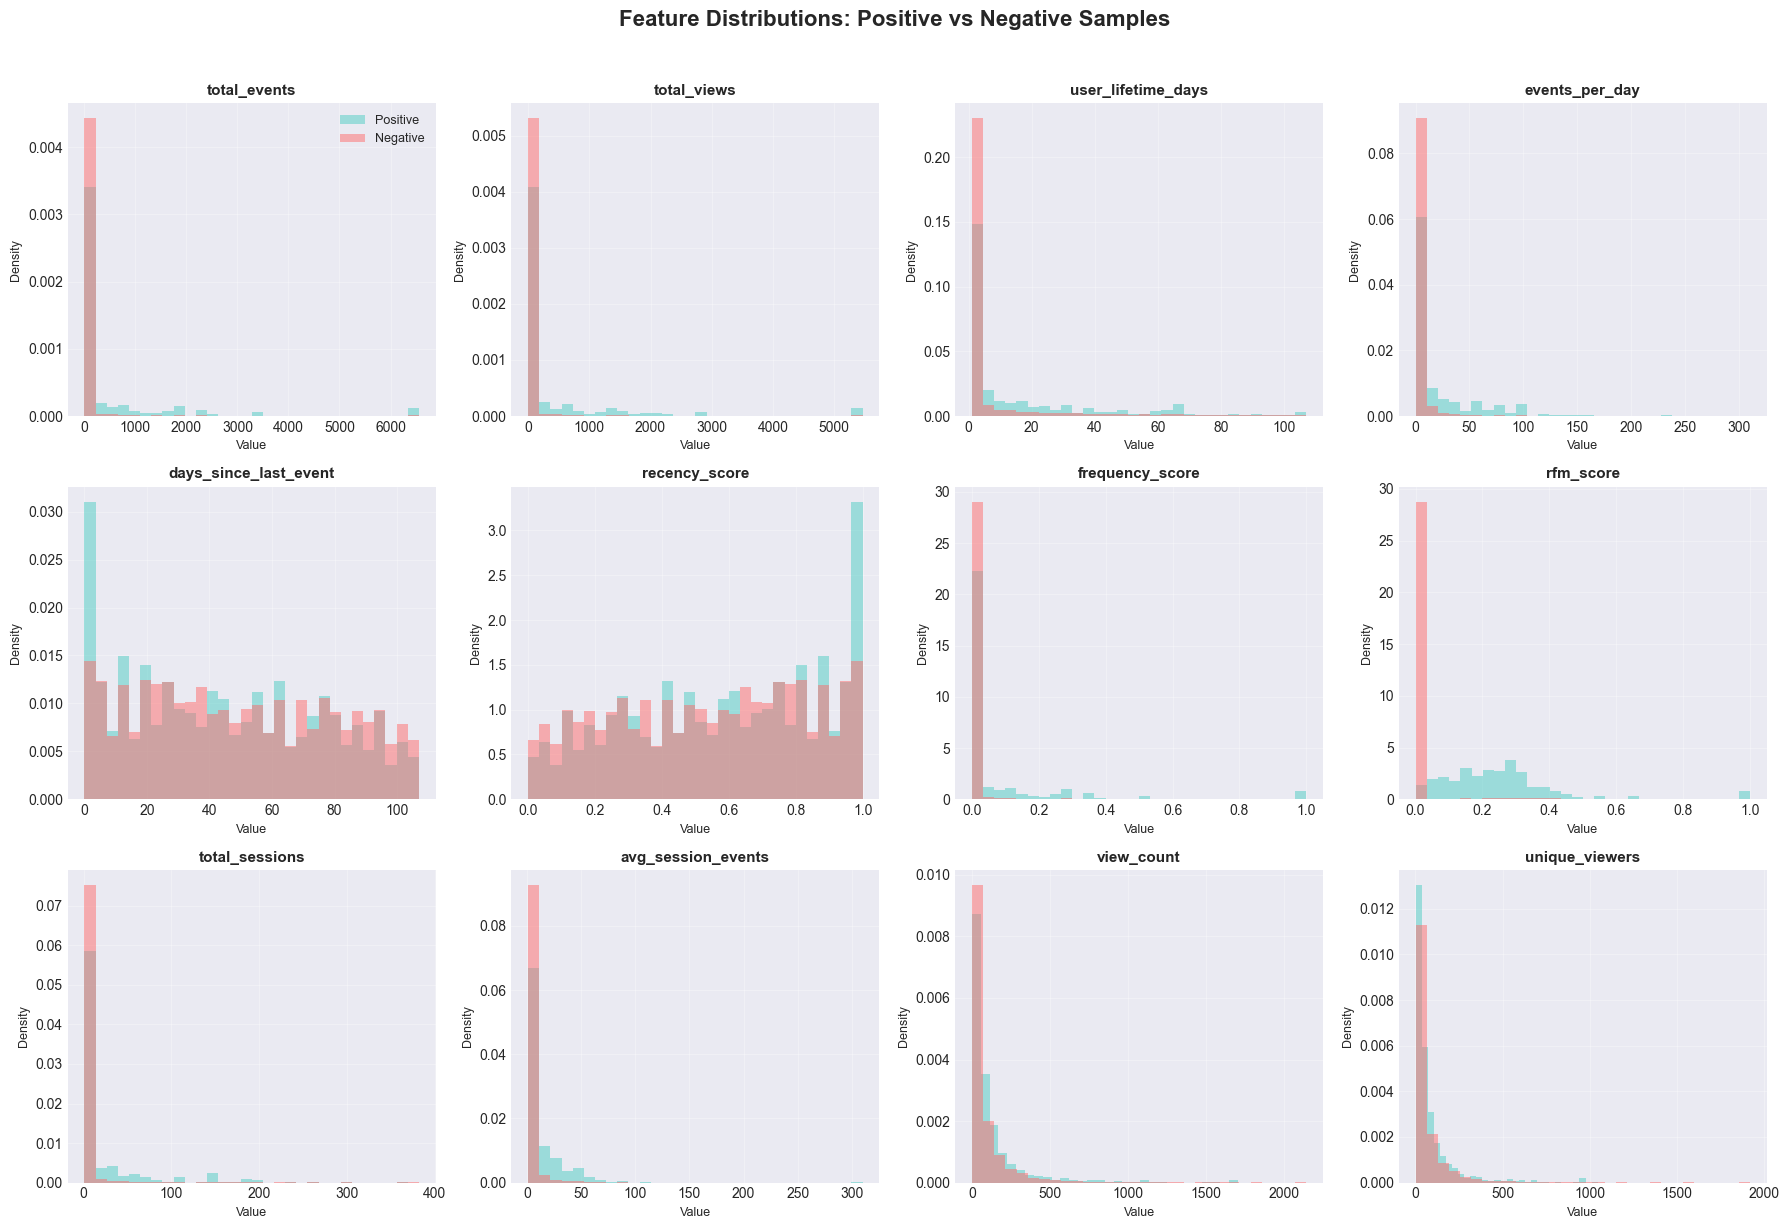


3. CORRELATION WITH TARGET VARIABLE:
----------------------------------------
Top 10 features by absolute correlation with target:
--------------------------------------------------
rfm_score                     : 0.6700
events_per_day                : 0.3454
avg_session_events            : 0.3453
total_events                  : 0.2661
frequency_score               : 0.2661
total_views                   : 0.2596
total_sessions                : 0.2261
user_lifetime_days            : 0.1872
user_item_view_ratio          : 0.0975
views_per_day                 : 0.0819


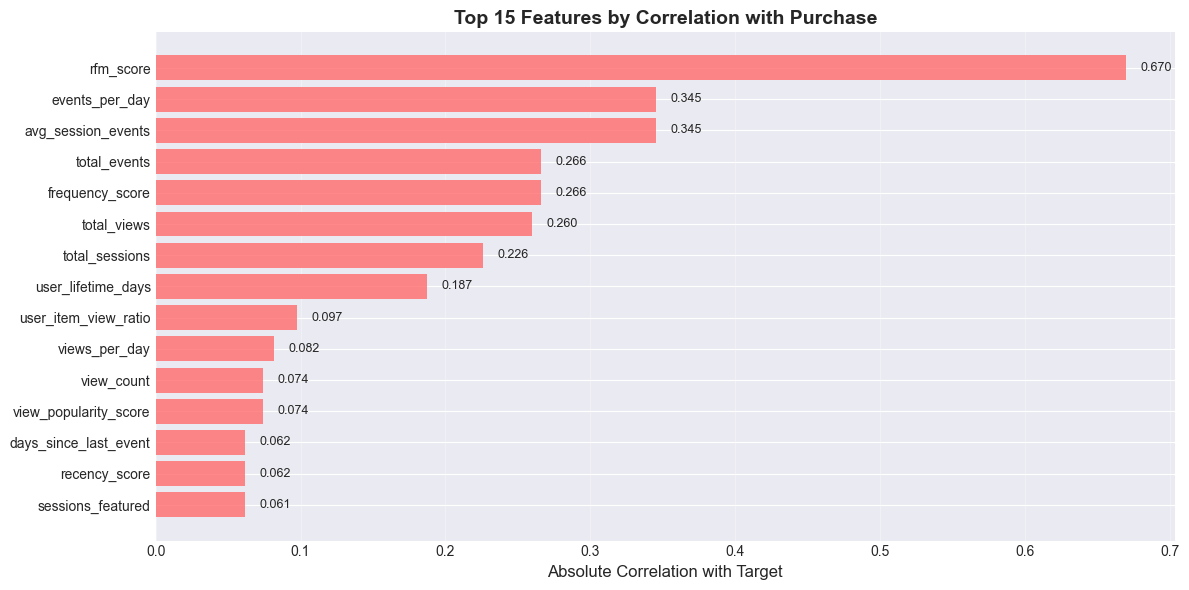


4. PAIRPLOT FOR TOP CORRELATED FEATURES:
----------------------------------------
Creating pairplot for features: ['rfm_score', 'events_per_day', 'avg_session_events', 'total_events']


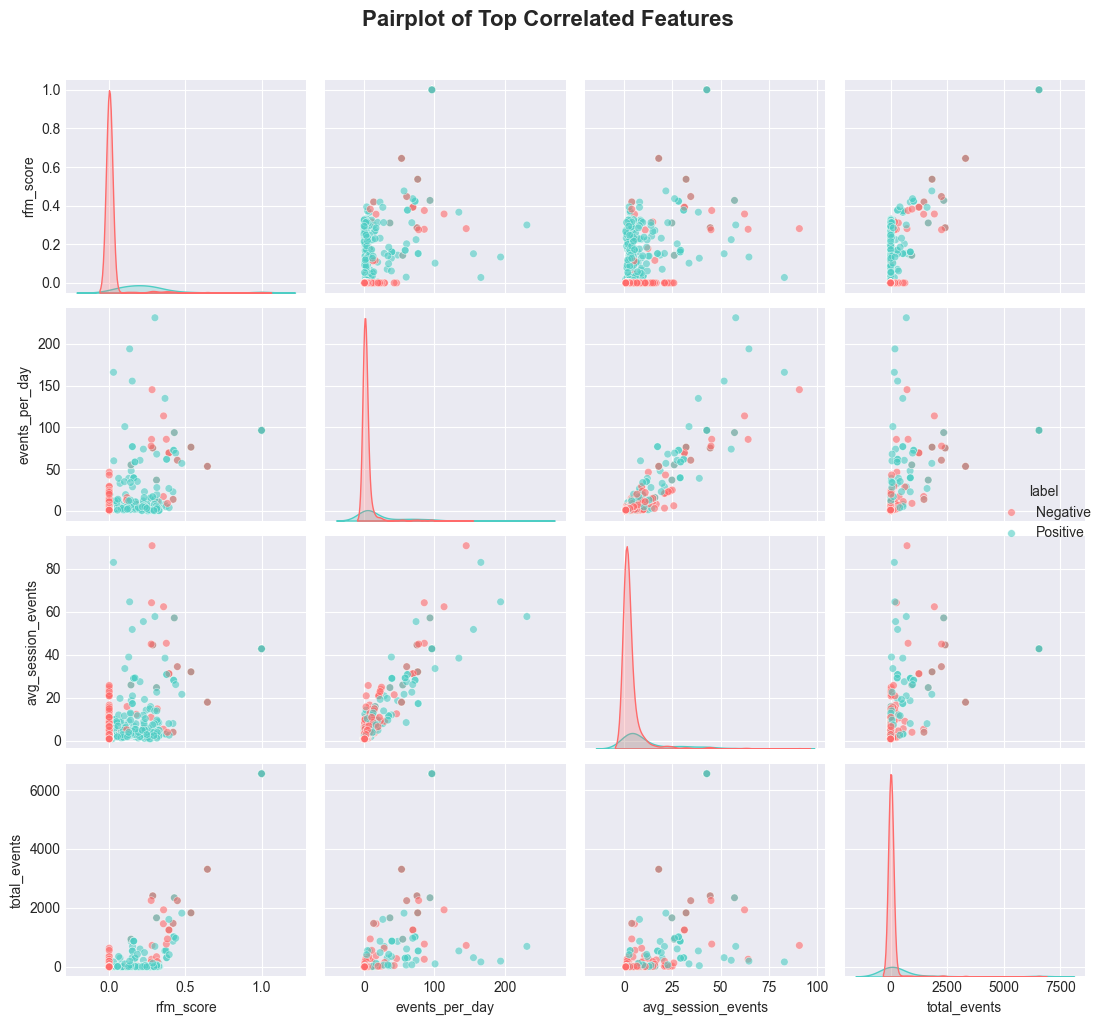


5. CLASS IMBALANCE ANALYSIS:
----------------------------------------


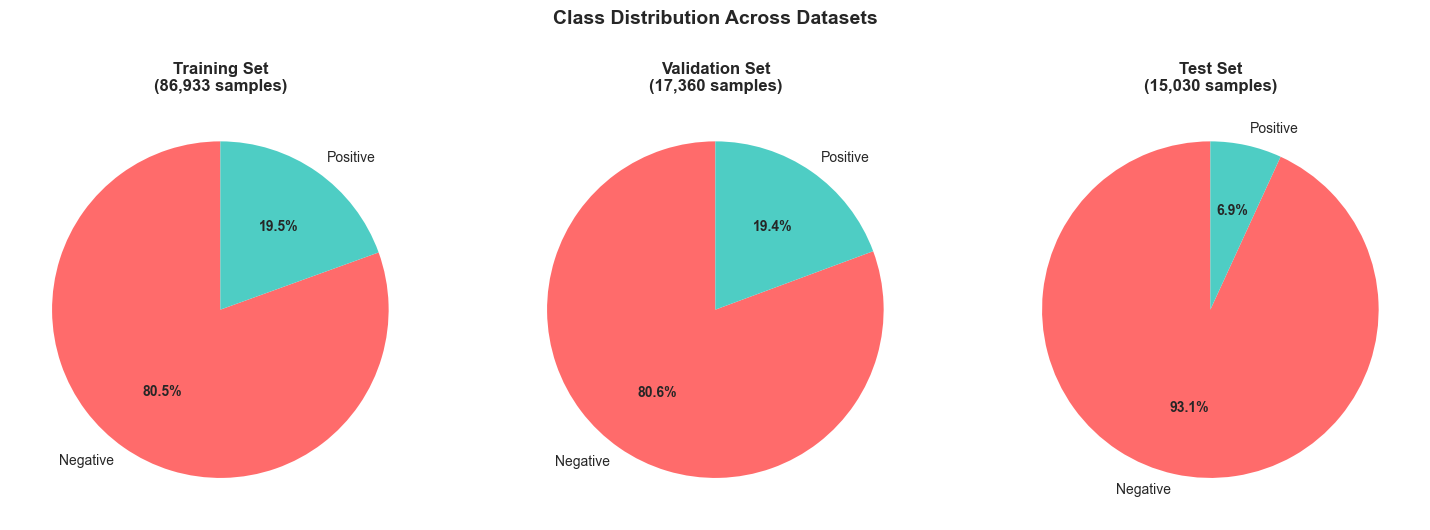


6. FEATURE SCALING ANALYSIS:
----------------------------------------
Feature value ranges before scaling:
                 Feature       Min     Max        Mean         Std
0           total_events  1.000000  6557.0  133.343126  644.071785
1            total_views  0.000000  5465.0  112.558211  540.747948
2     user_lifetime_days  1.000000   107.0    9.429963   19.948633
3         events_per_day  0.019231   310.0    7.716697   21.123501
4  days_since_last_event  0.000000   107.0   48.318763   30.925462
5          recency_score  0.000000     1.0    0.548423    0.289023
6        frequency_score  0.000153     1.0    0.020336    0.098227
7              rfm_score  0.000000     1.0    0.058047    0.137011
8         total_sessions  1.000000   382.0    8.421405   30.053655
9     avg_session_events  1.000000   310.0    5.053970   10.742141


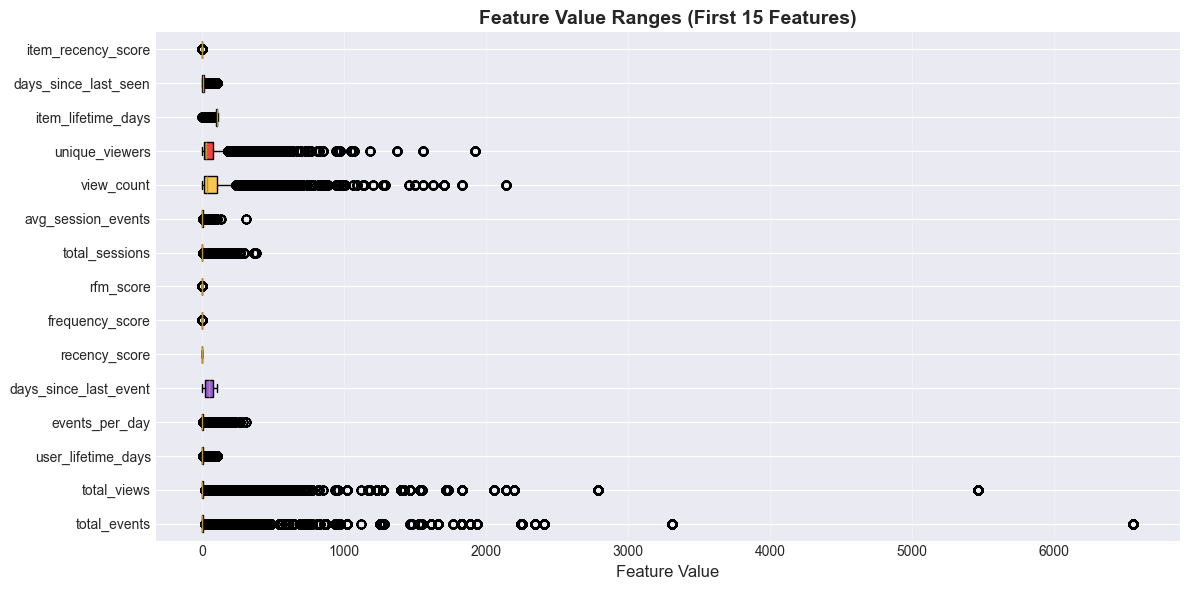

In [15]:
# Cell 11: Dataset Analysis and Visualization
print("\n" + "=" * 60)
print("DATASET ANALYSIS AND VISUALIZATION")
print("=" * 60)

# 1. Dataset Summary
print("\n1. DATASET SUMMARY:")
print("-" * 40)

datasets = {
    'Training': train_dataset,
    'Validation': val_dataset,
    'Test': test_dataset
}

for name, dataset in datasets.items():
    print(f"\n{name} Dataset:")
    print(f"  Samples: {len(dataset):,}")
    print(f"  Features: {len(feature_cols)}")
    
    if 'label' in dataset.columns:
        pos_count = dataset['label'].sum()
        neg_count = len(dataset) - pos_count
        pos_ratio = pos_count / len(dataset)
        
        print(f"  Positive samples: {pos_count:,} ({pos_ratio:.1%})")
        print(f"  Negative samples: {neg_count:,} ({1-pos_ratio:.1%})")
        print(f"  Imbalance ratio: {neg_count/pos_count:.1f}:1")

# 2. Feature Distribution by Label
print("\n2. FEATURE DISTRIBUTION BY LABEL:")
print("-" * 40)

# Plot feature distributions for positive vs negative samples
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()

# Select features to visualize
features_to_plot = feature_cols[:12]  # First 12 features

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx]
    
    # Get data for positive and negative labels
    pos_data = train_dataset[train_dataset['label'] == 1][feature]
    neg_data = train_dataset[train_dataset['label'] == 0][feature]
    
    # Plot distributions
    ax.hist(pos_data, bins=30, alpha=0.5, color='#4ECDC4', label='Positive', density=True)
    ax.hist(neg_data, bins=30, alpha=0.5, color='#FF6B6B', label='Negative', density=True)
    
    ax.set_title(f'{feature}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Value', fontsize=9)
    ax.set_ylabel('Density', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Add legend on first plot only
    if idx == 0:
        ax.legend(fontsize=9)

plt.suptitle('Feature Distributions: Positive vs Negative Samples', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 3. Correlation with Target
print("\n3. CORRELATION WITH TARGET VARIABLE:")
print("-" * 40)

# Calculate correlation of each feature with the label
correlations = {}
for feature in feature_cols:
    try:
        corr = np.corrcoef(train_dataset[feature], train_dataset['label'])[0, 1]
        if not np.isnan(corr):
            correlations[feature] = abs(corr)
    except:
        correlations[feature] = 0

# Sort by correlation strength
sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)

print("Top 10 features by absolute correlation with target:")
print("-" * 50)
for feature, corr in sorted_correlations[:10]:
    print(f"{feature:30}: {corr:.4f}")

# Visualize feature correlations
fig, ax = plt.subplots(figsize=(12, 6))
features_plot = [item[0] for item in sorted_correlations[:15]]
correlations_plot = [item[1] for item in sorted_correlations[:15]]

colors = ['#FF6B6B' if c > 0 else '#4ECDC4' for c in correlations_plot]
bars = ax.barh(range(len(features_plot)), correlations_plot, color=colors, alpha=0.8)

ax.set_yticks(range(len(features_plot)))
ax.set_yticklabels(features_plot, fontsize=10)
ax.invert_yaxis()
ax.set_xlabel('Absolute Correlation with Target', fontsize=12)
ax.set_title('Top 15 Features by Correlation with Purchase', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
            f'{width:.3f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# 4. Pairplot for Top Correlated Features
print("\n4. PAIRPLOT FOR TOP CORRELATED FEATURES:")
print("-" * 40)

# Select top 4 correlated features for pairplot
top_features = [item[0] for item in sorted_correlations[:4]]

if len(top_features) >= 4:
    print(f"Creating pairplot for features: {top_features}")
    
    # Sample data for pairplot (to avoid overcrowding)
    sample_size = min(1000, len(train_dataset))
    plot_data = train_dataset.sample(sample_size, random_state=42)[top_features + ['label']]
    
    # Convert label to string for better coloring
    plot_data['label'] = plot_data['label'].map({0: 'Negative', 1: 'Positive'})
    
    # Create pairplot
    pairplot = sns.pairplot(plot_data, hue='label', 
                           palette={'Negative': '#FF6B6B', 'Positive': '#4ECDC4'},
                           diag_kind='kde', plot_kws={'alpha': 0.6, 's': 30})
    
    pairplot.fig.suptitle('Pairplot of Top Correlated Features', 
                          fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()

# 5. Class Imbalance Analysis
print("\n5. CLASS IMBALANCE ANALYSIS:")
print("-" * 40)

# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (name, dataset) in enumerate(datasets.items()):
    ax = axes[idx]
    
    if 'label' in dataset.columns:
        label_counts = dataset['label'].value_counts()
        colors = ['#FF6B6B', '#4ECDC4']
        
        wedges, texts, autotexts = ax.pie(label_counts.values, 
                                          labels=['Negative', 'Positive'],
                                          autopct='%1.1f%%', 
                                          colors=colors,
                                          startangle=90)
        
        ax.set_title(f'{name} Set\n({len(dataset):,} samples)', 
                    fontsize=12, fontweight='bold')
        
        # Make labels more readable
        for text in texts:
            text.set_fontsize(10)
        for autotext in autotexts:
            autotext.set_fontsize(10)
            autotext.set_fontweight('bold')

plt.suptitle('Class Distribution Across Datasets', fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

# 6. Feature Scaling Analysis
print("\n6. FEATURE SCALING ANALYSIS:")
print("-" * 40)

# Check if features need scaling
print("Feature value ranges before scaling:")
feature_stats = pd.DataFrame({
    'Feature': feature_cols,
    'Min': [train_dataset[f].min() for f in feature_cols],
    'Max': [train_dataset[f].max() for f in feature_cols],
    'Mean': [train_dataset[f].mean() for f in feature_cols],
    'Std': [train_dataset[f].std() for f in feature_cols]
})

print(feature_stats.head(10))

# Visualize feature ranges
fig, ax = plt.subplots(figsize=(12, 6))
features_to_show = feature_cols[:15]  # Show first 15

# Create boxplot
box_data = [train_dataset[f] for f in features_to_show]
bp = ax.boxplot(box_data, vert=False, patch_artist=True)

# Color the boxes
colors = ['#FF9A00', '#FF6B6B', '#4ECDC4', '#2E86AB', '#9B5DE5',
          '#00BBF9', '#00F5D4', '#FF97B7', '#CAF0F8', '#90BE6D',
          '#F9C74F', '#F94144', '#43AA8B', '#577590', '#277DA1']

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_yticklabels(features_to_show, fontsize=10)
ax.set_xlabel('Feature Value', fontsize=12)
ax.set_title('Feature Value Ranges (First 15 Features)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)



In [16]:

# Cell 12: Prepare Features and Labels with Advanced Processing
print("\n" + "=" * 60)
print("ADVANCED FEATURE PREPARATION")
print("=" * 60)

print("\n1. EXTRACTING FEATURES AND LABELS:")
print("-" * 40)

# Extract features and labels from datasets
X_train_raw = train_dataset[feature_cols].copy()
y_train = train_dataset['label'].copy()

X_val_raw = val_dataset[feature_cols].copy()
y_val = val_dataset['label'].copy()

X_test_raw = test_dataset[feature_cols].copy()
y_test = test_dataset['label'].copy()

print(f"Training set:   X={X_train_raw.shape}, y={y_train.shape}")
print(f"Validation set: X={X_val_raw.shape}, y={y_val.shape}")
print(f"Test set:       X={X_test_raw.shape}, y={y_test.shape}")

print(f"\nLabel distribution:")
print(f"Training:   Positive={y_train.sum():,} ({y_train.mean():.2%}), Negative={len(y_train)-y_train.sum():,}")
print(f"Validation: Positive={y_val.sum():,} ({y_val.mean():.2%}), Negative={len(y_val)-y_val.sum():,}")
print(f"Test:       Positive={y_test.sum():,} ({y_test.mean():.2%}), Negative={len(y_test)-y_test.sum():,}")

# 2. Feature Scaling
print("\n2. FEATURE SCALING:")
print("-" * 40)

# Choose scaler based on feature distributions
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# Analyze which scaler to use
print("Analyzing feature distributions for scaling...")

# Check for outliers
outlier_info = {}
for feature in feature_cols:
    Q1 = X_train_raw[feature].quantile(0.25)
    Q3 = X_train_raw[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((X_train_raw[feature] < lower_bound) | (X_train_raw[feature] > upper_bound)).sum()
    outlier_percentage = outliers / len(X_train_raw) * 100
    outlier_info[feature] = outlier_percentage

high_outlier_features = [f for f, p in outlier_info.items() if p > 5]
print(f"Features with >5% outliers: {len(high_outlier_features)}")

# Use RobustScaler for features with outliers, StandardScaler for others
if len(high_outlier_features) > len(feature_cols) * 0.5:  # If many features have outliers
    print("Using RobustScaler (many features have outliers)")
    scaler = RobustScaler()
else:
    print("Using StandardScaler")
    scaler = StandardScaler()

# Fit on training data only
print("Fitting scaler on training data...")
X_train_scaled = scaler.fit_transform(X_train_raw)
X_val_scaled = scaler.transform(X_val_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Convert back to DataFrames for easier handling
X_train = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train_raw.index)
X_val = pd.DataFrame(X_val_scaled, columns=feature_cols, index=X_val_raw.index)
X_test = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test_raw.index)

print("✓ Features scaled successfully!")

# 3. Handle Class Imbalance
print("\n3. HANDLING CLASS IMBALANCE:")
print("-" * 40)

# Check current class distribution
train_pos_ratio = y_train.mean()
val_pos_ratio = y_val.mean()

print(f"Training positive ratio: {train_pos_ratio:.2%}")
print(f"Validation positive ratio: {val_pos_ratio:.2%}")

# Define imbalance threshold
IMBALANCE_THRESHOLD = 0.4  # If positive ratio < 40%, consider it imbalanced

if train_pos_ratio < IMBALANCE_THRESHOLD:
    print(f"\nDataset is imbalanced (positive ratio: {train_pos_ratio:.2%} < {IMBALANCE_THRESHOLD:.0%})")
    print("Applying SMOTE for oversampling...")
    
    try:
        from imblearn.over_sampling import SMOTE
        
        # Apply SMOTE to training data
        smote = SMOTE(random_state=42, sampling_strategy=IMBALANCE_THRESHOLD)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
        
        print(f"Before SMOTE: {X_train.shape}, positive ratio: {y_train.mean():.2%}")
        print(f"After SMOTE:  {X_train_balanced.shape}, positive ratio: {y_train_balanced.mean():.2%}")
        
        X_train = X_train_balanced
        y_train = y_train_balanced
        
    except Exception as e:
        print(f"SMOTE failed: {e}")
        print("Using class weights instead...")
else:
    print("Dataset is reasonably balanced, no resampling needed.")

# 4. Feature Selection
print("\n4. FEATURE SELECTION:")
print("-" * 40)

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Check if we have enough samples for feature selection
if len(X_train) > 1000:
    print("Performing feature selection...")
    
    # Method 1: ANOVA F-test
    selector_f = SelectKBest(score_func=f_classif, k='all')
    selector_f.fit(X_train, y_train)
    f_scores = selector_f.scores_
    
    # Method 2: Mutual Information
    selector_mi = SelectKBest(score_func=mutual_info_classif, k='all')
    selector_mi.fit(X_train, y_train)
    mi_scores = selector_mi.scores_
    
    # Combine scores
    feature_scores = pd.DataFrame({
        'Feature': feature_cols,
        'F_Score': f_scores,
        'MI_Score': mi_scores
    })
    
    # Normalize scores
    feature_scores['F_Score_Norm'] = feature_scores['F_Score'] / feature_scores['F_Score'].max()
    feature_scores['MI_Score_Norm'] = feature_scores['MI_Score'] / feature_scores['MI_Score'].max()
    feature_scores['Combined_Score'] = (feature_scores['F_Score_Norm'] + feature_scores['MI_Score_Norm']) / 2
    
    # Sort by combined score
    feature_scores = feature_scores.sort_values('Combined_Score', ascending=False)
    
    print("\nTop 10 features by importance:")
    print(feature_scores.head(10)[['Feature', 'Combined_Score']])
    
    # Select top features (keep at least 8)
    n_features_to_keep = max(8, int(len(feature_cols) * 0.7))  # Keep 70% or min 8
    selected_features = feature_scores.head(n_features_to_keep)['Feature'].tolist()
    
    print(f"\nSelected {len(selected_features)} features out of {len(feature_cols)}")
    
    # Update datasets with selected features
    X_train = X_train[selected_features]
    X_val = X_val[selected_features]
    X_test = X_test[selected_features]
    feature_cols = selected_features
    
    print(f"Updated feature set: {feature_cols}")
else:
    print("Not enough samples for feature selection, using all features.")

# 5. Dimensionality Reduction (Optional)
print("\n5. DIMENSIONALITY REDUCTION (OPTIONAL):")
print("-" * 40)

# Check if dimensionality reduction is needed
if len(feature_cols) > 20:
    print(f"High dimensionality ({len(feature_cols)} features), considering PCA...")
    
    from sklearn.decomposition import PCA
    
    # Calculate explained variance for different components
    pca_test = PCA().fit(X_train)
    explained_variance = np.cumsum(pca_test.explained_variance_ratio_)
    
    # Find number of components needed for 95% variance
    n_components_95 = np.argmax(explained_variance >= 0.95) + 1
    n_components_90 = np.argmax(explained_variance >= 0.90) + 1
    
    print(f"Components for 90% variance: {n_components_90}")
    print(f"Components for 95% variance: {n_components_95}")
    
    if n_components_90 < len(feature_cols) * 0.7:  # If we can reduce by 30%
        print(f"Applying PCA with {n_components_90} components...")
        pca = PCA(n_components=n_components_90, random_state=42)
        
        X_train = pd.DataFrame(pca.fit_transform(X_train), 
                              columns=[f'PC{i+1}' for i in range(n_components_90)])
        X_val = pd.DataFrame(pca.transform(X_val),
                            columns=[f'PC{i+1}' for i in range(n_components_90)])
        X_test = pd.DataFrame(pca.transform(X_test),
                             columns=[f'PC{i+1}' for i in range(n_components_90)])
        
        feature_cols = X_train.columns.tolist()
        print(f"Reduced to {len(feature_cols)} principal components")
    else:
        print("PCA not beneficial, keeping original features.")
else:
    print(f"Reasonable dimensionality ({len(feature_cols)} features), skipping PCA.")

# 6. Final Dataset Statistics
print("\n6. FINAL DATASET STATISTICS:")
print("-" * 40)

print(f"Final feature set: {len(feature_cols)} features")
print(f"Feature names: {feature_cols}")

print(f"\nDataset shapes:")
print(f"Training:   X={X_train.shape}, y={y_train.shape}")
print(f"Validation: X={X_val.shape}, y={y_val.shape}")
print(f"Test:       X={X_test.shape}, y={y_test.shape}")

print(f"\nPositive ratios:")
print(f"Training:   {y_train.mean():.2%}")
print(f"Validation: {y_val.mean():.2%}")
print(f"Test:       {y_test.mean():.2%}")

# Save processed datasets
print("\nSaving processed datasets...")
processed_data = {
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val,
    'X_test': X_test,
    'y_test': y_test,
    'feature_cols': feature_cols,
    'scaler': scaler
}

# Save to pickle
with open('processed_datasets.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

print("✓ Processed datasets saved to 'processed_datasets.pkl'")

print("\n" + "=" * 60)


ADVANCED FEATURE PREPARATION

1. EXTRACTING FEATURES AND LABELS:
----------------------------------------
Training set:   X=(86933, 20), y=(86933,)
Validation set: X=(17360, 20), y=(17360,)
Test set:       X=(15030, 20), y=(15030,)

Label distribution:
Training:   Positive=16,933 (19.48%), Negative=70,000
Validation: Positive=3,360 (19.35%), Negative=14,000
Test:       Positive=1,030 (6.85%), Negative=14,000

2. FEATURE SCALING:
----------------------------------------
Analyzing feature distributions for scaling...
Features with >5% outliers: 17
Using RobustScaler (many features have outliers)
Fitting scaler on training data...
✓ Features scaled successfully!

3. HANDLING CLASS IMBALANCE:
----------------------------------------
Training positive ratio: 19.48%
Validation positive ratio: 19.35%

Dataset is imbalanced (positive ratio: 19.48% < 40%)
Applying SMOTE for oversampling...
Before SMOTE: (86933, 20), positive ratio: 19.48%
After SMOTE:  (98000, 20), positive ratio: 28.57%

4. F


CLASSICAL ML MODELS WITH HYPERPARAMETER TUNING
Training data: (98000, 14)
Validation data: (17360, 14)
Test data: (15030, 14)

1. LOGISTIC REGRESSION
Performing hyperparameter tuning for Logistic Regression...
Best parameters: {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV score: 0.9473

Logistic Regression Performance:
------------------------------
Training Set:
  Accuracy:  0.9667
  F1-Score:  0.9447
  Precision: 0.8972
  Recall:    0.9976
  AUC-ROC:   0.9800

Validation Set:
  Accuracy:  0.8311
  F1-Score:  0.3284
  Precision: 0.7127
  Recall:    0.2134
  AUC-ROC:   0.6717

2. DECISION TREE
Performing hyperparameter tuning for Decision Tree...
Best parameters: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5, 'criterion': 'gini', 'class_weight': None}
Best CV score: 0.9519

Decision Tree Performance:
------------------------------
Training Set:
  Accuracy:  0.9717
  F1-Score:  0.9525
  Precision: 0.9141
  Rec

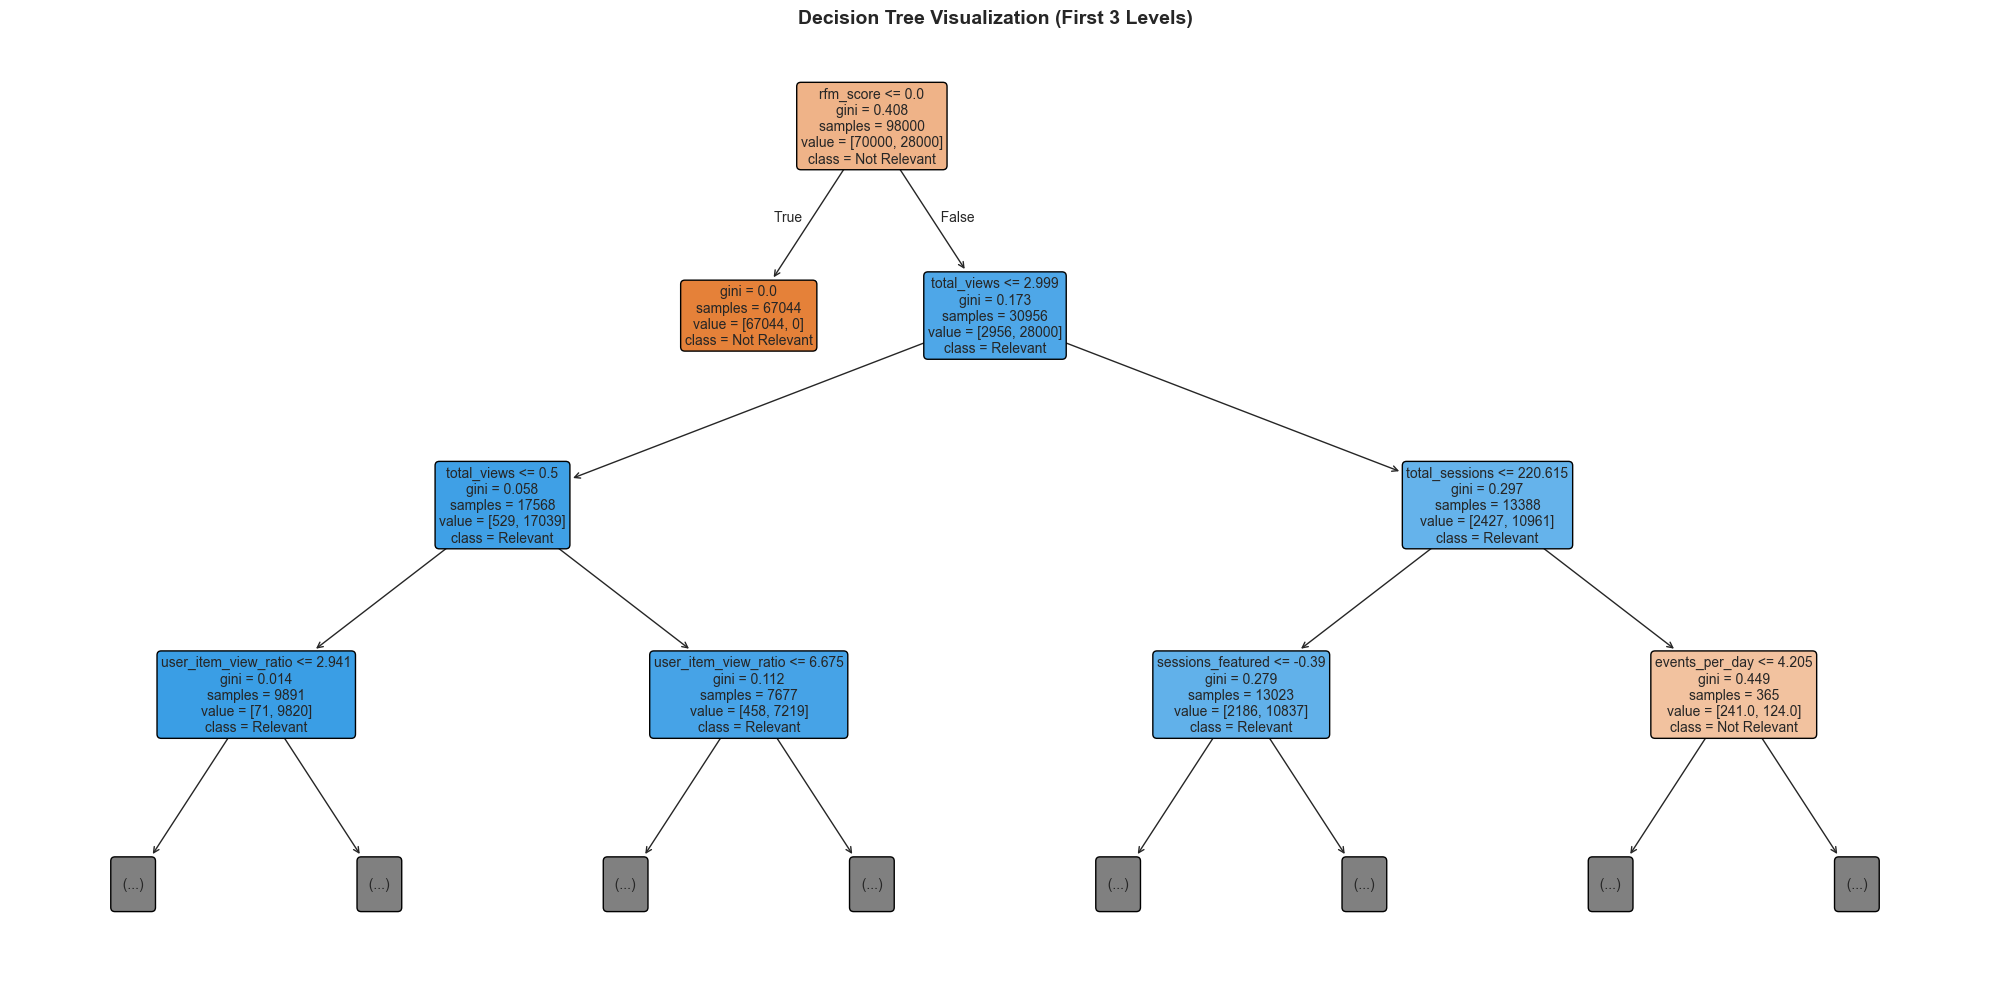


3. RANDOM FOREST
Performing hyperparameter tuning for Random Forest...
Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 15, 'class_weight': None}
Best CV score: 0.9540

Random Forest Performance:
------------------------------
Training Set:
  Accuracy:  0.9765
  F1-Score:  0.9603
  Precision: 0.9270
  Recall:    0.9962
  AUC-ROC:   0.9982

Validation Set:
  Accuracy:  0.8301
  F1-Score:  0.3007
  Precision: 0.7398
  Recall:    0.1887
  AUC-ROC:   0.5863

Top 10 Feature Importance (Random Forest):
                 Feature  Importance
0              rfm_score    0.590428
1     avg_session_events    0.100252
5            total_views    0.066830
4           total_events    0.065707
3        frequency_score    0.056445
2         events_per_day    0.052170
11        total_sessions    0.020707
6   user_item_view_ratio    0.018058
7             view_count    0.006803
8      sessions_featured    0.006459

4. GRADIENT BOO

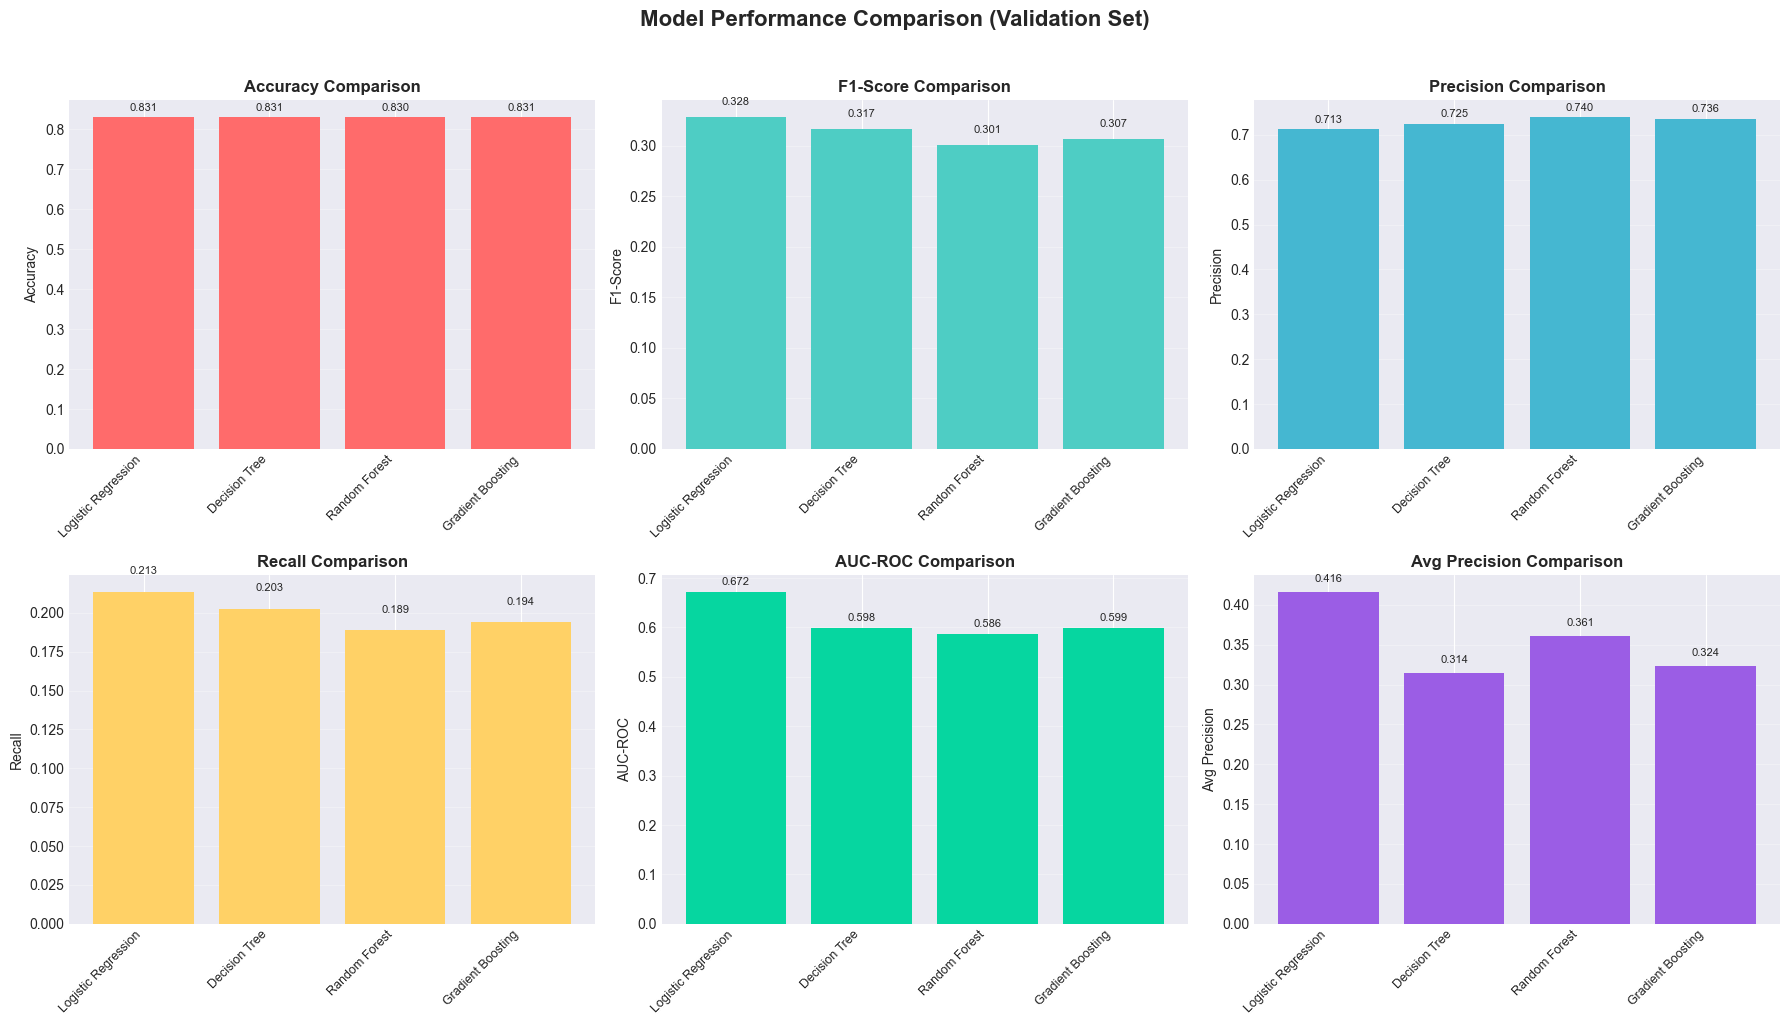


✅ BEST MODEL: Logistic Regression
   F1-Score: 0.3284
   AUC-ROC: 0.6717
   Accuracy: 0.8311
✓ Best classical model saved to 'best_classical_model.joblib'



In [17]:
# Cell 13: Train Classical ML Models with Hyperparameter Tuning
print("\n" + "=" * 60)
print("CLASSICAL ML MODELS WITH HYPERPARAMETER TUNING")
print("=" * 60)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           f1_score, precision_score, recall_score, roc_auc_score, 
                           roc_curve, auc, precision_recall_curve, average_precision_score)

# Convert to numpy arrays for faster computation
X_train_np = X_train.values
X_val_np = X_val.values
X_test_np = X_test.values
y_train_np = y_train.values
y_val_np = y_val.values
y_test_np = y_test.values

print(f"Training data: {X_train_np.shape}")
print(f"Validation data: {X_val_np.shape}")
print(f"Test data: {X_test_np.shape}")

# 1. Logistic Regression
print("\n" + "=" * 40)
print("1. LOGISTIC REGRESSION")
print("=" * 40)

from sklearn.linear_model import LogisticRegression

# Hyperparameter tuning for Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced'],
    'max_iter': [1000]
}

print("Performing hyperparameter tuning for Logistic Regression...")
lr_grid = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid_lr,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=0
)

lr_grid.fit(X_train_np, y_train_np)

print(f"Best parameters: {lr_grid.best_params_}")
print(f"Best CV score: {lr_grid.best_score_:.4f}")

# Train with best parameters
lr_model = lr_grid.best_estimator_
lr_model.fit(X_train_np, y_train_np)

# Predictions
y_pred_lr_train = lr_model.predict(X_train_np)
y_pred_lr_val = lr_model.predict(X_val_np)
y_prob_lr_train = lr_model.predict_proba(X_train_np)[:, 1]
y_prob_lr_val = lr_model.predict_proba(X_val_np)[:, 1]

print("\nLogistic Regression Performance:")
print("-" * 30)
print("Training Set:")
print(f"  Accuracy:  {accuracy_score(y_train_np, y_pred_lr_train):.4f}")
print(f"  F1-Score:  {f1_score(y_train_np, y_pred_lr_train):.4f}")
print(f"  Precision: {precision_score(y_train_np, y_pred_lr_train):.4f}")
print(f"  Recall:    {recall_score(y_train_np, y_pred_lr_train):.4f}")
print(f"  AUC-ROC:   {roc_auc_score(y_train_np, y_prob_lr_train):.4f}")

print("\nValidation Set:")
print(f"  Accuracy:  {accuracy_score(y_val_np, y_pred_lr_val):.4f}")
print(f"  F1-Score:  {f1_score(y_val_np, y_pred_lr_val):.4f}")
print(f"  Precision: {precision_score(y_val_np, y_pred_lr_val):.4f}")
print(f"  Recall:    {recall_score(y_val_np, y_pred_lr_val):.4f}")
print(f"  AUC-ROC:   {roc_auc_score(y_val_np, y_prob_lr_val):.4f}")

# 2. Decision Tree
print("\n" + "=" * 40)
print("2. DECISION TREE")
print("=" * 40)

from sklearn.tree import DecisionTreeClassifier

# Hyperparameter tuning for Decision Tree
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

print("Performing hyperparameter tuning for Decision Tree...")
dt_grid = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt,
    n_iter=20,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

dt_grid.fit(X_train_np, y_train_np)

print(f"Best parameters: {dt_grid.best_params_}")
print(f"Best CV score: {dt_grid.best_score_:.4f}")

# Train with best parameters
dt_model = dt_grid.best_estimator_
dt_model.fit(X_train_np, y_train_np)

# Predictions
y_pred_dt_train = dt_model.predict(X_train_np)
y_pred_dt_val = dt_model.predict(X_val_np)
y_prob_dt_train = dt_model.predict_proba(X_train_np)[:, 1]
y_prob_dt_val = dt_model.predict_proba(X_val_np)[:, 1]

print("\nDecision Tree Performance:")
print("-" * 30)
print("Training Set:")
print(f"  Accuracy:  {accuracy_score(y_train_np, y_pred_dt_train):.4f}")
print(f"  F1-Score:  {f1_score(y_train_np, y_pred_dt_train):.4f}")
print(f"  Precision: {precision_score(y_train_np, y_pred_dt_train):.4f}")
print(f"  Recall:    {recall_score(y_train_np, y_pred_dt_train):.4f}")
print(f"  AUC-ROC:   {roc_auc_score(y_train_np, y_prob_dt_train):.4f}")

print("\nValidation Set:")
print(f"  Accuracy:  {accuracy_score(y_val_np, y_pred_dt_val):.4f}")
print(f"  F1-Score:  {f1_score(y_val_np, y_pred_dt_val):.4f}")
print(f"  Precision: {precision_score(y_val_np, y_pred_dt_val):.4f}")
print(f"  Recall:    {recall_score(y_val_np, y_pred_dt_val):.4f}")
print(f"  AUC-ROC:   {roc_auc_score(y_val_np, y_prob_dt_val):.4f}")

# Visualize the decision tree
print("\nVisualizing Decision Tree...")
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=feature_cols, class_names=['Not Relevant', 'Relevant'], 
          filled=True, rounded=True, fontsize=10, max_depth=3)
plt.title("Decision Tree Visualization (First 3 Levels)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 3. Random Forest
print("\n" + "=" * 40)
print("3. RANDOM FOREST")
print("=" * 40)

from sklearn.ensemble import RandomForestClassifier

# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

print("Performing hyperparameter tuning for Random Forest...")
rf_grid = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_rf,
    n_iter=15,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

rf_grid.fit(X_train_np, y_train_np)

print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best CV score: {rf_grid.best_score_:.4f}")

# Train with best parameters
rf_model = rf_grid.best_estimator_
rf_model.fit(X_train_np, y_train_np)

# Predictions
y_pred_rf_train = rf_model.predict(X_train_np)
y_pred_rf_val = rf_model.predict(X_val_np)
y_prob_rf_train = rf_model.predict_proba(X_train_np)[:, 1]
y_prob_rf_val = rf_model.predict_proba(X_val_np)[:, 1]

print("\nRandom Forest Performance:")
print("-" * 30)
print("Training Set:")
print(f"  Accuracy:  {accuracy_score(y_train_np, y_pred_rf_train):.4f}")
print(f"  F1-Score:  {f1_score(y_train_np, y_pred_rf_train):.4f}")
print(f"  Precision: {precision_score(y_train_np, y_pred_rf_train):.4f}")
print(f"  Recall:    {recall_score(y_train_np, y_pred_rf_train):.4f}")
print(f"  AUC-ROC:   {roc_auc_score(y_train_np, y_prob_rf_train):.4f}")

print("\nValidation Set:")
print(f"  Accuracy:  {accuracy_score(y_val_np, y_pred_rf_val):.4f}")
print(f"  F1-Score:  {f1_score(y_val_np, y_pred_rf_val):.4f}")
print(f"  Precision: {precision_score(y_val_np, y_pred_rf_val):.4f}")
print(f"  Recall:    {recall_score(y_val_np, y_pred_rf_val):.4f}")
print(f"  AUC-ROC:   {roc_auc_score(y_val_np, y_prob_rf_val):.4f}")

# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Feature Importance (Random Forest):")
print(feature_importance.head(10))

# 4. Gradient Boosting
print("\n" + "=" * 40)
print("4. GRADIENT BOOSTING")
print("=" * 40)

from sklearn.ensemble import GradientBoostingClassifier

# Hyperparameter tuning for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

print("Performing hyperparameter tuning for Gradient Boosting...")
gb_grid = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_gb,
    n_iter=15,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

gb_grid.fit(X_train_np, y_train_np)

print(f"Best parameters: {gb_grid.best_params_}")
print(f"Best CV score: {gb_grid.best_score_:.4f}")

# Train with best parameters
gb_model = gb_grid.best_estimator_
gb_model.fit(X_train_np, y_train_np)

# Predictions
y_pred_gb_train = gb_model.predict(X_train_np)
y_pred_gb_val = gb_model.predict(X_val_np)
y_prob_gb_train = gb_model.predict_proba(X_train_np)[:, 1]
y_prob_gb_val = gb_model.predict_proba(X_val_np)[:, 1]

print("\nGradient Boosting Performance:")
print("-" * 30)
print("Training Set:")
print(f"  Accuracy:  {accuracy_score(y_train_np, y_pred_gb_train):.4f}")
print(f"  F1-Score:  {f1_score(y_train_np, y_pred_gb_train):.4f}")
print(f"  Precision: {precision_score(y_train_np, y_pred_gb_train):.4f}")
print(f"  Recall:    {recall_score(y_train_np, y_pred_gb_train):.4f}")
print(f"  AUC-ROC:   {roc_auc_score(y_train_np, y_prob_gb_train):.4f}")

print("\nValidation Set:")
print(f"  Accuracy:  {accuracy_score(y_val_np, y_pred_gb_val):.4f}")
print(f"  F1-Score:  {f1_score(y_val_np, y_pred_gb_val):.4f}")
print(f"  Precision: {precision_score(y_val_np, y_pred_gb_val):.4f}")
print(f"  Recall:    {recall_score(y_val_np, y_pred_gb_val):.4f}")
print(f"  AUC-ROC:   {roc_auc_score(y_val_np, y_prob_gb_val):.4f}")

# 5. Model Comparison
print("\n" + "=" * 40)
print("5. MODEL COMPARISON")
print("=" * 40)

# Collect all models and their validation performances
models = {
    'Logistic Regression': lr_model,
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model
}

# Create comparison DataFrame
comparison_data = []

for name, model in models.items():
    # Get predictions
    if name == 'Logistic Regression':
        y_pred = y_pred_lr_val
        y_prob = y_prob_lr_val
    elif name == 'Decision Tree':
        y_pred = y_pred_dt_val
        y_prob = y_prob_dt_val
    elif name == 'Random Forest':
        y_pred = y_pred_rf_val
        y_prob = y_prob_rf_val
    elif name == 'Gradient Boosting':
        y_pred = y_pred_gb_val
        y_prob = y_prob_gb_val
    
    # Calculate metrics
    accuracy = accuracy_score(y_val_np, y_pred)
    f1 = f1_score(y_val_np, y_pred)
    precision = precision_score(y_val_np, y_pred)
    recall = recall_score(y_val_np, y_pred)
    auc_roc = roc_auc_score(y_val_np, y_prob)
    
    # Calculate average precision
    avg_precision = average_precision_score(y_val_np, y_prob)
    
    comparison_data.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'AUC-ROC': auc_roc,
        'Avg Precision': avg_precision
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Performance Comparison (Validation Set):")
print("="*70)
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
metrics_to_plot = ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'AUC-ROC', 'Avg Precision']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFD166', '#06D6A0', '#9B5DE5']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    bars = ax.bar(range(len(comparison_df)), comparison_df[metric], color=colors[idx])
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric, fontsize=10)
    ax.set_xticks(range(len(comparison_df)))
    ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.suptitle('Model Performance Comparison (Validation Set)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Select best model based on F1-Score
best_model_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_model = models[best_model_name]

print(f"\n✅ BEST MODEL: {best_model_name}")
print(f"   F1-Score: {comparison_df.loc[best_model_idx, 'F1-Score']:.4f}")
print(f"   AUC-ROC: {comparison_df.loc[best_model_idx, 'AUC-ROC']:.4f}")
print(f"   Accuracy: {comparison_df.loc[best_model_idx, 'Accuracy']:.4f}")

# Save the best classical model
import joblib
joblib.dump(best_model, 'best_classical_model.joblib')
print("✓ Best classical model saved to 'best_classical_model.joblib'")

print("\n" + "=" * 60)


NEURAL NETWORK WITH ADVANCED ARCHITECTURE
Neural Network Input Shape: 14 features

Class weights: {0: np.float64(0.7), 1: np.float64(1.75)}

Training different neural network architectures...

Training STANDARD architecture...


  Best validation AUC: 0.6602
  Best validation accuracy: 0.8330
  Training stopped at epoch: 16

Training DEEP architecture...


  Best validation AUC: 0.6681
  Best validation accuracy: 0.8314
  Training stopped at epoch: 18

Training WIDE architecture...


  Best validation AUC: 0.6729
  Best validation accuracy: 0.8323
  Training stopped at epoch: 28

NEURAL NETWORK ARCHITECTURE COMPARISON

Neural Network Architecture Comparison (Validation Set):
Architecture  Accuracy  F1-Score  Precision   Recall  AUC-ROC  Avg Precision  Trainable Params
    Standard  0.830703  0.344997   0.686779 0.230357 0.660690       0.413358             13185
        Deep  0.829435  0.335652   0.681860 0.222619 0.671140       0.424776             49025
        Wide  0.830588  0.313652   0.726486 0.200000 0.667346       0.425448            175617

✅ BEST NEURAL NETWORK: STANDARD Architecture
   F1-Score: 0.3450
   AUC-ROC: 0.6607
   Trainable Parameters: 13,185

Visualizing training history for STANDARD architecture...


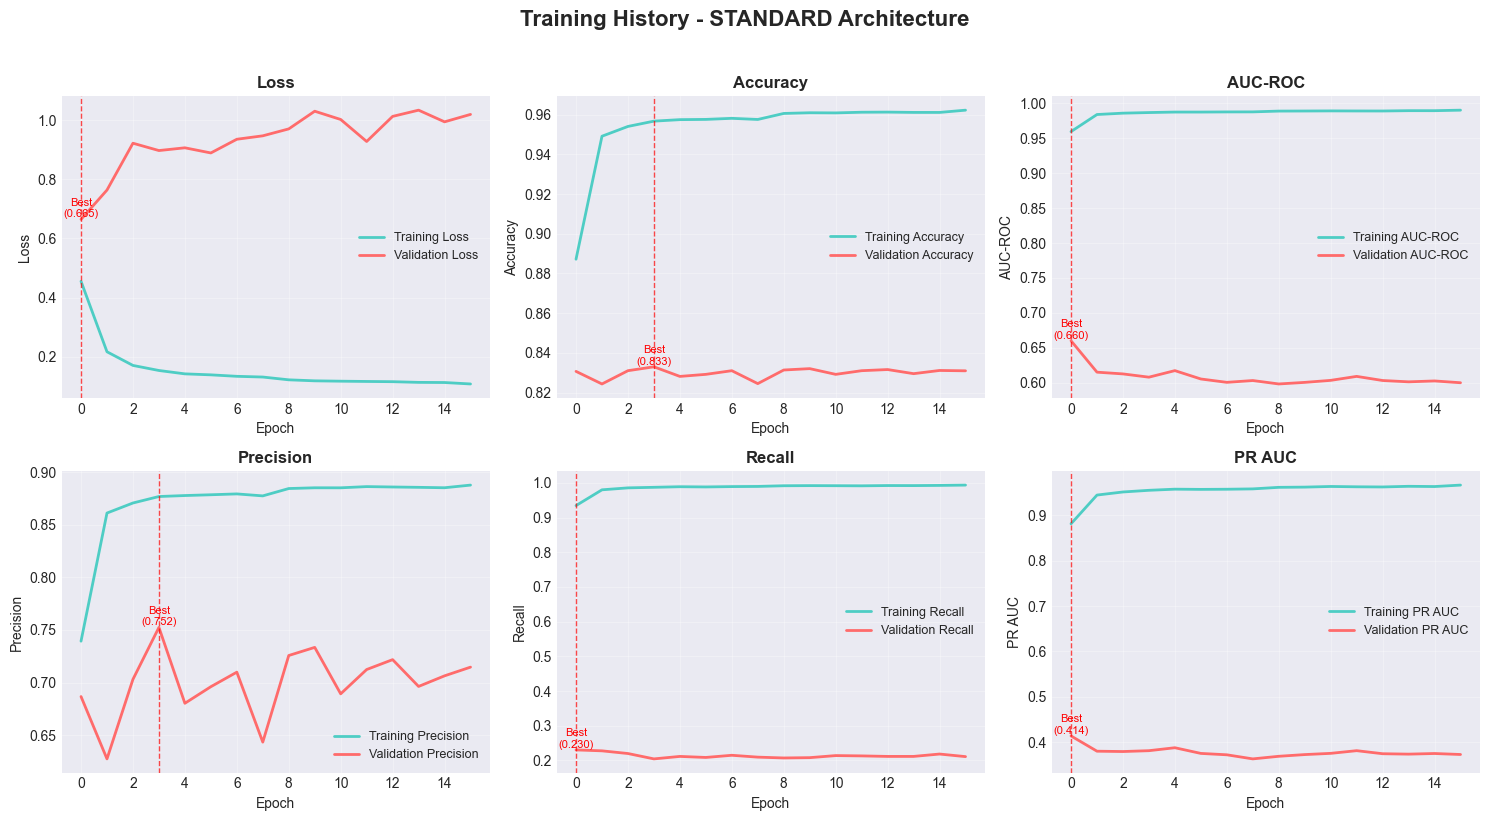


Visualizing neural network architecture...
You must install pydot (`pip install pydot`) for `plot_model` to work.


Could not visualize model architecture (graphviz may not be installed)
✓ Best neural network model saved to 'best_neural_network.h5'



In [18]:
# Cell 14: Neural Network with Advanced Architecture
print("\n" + "=" * 60)
print("NEURAL NETWORK WITH ADVANCED ARCHITECTURE")
print("=" * 60)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Convert data to float32 for TensorFlow
X_train_nn = X_train_np.astype('float32')
X_val_nn = X_val_np.astype('float32')
X_test_nn = X_test_np.astype('float32')
y_train_nn = y_train_np.astype('float32')
y_val_nn = y_val_np.astype('float32')
y_test_nn = y_test_np.astype('float32')

print(f"Neural Network Input Shape: {X_train_nn.shape[1]} features")

# Calculate class weights for imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"\nClass weights: {class_weight_dict}")

# Build advanced neural network with multiple architecture options
def build_advanced_nn(input_shape, architecture='standard'):
    """
    Build neural network with different architecture options
    """
    model = keras.Sequential()
    
    if architecture == 'standard':
        # Standard architecture
        model.add(layers.Dense(128, activation='relu', input_shape=(input_shape,),
                              kernel_initializer=HeNormal(),
                              kernel_regularizer=regularizers.l2(0.001)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.3))
        
        model.add(layers.Dense(64, activation='relu',
                              kernel_initializer=HeNormal(),
                              kernel_regularizer=regularizers.l2(0.001)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.3))
        
        model.add(layers.Dense(32, activation='relu',
                              kernel_initializer=HeNormal()))
        model.add(layers.BatchNormalization())
        
    elif architecture == 'deep':
        # Deeper architecture
        model.add(layers.Dense(256, activation='relu', input_shape=(input_shape,),
                              kernel_initializer=HeNormal(),
                              kernel_regularizer=regularizers.l2(0.001)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.4))
        
        model.add(layers.Dense(128, activation='relu',
                              kernel_initializer=HeNormal(),
                              kernel_regularizer=regularizers.l2(0.001)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.4))
        
        model.add(layers.Dense(64, activation='relu',
                              kernel_initializer=HeNormal(),
                              kernel_regularizer=regularizers.l2(0.001)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.3))
        
        model.add(layers.Dense(32, activation='relu',
                              kernel_initializer=HeNormal()))
        model.add(layers.BatchNormalization())
        
    elif architecture == 'wide':
        # Wide architecture
        model.add(layers.Dense(512, activation='relu', input_shape=(input_shape,),
                              kernel_initializer=HeNormal(),
                              kernel_regularizer=regularizers.l2(0.001)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.5))
        
        model.add(layers.Dense(256, activation='relu',
                              kernel_initializer=HeNormal(),
                              kernel_regularizer=regularizers.l2(0.001)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.5))
        
        model.add(layers.Dense(128, activation='relu',
                              kernel_initializer=HeNormal()))
        model.add(layers.BatchNormalization())
    
    # Output layer (same for all architectures)
    model.add(layers.Dense(1, activation='sigmoid',
                          kernel_initializer=GlorotUniform()))
    
    return model

# Try different architectures
architectures = ['standard', 'deep', 'wide']
history_dict = {}
models_dict = {}

print("\nTraining different neural network architectures...")
print("=" * 50)

for arch in architectures:
    print(f"\nTraining {arch.upper()} architecture...")
    
    # Build model
    model = build_advanced_nn(X_train_nn.shape[1], architecture=arch)
    
    # Compile with different optimizers based on architecture
    if arch == 'deep':
        optimizer = Adam(learning_rate=0.0005)
    elif arch == 'wide':
        optimizer = RMSprop(learning_rate=0.0001)
    else:
        optimizer = Adam(learning_rate=0.001)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.AUC(name='auc'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='pr_auc', curve='PR')  # Precision-Recall AUC
        ]
    )
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=0
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-6,
            verbose=0
        ),
        ModelCheckpoint(
            f'best_nn_{arch}.h5',
            monitor='val_auc',
            save_best_only=True,
            mode='max',
            verbose=0
        ),
        TensorBoard(
            log_dir=f'./logs/{arch}',
            histogram_freq=1,
            write_graph=True,
            write_images=False
        )
    ]
    
    # Train model
    history = model.fit(
        X_train_nn, y_train_nn,
        validation_data=(X_val_nn, y_val_nn),
        epochs=100,
        batch_size=64,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=0
    )
    
    # Store model and history
    models_dict[arch] = model
    history_dict[arch] = history.history
    
    # Evaluate
    print(f"  Best validation AUC: {max(history.history['val_auc']):.4f}")
    print(f"  Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
    print(f"  Training stopped at epoch: {len(history.history['loss'])}")

# Compare architectures
print("\n" + "=" * 50)
print("NEURAL NETWORK ARCHITECTURE COMPARISON")
print("=" * 50)

nn_comparison = []

for arch in architectures:
    model = models_dict[arch]
    
    # Evaluate on validation set
    val_results = model.evaluate(X_val_nn, y_val_nn, verbose=0)
    
    # Get predictions
    y_pred_nn = (model.predict(X_val_nn, verbose=0) > 0.5).astype(int).flatten()
    y_prob_nn = model.predict(X_val_nn, verbose=0).flatten()
    
    # Calculate metrics
    accuracy = accuracy_score(y_val_np, y_pred_nn)
    f1 = f1_score(y_val_np, y_pred_nn)
    precision = precision_score(y_val_np, y_pred_nn)
    recall = recall_score(y_val_np, y_pred_nn)
    auc_roc = roc_auc_score(y_val_np, y_prob_nn)
    avg_precision = average_precision_score(y_val_np, y_prob_nn)
    
    nn_comparison.append({
        'Architecture': arch.capitalize(),
        'Accuracy': accuracy,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'AUC-ROC': auc_roc,
        'Avg Precision': avg_precision,
        'Trainable Params': model.count_params()
    })

nn_comparison_df = pd.DataFrame(nn_comparison)
print("\nNeural Network Architecture Comparison (Validation Set):")
print("="*70)
print(nn_comparison_df.to_string(index=False))

# Select best neural network architecture
best_nn_idx = nn_comparison_df['F1-Score'].idxmax()
best_nn_arch = nn_comparison_df.loc[best_nn_idx, 'Architecture'].lower()
best_nn_model = models_dict[best_nn_arch]

print(f"\n✅ BEST NEURAL NETWORK: {best_nn_arch.upper()} Architecture")
print(f"   F1-Score: {nn_comparison_df.loc[best_nn_idx, 'F1-Score']:.4f}")
print(f"   AUC-ROC: {nn_comparison_df.loc[best_nn_idx, 'AUC-ROC']:.4f}")
print(f"   Trainable Parameters: {nn_comparison_df.loc[best_nn_idx, 'Trainable Params']:,}")

# Visualize training history for best architecture
print(f"\nVisualizing training history for {best_nn_arch.upper()} architecture...")

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
history = history_dict[best_nn_arch]

metrics_to_plot = [
    ('loss', 'Loss'),
    ('accuracy', 'Accuracy'),
    ('auc', 'AUC-ROC'),
    ('precision', 'Precision'),
    ('recall', 'Recall'),
    ('pr_auc', 'PR AUC')
]

for idx, (metric, title) in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    if metric in history:
        ax.plot(history[metric], label=f'Training {title}', linewidth=2, color='#4ECDC4')
        ax.plot(history[f'val_{metric}'], label=f'Validation {title}', linewidth=2, color='#FF6B6B')
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('Epoch', fontsize=10)
        ax.set_ylabel(title, fontsize=10)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        
        # Mark best epoch
        best_epoch = np.argmin(history[f'val_{metric}']) if 'loss' in metric else np.argmax(history[f'val_{metric}'])
        best_value = history[f'val_{metric}'][best_epoch]
        ax.axvline(best_epoch, color='red', linestyle='--', alpha=0.7, linewidth=1)
        ax.text(best_epoch, best_value, f'Best\n({best_value:.3f})', 
                fontsize=8, ha='center', va='bottom', color='red')

plt.suptitle(f'Training History - {best_nn_arch.upper()} Architecture', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Model visualization
print("\nVisualizing neural network architecture...")
try:
    plot_model(best_nn_model, to_file='nn_architecture.png', 
               show_shapes=True, show_layer_names=True, dpi=100)
    
    # Display the image
    img = plt.imread('nn_architecture.png')
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Neural Network Architecture', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
except:
    print("Could not visualize model architecture (graphviz may not be installed)")

# Save the best neural network model
best_nn_model.save('best_neural_network.h5')
print("✓ Best neural network model saved to 'best_neural_network.h5'")

print("\n" + "=" * 60)


ENSEMBLE METHODS AND FINAL MODEL SELECTION

1. CREATING ENSEMBLE MODELS
----------------------------------------
Creating Voting Classifier (Hard Voting)...
Creating Voting Classifier (Soft Voting)...
Creating Stacking Classifier...

2. EVALUATING ENSEMBLE MODELS
----------------------------------------

Evaluating Voting (Hard)...

Evaluating Voting (Soft)...

Evaluating Stacking...

Evaluating Best Single (Random Forest)...

Evaluating Neural Network...

Ensemble Model Performance Comparison (Validation Set):
                      Model  Accuracy  F1-Score  Precision   Recall   AUC-ROC Avg Precision
              Voting (Hard)  0.830933  0.313450   0.732240 0.199405       N/A           N/A
              Voting (Soft)  0.831279  0.323088   0.722854 0.208036   0.58889       0.36703
                   Stacking  0.830645  0.306931   0.738095 0.193750  0.588661      0.363815
Best Single (Random Forest)  0.830127  0.300688   0.739790 0.188690  0.586261      0.360514
             Neural Ne

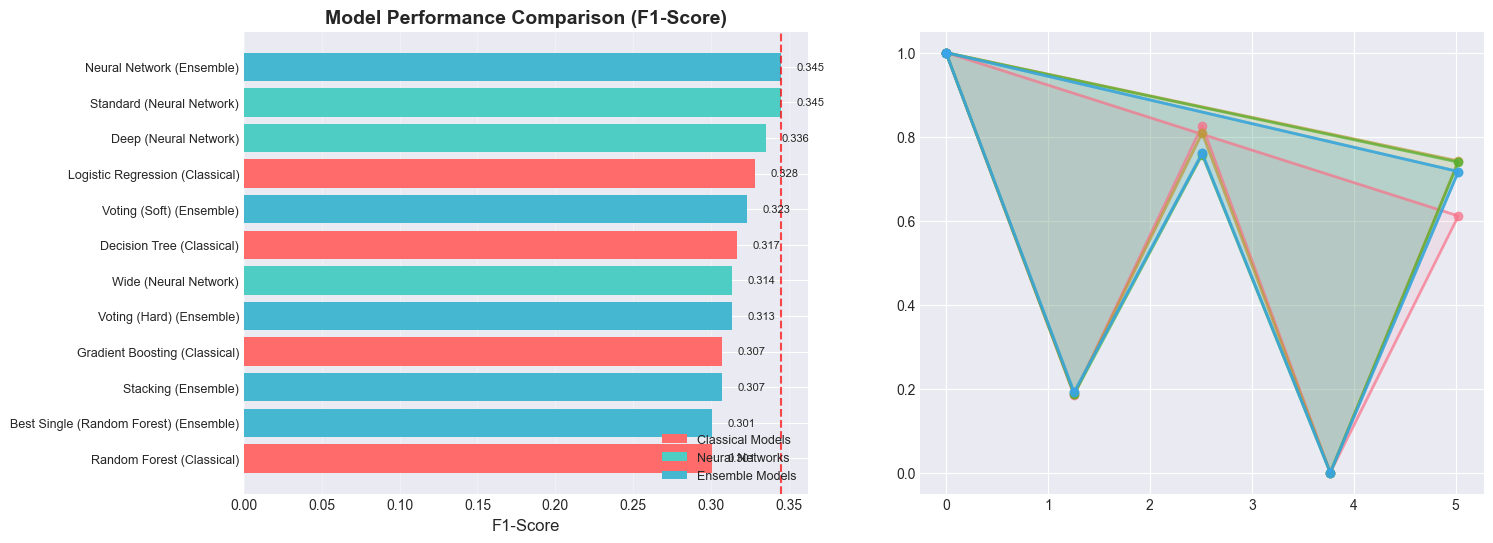

In [19]:
# Cell 15: Ensemble Methods and Final Model Selection
print("\n" + "=" * 60)
print("ENSEMBLE METHODS AND FINAL MODEL SELECTION")
print("=" * 60)

from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.calibration import CalibratedClassifierCV

# 1. Create Ensemble Models
print("\n1. CREATING ENSEMBLE MODELS")
print("-" * 40)

# Prepare base models for ensemble
base_models = [
    ('lr', lr_model),
    ('rf', rf_model),
    ('gb', gb_model)
]

# Voting Classifier (Hard Voting)
print("Creating Voting Classifier (Hard Voting)...")
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_hard.fit(X_train_np, y_train_np)

# Voting Classifier (Soft Voting)
print("Creating Voting Classifier (Soft Voting)...")
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_soft.fit(X_train_np, y_train_np)

# Stacking Classifier
print("Creating Stacking Classifier...")
stacking = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(random_state=42, class_weight='balanced'),
    cv=3,
    n_jobs=-1
)
stacking.fit(X_train_np, y_train_np)

# 2. Evaluate Ensemble Models
print("\n2. EVALUATING ENSEMBLE MODELS")
print("-" * 40)

ensemble_models = {
    'Voting (Hard)': voting_hard,
    'Voting (Soft)': voting_soft,
    'Stacking': stacking,
    'Best Single (Random Forest)': rf_model,
    'Neural Network': best_nn_model
}

ensemble_results = []

for name, model in ensemble_models.items():
    print(f"\nEvaluating {name}...")
    
    # Get predictions based on model type
    if name == 'Neural Network':
        y_pred = (model.predict(X_val_nn, verbose=0) > 0.5).astype(int).flatten()
        y_prob = model.predict(X_val_nn, verbose=0).flatten()
    else:
        y_pred = model.predict(X_val_np)
        
        # Get probabilities if available
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_val_np)[:, 1]
        else:
            y_prob = None
    
    # Calculate metrics
    accuracy = accuracy_score(y_val_np, y_pred)
    f1 = f1_score(y_val_np, y_pred)
    precision = precision_score(y_val_np, y_pred)
    recall = recall_score(y_val_np, y_pred)
    
    # Calculate AUC if probabilities available
    if y_prob is not None:
        auc_roc = roc_auc_score(y_val_np, y_prob)
        avg_precision = average_precision_score(y_val_np, y_prob)
    else:
        auc_roc = None
        avg_precision = None
    
    ensemble_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'AUC-ROC': auc_roc if auc_roc is not None else 'N/A',
        'Avg Precision': avg_precision if avg_precision is not None else 'N/A'
    })

ensemble_df = pd.DataFrame(ensemble_results)
print("\nEnsemble Model Performance Comparison (Validation Set):")
print("="*70)
print(ensemble_df.to_string(index=False))

# 3. Model Calibration (for probability-based models)
print("\n3. MODEL CALIBRATION")
print("-" * 40)

print("Calibrating Random Forest probabilities...")
calibrated_rf = CalibratedClassifierCV(rf_model, method='isotonic', cv=3)
calibrated_rf.fit(X_train_np, y_train_np)

# Evaluate calibrated model
y_prob_calibrated = calibrated_rf.predict_proba(X_val_np)[:, 1]
calibrated_auc = roc_auc_score(y_val_np, y_prob_calibrated)
calibrated_ap = average_precision_score(y_val_np, y_prob_calibrated)

print(f"Calibrated Random Forest AUC-ROC: {calibrated_auc:.4f}")
print(f"Calibrated Random Forest Avg Precision: {calibrated_ap:.4f}")

# 4. Select Final Model
print("\n4. FINAL MODEL SELECTION")
print("-" * 40)

# Combine all models for final comparison
all_models = pd.concat([
    comparison_df.rename(columns={'Model': 'Model_Type'}).assign(Type='Classical'),
    nn_comparison_df.rename(columns={'Architecture': 'Model_Type'}).assign(Type='Neural Network'),
    ensemble_df.rename(columns={'Model': 'Model_Type'}).assign(Type='Ensemble')
], ignore_index=True)

# Find best model based on F1-Score (excluding N/A values)
valid_models = all_models[all_models['F1-Score'].notna()]
best_overall_idx = valid_models['F1-Score'].idxmax()
best_overall_model = valid_models.loc[best_overall_idx]

print(f"\n✅ OVERALL BEST MODEL: {best_overall_model['Model_Type']} ({best_overall_model['Type']})")
print(f"   F1-Score: {best_overall_model['F1-Score']:.4f}")
print(f"   AUC-ROC: {best_overall_model['AUC-ROC']:.4f}")
print(f"   Accuracy: {best_overall_model['Accuracy']:.4f}")

# Visualize all model performances
print("\nVisualizing all model performances...")

# Prepare data for visualization
plot_data = valid_models.copy()
plot_data['Full_Name'] = plot_data['Model_Type'] + ' (' + plot_data['Type'] + ')'

# Sort by F1-Score
plot_data = plot_data.sort_values('F1-Score', ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart for F1-Scores
ax1 = axes[0]
bars = ax1.barh(range(len(plot_data)), plot_data['F1-Score'], 
                color=['#FF6B6B' if t == 'Classical' else '#4ECDC4' if t == 'Neural Network' else '#45B7D1' 
                      for t in plot_data['Type']])
ax1.set_yticks(range(len(plot_data)))
ax1.set_yticklabels(plot_data['Full_Name'], fontsize=9)
ax1.set_xlabel('F1-Score', fontsize=12)
ax1.set_title('Model Performance Comparison (F1-Score)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.axvline(plot_data['F1-Score'].max(), color='red', linestyle='--', alpha=0.7)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center', fontsize=8)

# Create legend for model types
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#FF6B6B', label='Classical Models'),
    Patch(facecolor='#4ECDC4', label='Neural Networks'),
    Patch(facecolor='#45B7D1', label='Ensemble Models')
]
ax1.legend(handles=legend_elements, loc='lower right', fontsize=9)

# Radar chart for top 5 models
ax2 = axes[1]
top_models = plot_data.tail(5).copy()

# Normalize metrics for radar chart
metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
if 'AUC-ROC' in top_models.columns and top_models['AUC-ROC'].notna().all():
    metrics.append('AUC-ROC')

# Prepare data for radar chart
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Close the polygon

# Plot each model
for idx, (_, row) in enumerate(top_models.iterrows()):
    values = [row[m] for m in metrics]
    values += values[:1]  # Close the polygon
    
    # Normalize to 0-1 scale for better visualization
    values_normalized = [(v - min(values)) / (max(values) - min(values)) if max(values) > min(values) else 0.5 
                        for v in values]
    
    ax2.plot(angles, values_normalized, 'o-', linewidth=2, 
             label=row['Model_Type'], alpha=0.7)
    ax2.fill(angles, values_normalized, alpha=0.1)


COMPREHENSIVE MODEL EVALUATION ON TEST SET
Error loading final model: name 'os' is not defined
Using Random Forest as default final model...

1. MAKING PREDICTIONS ON TEST SET
----------------------------------------
Test set predictions completed.
Positive predictions: 273 (1.82%)
Actual positives: 1,030 (6.85%)

2. COMPREHENSIVE EVALUATION METRICS
----------------------------------------

Test Set Performance:
Accuracy:          0.9294
F1-Score:          0.1857
Precision:         0.4432
Recall:            0.1175
AUC-ROC:           0.5435
Average Precision: 0.1435

3. DETAILED CLASSIFICATION REPORT
----------------------------------------

Classification Report:
              precision    recall  f1-score   support

Not Relevant       0.94      0.99      0.96     14000
    Relevant       0.44      0.12      0.19      1030

    accuracy                           0.93     15030
   macro avg       0.69      0.55      0.57     15030
weighted avg       0.90      0.93      0.91     15030



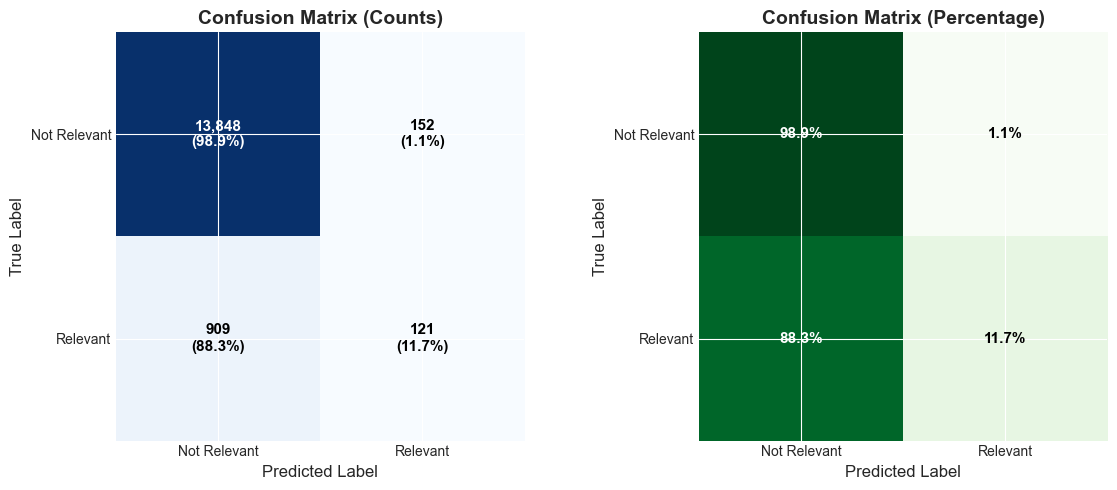


Confusion Matrix Analysis:
True Negatives (TN):  13,848 - Correctly predicted as not relevant
False Positives (FP): 152 - Incorrectly predicted as relevant
False Negatives (FN): 909 - Incorrectly predicted as not relevant
True Positives (TP):  121 - Correctly predicted as relevant

Derived Metrics:
Specificity (TN / (TN + FP)): 0.989 - Ability to identify non-relevant items
False Positive Rate (FP / (FP + TN)): 0.011
False Negative Rate (FN / (FN + TP)): 0.883
Positive Predictive Value (TP / (TP + FP)): 0.443
Negative Predictive Value (TN / (TN + FN)): 0.938

5. ROC AND PRECISION-RECALL CURVES
----------------------------------------


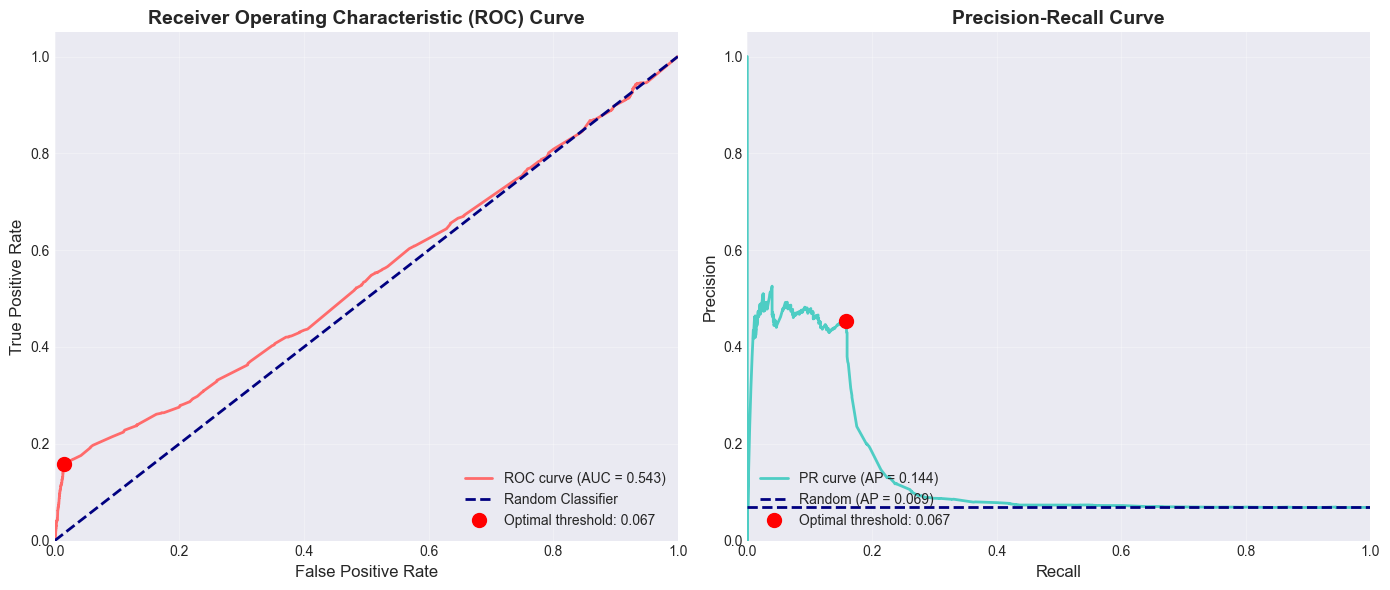


Optimal Thresholds:
  ROC (Youden's J): 0.067
  PR (Max F1):      0.067

Performance with Different Thresholds:
----------------------------------------
 Threshold  Accuracy  F1-Score  Precision   Recall  Positives
       0.3  0.928809  0.210914   0.438650 0.138835        326
       0.4  0.928743  0.200149   0.433657 0.130097        309
       0.5  0.929408  0.185725   0.443223 0.117476        273
       0.6  0.930206  0.178543   0.461538 0.110680        247
       0.7  0.931005  0.154849   0.482234 0.092233        197

6. BUSINESS IMPACT ANALYSIS
----------------------------------------
Assuming each recommendation has business value:
- True Positive: Customer buys recommended item (+$10 value)
- False Positive: Annoyed customer (-$2 value)
- False Negative: Missed opportunity (-$5 value)
- True Negative: No impact ($0 value)

Business Impact Analysis (Threshold = 0.5):
Total business value: $-3,639.00
Average value per prediction: $-0.24
Maximum possible value (all correct): $150,30

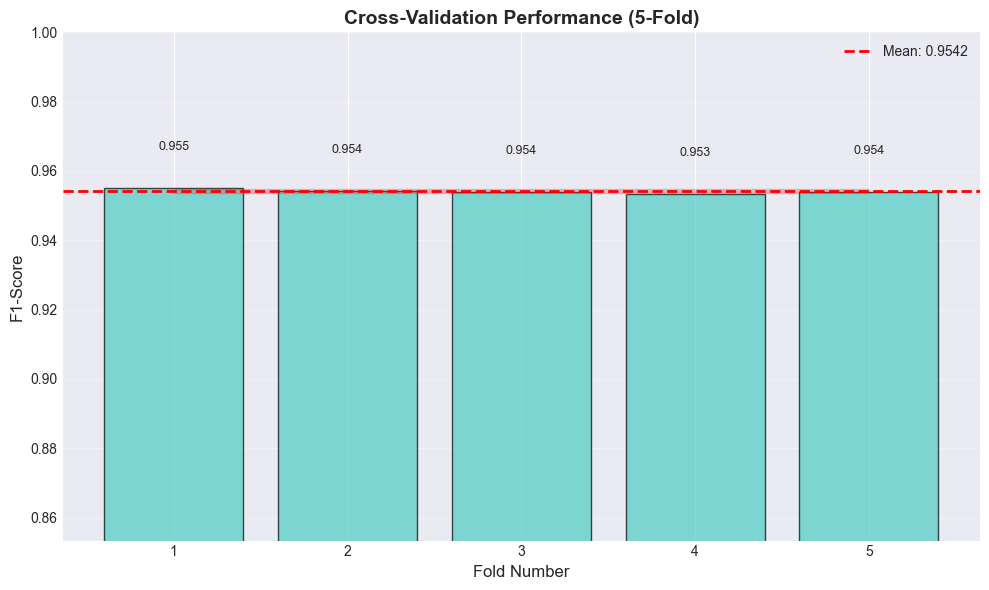

In [20]:
# Cell 16: Comprehensive Model Evaluation on Test Set
print("\n" + "=" * 60)
print("COMPREHENSIVE MODEL EVALUATION ON TEST SET")
print("=" * 60)

# Load the final model
try:
    # Try loading the final model (could be .joblib or .h5)
    if os.path.exists('final_model.joblib'):
        final_model = joblib.load('final_model.joblib')
        model_type = 'classical/ensemble'
    elif os.path.exists('final_model.h5'):
        final_model = keras.models.load_model('final_model.h5')
        model_type = 'neural_network'
    else:
        # Use the best overall model from our selection
        if best_overall_model['Type'] == 'Neural Network':
            final_model = best_nn_model
            model_type = 'neural_network'
        else:
            final_model = best_model  # Best classical model
            model_type = 'classical'
    
    print(f"Loaded final model: {best_overall_model['Model_Type']} ({model_type})")
    
except Exception as e:
    print(f"Error loading final model: {e}")
    print("Using Random Forest as default final model...")
    final_model = rf_model
    model_type = 'classical'

# 1. Test Set Predictions
print("\n1. MAKING PREDICTIONS ON TEST SET")
print("-" * 40)

# Make predictions based on model type
if model_type == 'neural_network':
    y_pred_test = (final_model.predict(X_test_nn, verbose=0) > 0.5).astype(int).flatten()
    y_prob_test = final_model.predict(X_test_nn, verbose=0).flatten()
else:
    y_pred_test = final_model.predict(X_test_np)
    
    # Get probabilities if available
    if hasattr(final_model, 'predict_proba'):
        y_prob_test = final_model.predict_proba(X_test_np)[:, 1]
    else:
        y_prob_test = None

print(f"Test set predictions completed.")
print(f"Positive predictions: {y_pred_test.sum():,} ({y_pred_test.mean():.2%})")
print(f"Actual positives: {y_test_np.sum():,} ({y_test_np.mean():.2%})")

# 2. Comprehensive Metrics
print("\n2. COMPREHENSIVE EVALUATION METRICS")
print("-" * 40)

# Calculate all metrics
test_accuracy = accuracy_score(y_test_np, y_pred_test)
test_f1 = f1_score(y_test_np, y_pred_test)
test_precision = precision_score(y_test_np, y_pred_test)
test_recall = recall_score(y_test_np, y_pred_test)

if y_prob_test is not None:
    test_auc_roc = roc_auc_score(y_test_np, y_prob_test)
    test_avg_precision = average_precision_score(y_test_np, y_prob_test)
else:
    test_auc_roc = None
    test_avg_precision = None

print("\nTest Set Performance:")
print("=" * 50)
print(f"Accuracy:          {test_accuracy:.4f}")
print(f"F1-Score:          {test_f1:.4f}")
print(f"Precision:         {test_precision:.4f}")
print(f"Recall:            {test_recall:.4f}")

if test_auc_roc is not None:
    print(f"AUC-ROC:           {test_auc_roc:.4f}")
    print(f"Average Precision: {test_avg_precision:.4f}")

# 3. Detailed Classification Report
print("\n3. DETAILED CLASSIFICATION REPORT")
print("-" * 40)

print("\nClassification Report:")
print(classification_report(y_test_np, y_pred_test, 
                          target_names=['Not Relevant', 'Relevant']))

# 4. Confusion Matrix
print("\n4. CONFUSION MATRIX")
print("-" * 40)

cm = confusion_matrix(y_test_np, y_pred_test)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot numerical confusion matrix
ax1 = axes[0]
im1 = ax1.imshow(cm, interpolation='nearest', cmap='Blues')
ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicted Label', fontsize=12)
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_xticklabels(['Not Relevant', 'Relevant'], fontsize=10)
ax1.set_yticklabels(['Not Relevant', 'Relevant'], fontsize=10)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax1.text(j, i, f'{cm[i, j]:,}\n({cm_percentage[i, j]:.1f}%)',
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=11, fontweight='bold')

# Plot percentage confusion matrix
ax2 = axes[1]
im2 = ax2.imshow(cm_percentage, interpolation='nearest', cmap='Greens')
ax2.set_title('Confusion Matrix (Percentage)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_ylabel('True Label', fontsize=12)
ax2.set_xticks([0, 1])
ax2.set_yticks([0, 1])
ax2.set_xticklabels(['Not Relevant', 'Relevant'], fontsize=10)
ax2.set_yticklabels(['Not Relevant', 'Relevant'], fontsize=10)

# Add text annotations for percentages
for i in range(cm_percentage.shape[0]):
    for j in range(cm_percentage.shape[1]):
        ax2.text(j, i, f'{cm_percentage[i, j]:.1f}%',
                ha="center", va="center",
                color="white" if cm_percentage[i, j] > 50 else "black",
                fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate and display key metrics from confusion matrix
TN, FP, FN, TP = cm.ravel()

print(f"\nConfusion Matrix Analysis:")
print(f"True Negatives (TN):  {TN:,} - Correctly predicted as not relevant")
print(f"False Positives (FP): {FP:,} - Incorrectly predicted as relevant")
print(f"False Negatives (FN): {FN:,} - Incorrectly predicted as not relevant")
print(f"True Positives (TP):  {TP:,} - Correctly predicted as relevant")

print(f"\nDerived Metrics:")
print(f"Specificity (TN / (TN + FP)): {TN/(TN+FP):.3f} - Ability to identify non-relevant items")
print(f"False Positive Rate (FP / (FP + TN)): {FP/(FP+TN):.3f}")
print(f"False Negative Rate (FN / (FN + TP)): {FN/(FN+TP):.3f}")
print(f"Positive Predictive Value (TP / (TP + FP)): {TP/(TP+FP):.3f}")
print(f"Negative Predictive Value (TN / (TN + FN)): {TN/(TN+FN):.3f}")

# 5. ROC Curve and Precision-Recall Curve
print("\n5. ROC AND PRECISION-RECALL CURVES")
print("-" * 40)

if y_prob_test is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # ROC Curve
    ax1 = axes[0]
    fpr, tpr, thresholds_roc = roc_curve(y_test_np, y_prob_test)
    roc_auc = auc(fpr, tpr)
    
    ax1.plot(fpr, tpr, color='#FF6B6B', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate', fontsize=12)
    ax1.set_ylabel('True Positive Rate', fontsize=12)
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
    ax1.legend(loc="lower right", fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Find optimal threshold (Youden's J statistic)
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    optimal_threshold = thresholds_roc[optimal_idx]
    ax1.plot(fpr[optimal_idx], tpr[optimal_idx], 'o', markersize=10, 
            color='red', label=f'Optimal threshold: {optimal_threshold:.3f}')
    ax1.legend(loc="lower right", fontsize=10)
    
    # Precision-Recall Curve
    ax2 = axes[1]
    precision, recall, thresholds_pr = precision_recall_curve(y_test_np, y_prob_test)
    avg_precision = average_precision_score(y_test_np, y_prob_test)
    
    # Plot precision-recall curve
    ax2.plot(recall, precision, color='#4ECDC4', lw=2, 
            label=f'PR curve (AP = {avg_precision:.3f})')
    
    # Add baseline (random classifier)
    baseline = len(y_test_np[y_test_np==1]) / len(y_test_np)
    ax2.axhline(y=baseline, color='navy', lw=2, linestyle='--', label=f'Random (AP = {baseline:.3f})')
    
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall', fontsize=12)
    ax2.set_ylabel('Precision', fontsize=12)
    ax2.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    ax2.legend(loc="lower left", fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Find optimal threshold (F1-score maximization)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    optimal_idx_pr = np.argmax(f1_scores)
    optimal_threshold_pr = thresholds_pr[optimal_idx_pr]
    ax2.plot(recall[optimal_idx_pr], precision[optimal_idx_pr], 'o', markersize=10, 
            color='red', label=f'Optimal threshold: {optimal_threshold_pr:.3f}')
    ax2.legend(loc="lower left", fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nOptimal Thresholds:")
    print(f"  ROC (Youden's J): {optimal_threshold:.3f}")
    print(f"  PR (Max F1):      {optimal_threshold_pr:.3f}")
    
    # Compare predictions with different thresholds
    print(f"\nPerformance with Different Thresholds:")
    print("-" * 40)
    
    thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7]
    threshold_results = []
    
    for threshold in thresholds_to_test:
        y_pred_thresh = (y_prob_test > threshold).astype(int)
        accuracy = accuracy_score(y_test_np, y_pred_thresh)
        f1 = f1_score(y_test_np, y_pred_thresh)
        precision_val = precision_score(y_test_np, y_pred_thresh)
        recall_val = recall_score(y_test_np, y_pred_thresh)
        
        threshold_results.append({
            'Threshold': threshold,
            'Accuracy': accuracy,
            'F1-Score': f1,
            'Precision': precision_val,
            'Recall': recall_val,
            'Positives': y_pred_thresh.sum()
        })
    
    threshold_df = pd.DataFrame(threshold_results)
    print(threshold_df.to_string(index=False))

# 6. Business Impact Analysis
print("\n6. BUSINESS IMPACT ANALYSIS")
print("-" * 40)

# Calculate potential business impact
print("Assuming each recommendation has business value:")
print("- True Positive: Customer buys recommended item (+$10 value)")
print("- False Positive: Annoyed customer (-$2 value)")
print("- False Negative: Missed opportunity (-$5 value)")
print("- True Negative: No impact ($0 value)")

# Calculate value with default threshold (0.5)
TP_value = 10
FP_cost = -2
FN_cost = -5
TN_value = 0

total_value = (TP * TP_value) + (FP * FP_cost) + (FN * FN_cost) + (TN * TN_value)
avg_value_per_prediction = total_value / len(y_test_np)

print(f"\nBusiness Impact Analysis (Threshold = 0.5):")
print(f"Total business value: ${total_value:,.2f}")
print(f"Average value per prediction: ${avg_value_per_prediction:.2f}")
print(f"Maximum possible value (all correct): ${len(y_test_np) * TP_value:,.2f}")
print(f"Percentage of maximum achieved: {total_value/(len(y_test_np)*TP_value)*100:.1f}%")

# Calculate value with optimal threshold
if y_prob_test is not None:
    y_pred_optimal = (y_prob_test > optimal_threshold).astype(int)
    cm_optimal = confusion_matrix(y_test_np, y_pred_optimal)
    TN_opt, FP_opt, FN_opt, TP_opt = cm_optimal.ravel()
    
    total_value_opt = (TP_opt * TP_value) + (FP_opt * FP_cost) + (FN_opt * FN_cost) + (TN_opt * TN_value)
    
    print(f"\nBusiness Impact with Optimal Threshold ({optimal_threshold:.3f}):")
    print(f"Total business value: ${total_value_opt:,.2f}")
    print(f"Improvement over default: ${total_value_opt - total_value:,.2f} ({((total_value_opt/total_value)-1)*100:.1f}%)")

# 7. Model Stability Analysis (using cross-validation)
print("\n7. MODEL STABILITY ANALYSIS")
print("-" * 40)

print("Performing cross-validation to assess model stability...")

# Use a simpler model for faster cross-validation if needed
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validate with F1 score
cv_scores = cross_val_score(final_model, X_train_np, y_train_np, 
                           cv=cv, scoring='f1', n_jobs=-1)

print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean F1 score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
print(f"Range: {cv_scores.min():.4f} - {cv_scores.max():.4f}")

# Visualize cross-validation results
fig, ax = plt.subplots(figsize=(10, 6))
fold_numbers = range(1, len(cv_scores) + 1)

bars = ax.bar(fold_numbers, cv_scores, color='#4ECDC4', alpha=0.7, edgecolor='black')
ax.axhline(y=cv_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cv_scores.mean():.4f}')
ax.fill_between(fold_numbers, cv_scores.mean() - cv_scores.std(), 
                cv_scores.mean() + cv_scores.std(), alpha=0.2, color='red')

ax.set_xlabel('Fold Number', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Cross-Validation Performance (5-Fold)', fontsize=14, fontweight='bold')
ax.set_xticks(fold_numbers)
ax.set_ylim([max(0, cv_scores.min() - 0.1), min(1, cv_scores.max() + 0.05)])
ax.grid(True, alpha=0.3, axis='y')
ax.legend(fontsize=10)

# Add value labels on bars
for bar, score in zip(bars, cv_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{score:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)


FEATURE IMPORTANCE AND MODEL INTERPRETATION

1. FEATURE IMPORTANCE ANALYSIS
----------------------------------------

Feature Importance (Gini):
              Feature  Importance  Importance_Normalized
            rfm_score    0.590428              59.042790
   avg_session_events    0.100252              10.025211
          total_views    0.066830               6.683002
         total_events    0.065707               6.570684
      frequency_score    0.056445               5.644528
       events_per_day    0.052170               5.216987
       total_sessions    0.020707               2.070731
 user_item_view_ratio    0.018058               1.805778
           view_count    0.006803               0.680313
    sessions_featured    0.006459               0.645907
view_popularity_score    0.006373               0.637299
       unique_viewers    0.005520               0.552045
days_since_last_event    0.002160               0.215984
        recency_score    0.002087               0.208741

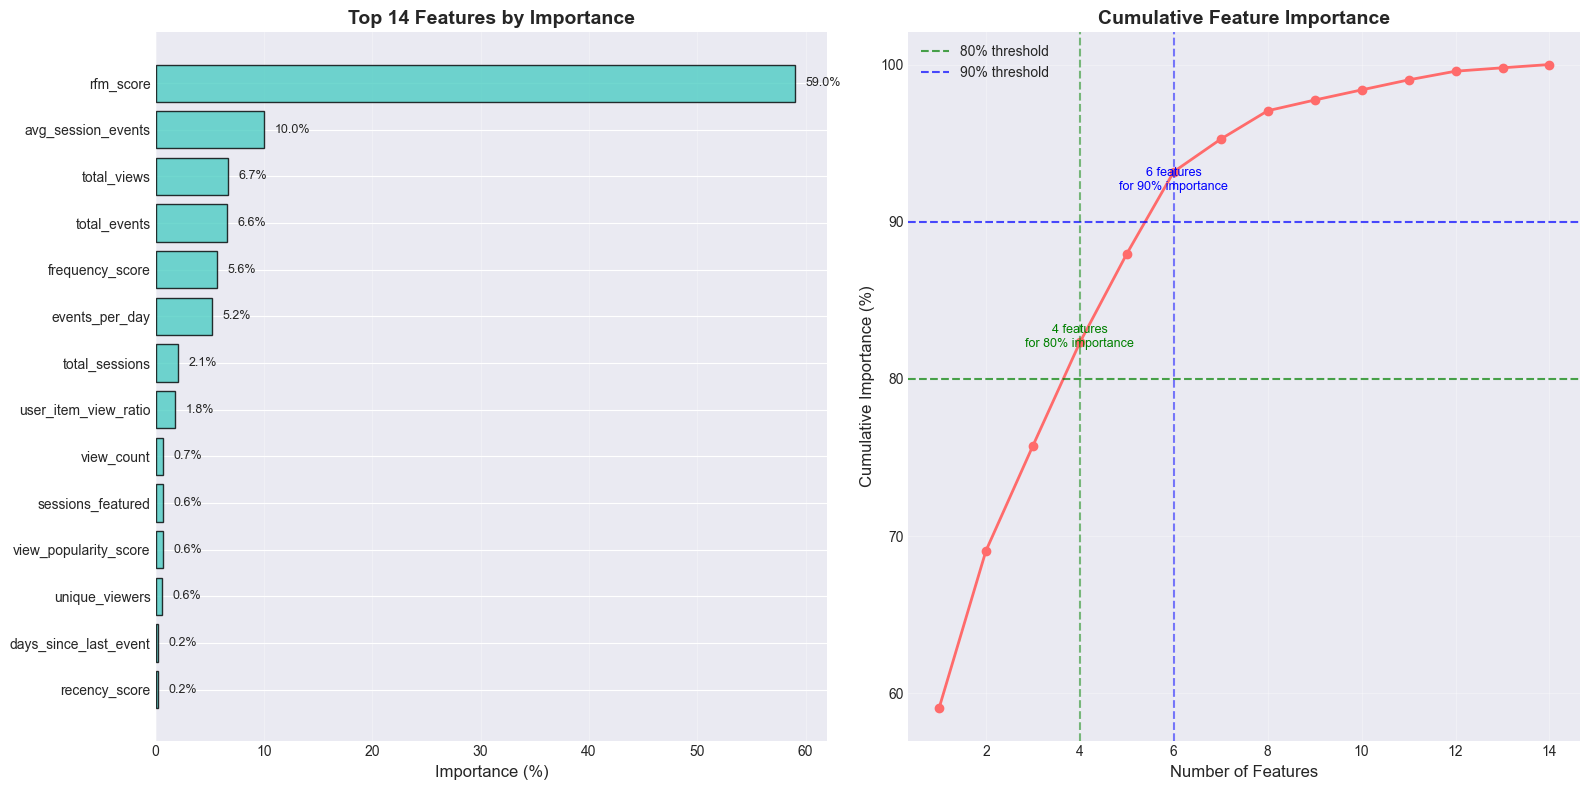


Feature Importance Insights:
- Top 3 features account for 93.2% of total importance
- Need 4 features to reach 80% cumulative importance
- Need 6 features to reach 90% cumulative importance

3. ADVANCED MODEL INTERPRETATION
----------------------------------------
Calculating SHAP values for model interpretation...
SHAP analysis failed: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).
Using alternative interpretation methods...

4. PARTIAL DEPENDENCE ANALYSIS
----------------------------------------


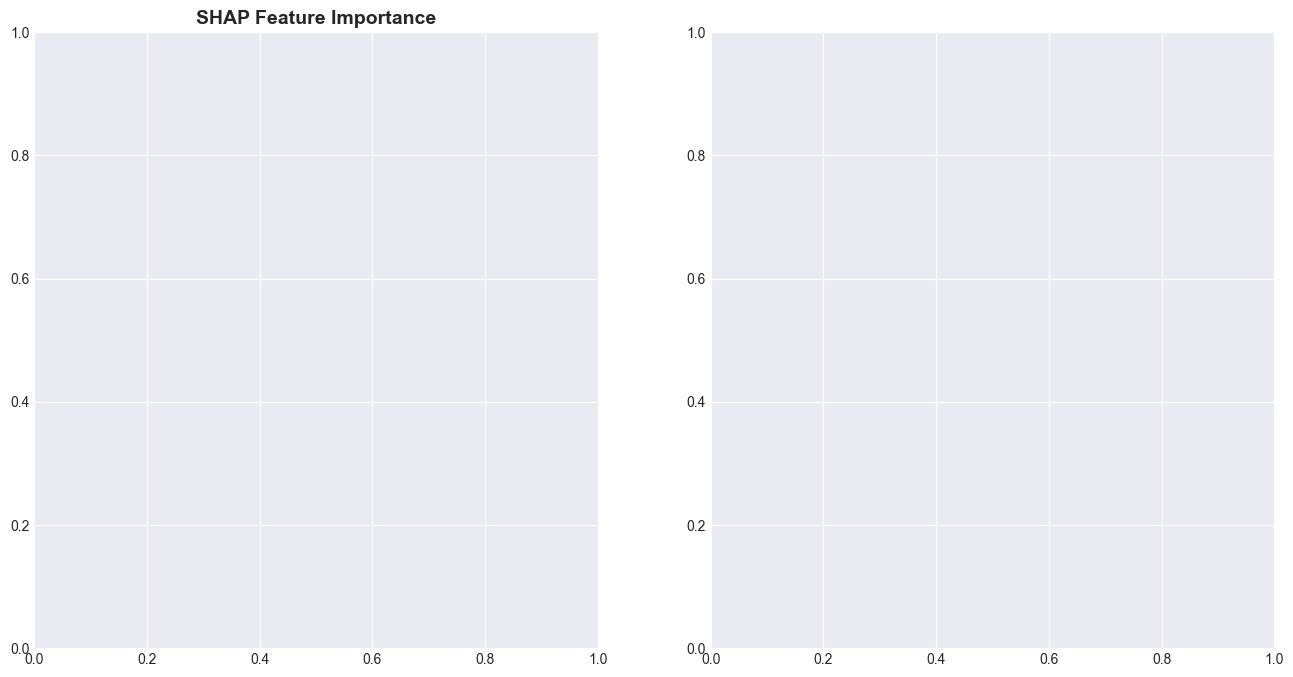

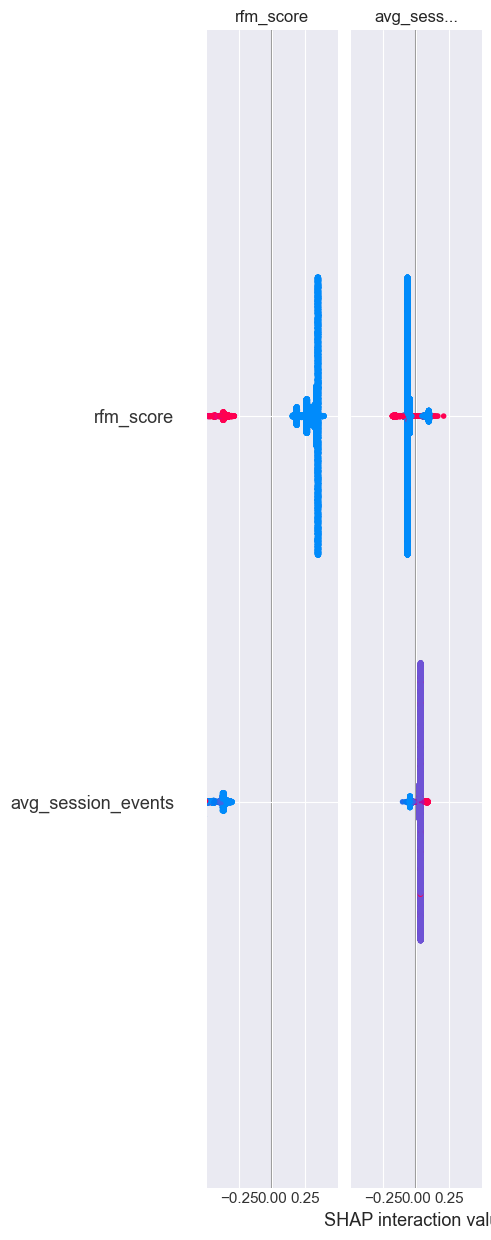

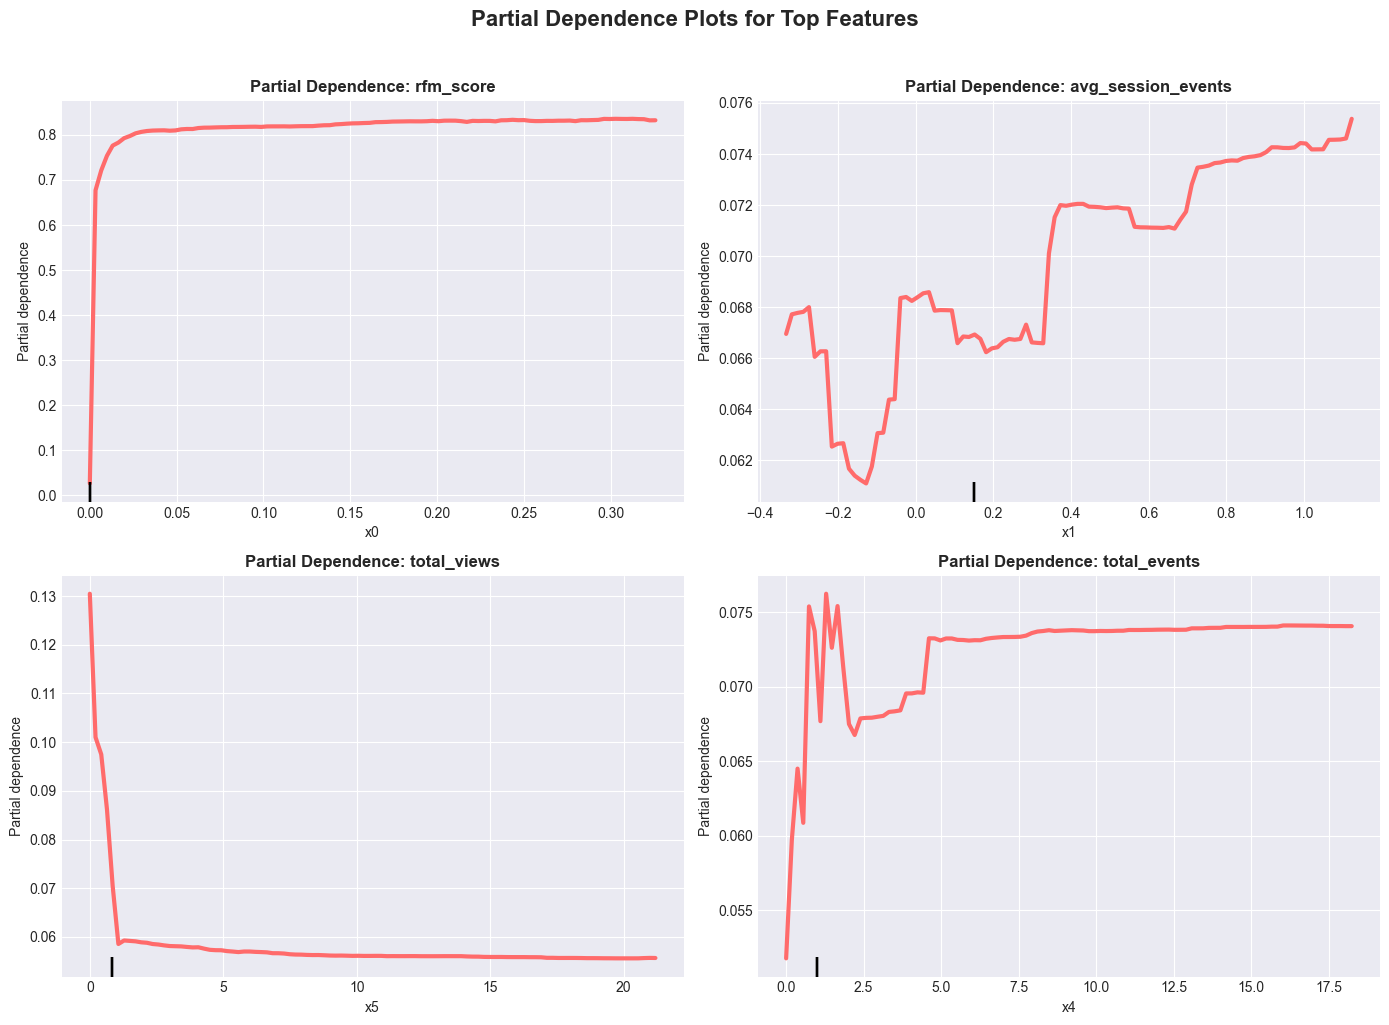


5. DECISION BOUNDARY ANALYSIS
----------------------------------------


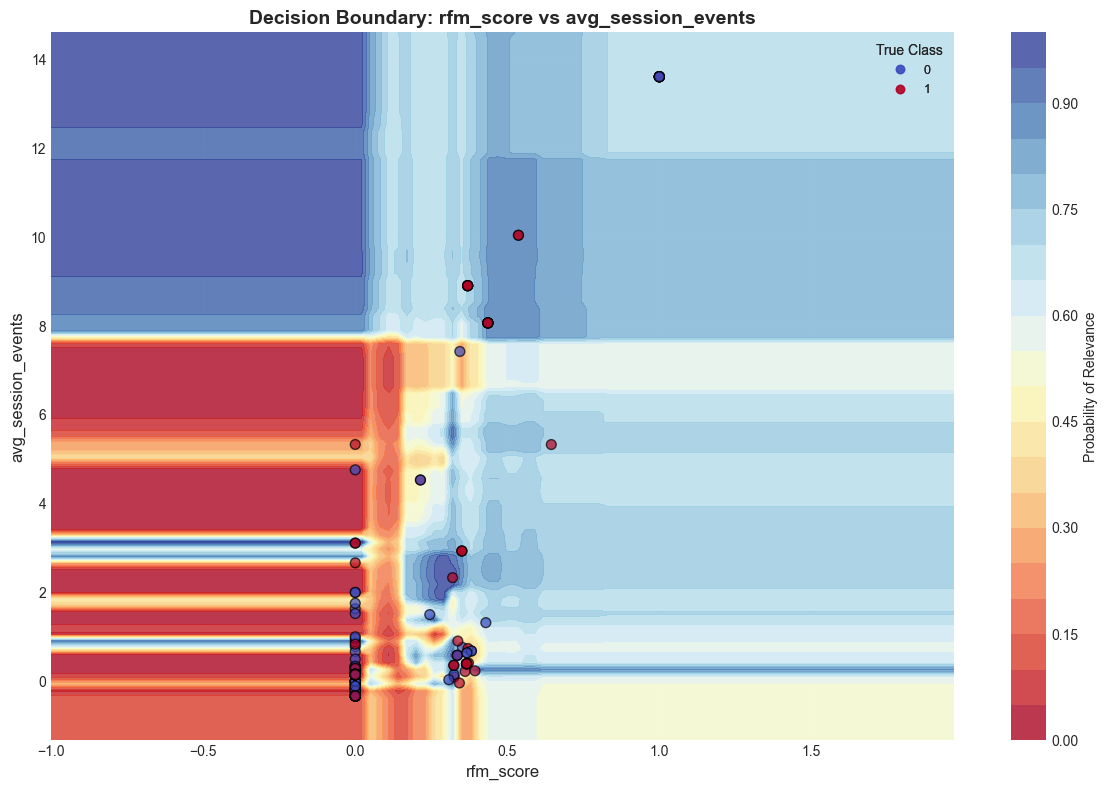


6. FEATURE INTERACTION ANALYSIS
----------------------------------------
Analyzing feature interactions...

Top Feature Interactions to Investigate:
  rfm_score & avg_session_events: correlation = 0.526
    ⚠ Moderate correlation detected (|corr| = 0.526)
    Consider creating interaction term: rfm_score * avg_session_events

  rfm_score & total_views: correlation = 0.762
    ⚠ Moderate correlation detected (|corr| = 0.762)
    Consider creating interaction term: rfm_score * total_views

  rfm_score & total_events: correlation = 0.768
    ⚠ Moderate correlation detected (|corr| = 0.768)
    Consider creating interaction term: rfm_score * total_events

  avg_session_events & total_views: correlation = 0.538
    ⚠ Moderate correlation detected (|corr| = 0.538)
    Consider creating interaction term: avg_session_events * total_views

  avg_session_events & total_events: correlation = 0.534
    ⚠ Moderate correlation detected (|corr| = 0.534)
    Consider creating interaction term: avg_se

In [24]:

# Cell 17: Feature Importance and Model Interpretation
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE AND MODEL INTERPRETATION")
print("=" * 60)

# 1. Feature Importance Analysis
print("\n1. FEATURE IMPORTANCE ANALYSIS")
print("-" * 40)

# Get feature importance based on model type
if hasattr(final_model, 'feature_importances_'):
    # Tree-based model
    importances = final_model.feature_importances_
    importance_type = "Feature Importance (Gini)"
    
elif hasattr(final_model, 'coef_'):
    # Linear model
    importances = np.abs(final_model.coef_[0])
    importance_type = "Feature Importance (Coefficient Magnitude)"
    
else:
    # For neural networks or other models, use permutation importance
    print("Calculating permutation importance...")
    from sklearn.inspection import permutation_importance
    
    try:
        result = permutation_importance(final_model, X_val_np, y_val_np, 
                                       n_repeats=10, random_state=42, n_jobs=-1)
        importances = result.importances_mean
        importance_type = "Feature Importance (Permutation)"
    except:
        # Fallback to correlation with target
        print("Using correlation with target as importance measure...")
        importances = []
        for i in range(X_train.shape[1]):
            corr = np.corrcoef(X_train.iloc[:, i], y_train)[0, 1]
            importances.append(abs(corr) if not np.isnan(corr) else 0)
        importances = np.array(importances)
        importance_type = "Feature Importance (Correlation)"

# Create feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances,
    'Importance_Normalized': importances / importances.sum() * 100
}).sort_values('Importance', ascending=False)

print(f"\n{importance_type}:")
print("=" * 60)
print(feature_importance_df.head(15).to_string(index=False))

# 2. Visualize Feature Importance
print("\n2. VISUALIZING FEATURE IMPORTANCE")
print("-" * 40)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Bar chart for top features
ax1 = axes[0]
top_n = min(15, len(feature_importance_df))
top_features = feature_importance_df.head(top_n)

bars = ax1.barh(range(len(top_features)), top_features['Importance_Normalized'], 
                color='#4ECDC4', alpha=0.8, edgecolor='black')
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['Feature'], fontsize=10)
ax1.invert_yaxis()
ax1.set_xlabel('Importance (%)', fontsize=12)
ax1.set_title(f'Top {top_n} Features by Importance', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width + 1, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}%', ha='left', va='center', fontsize=9)

# Cumulative importance plot
ax2 = axes[1]
cumulative_importance = np.cumsum(feature_importance_df['Importance_Normalized'])
features_needed_80 = np.argmax(cumulative_importance >= 80) + 1
features_needed_90 = np.argmax(cumulative_importance >= 90) + 1

ax2.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 
         marker='o', linewidth=2, color='#FF6B6B')
ax2.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='80% threshold')
ax2.axhline(y=90, color='blue', linestyle='--', alpha=0.7, label='90% threshold')
ax2.axvline(x=features_needed_80, color='green', linestyle='--', alpha=0.5)
ax2.axvline(x=features_needed_90, color='blue', linestyle='--', alpha=0.5)

ax2.set_xlabel('Number of Features', fontsize=12)
ax2.set_ylabel('Cumulative Importance (%)', fontsize=12)
ax2.set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)

# Add annotations
ax2.text(features_needed_80, 82, f'{features_needed_80} features\nfor 80% importance', 
         fontsize=9, ha='center', color='green')
ax2.text(features_needed_90, 92, f'{features_needed_90} features\nfor 90% importance', 
         fontsize=9, ha='center', color='blue')

plt.tight_layout()
plt.show()

print(f"\nFeature Importance Insights:")
print(f"- Top 3 features account for {cumulative_importance[2]:.1f}% of total importance")
print(f"- Need {features_needed_80} features to reach 80% cumulative importance")
print(f"- Need {features_needed_90} features to reach 90% cumulative importance")

# 3. SHAP Values for Model Interpretation (if available)
print("\n3. ADVANCED MODEL INTERPRETATION")
print("-" * 40)

try:
    import shap
    
    print("Calculating SHAP values for model interpretation...")
    
    # Create SHAP explainer based on model type
    if hasattr(final_model, 'predict_proba'):
        # Tree-based models
        explainer = shap.TreeExplainer(final_model)
        shap_values = explainer.shap_values(X_val_np)
        
    elif hasattr(final_model, 'coef_'):
        # Linear models
        explainer = shap.LinearExplainer(final_model, X_val_np)
        shap_values = explainer.shap_values(X_val_np)
        
    else:
        # Kernel SHAP for any model (slower but general)
        explainer = shap.KernelExplainer(final_model.predict, X_train_np[:100])  # Sample for speed
        shap_values = explainer.shap_values(X_val_np[:100])  # Limit for speed
    
    # Create SHAP summary plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Summary plot
    ax1 = axes[0]
    shap.summary_plot(shap_values, X_val_np, feature_names=feature_cols, 
                      show=False, max_display=15, plot_size=None)
    ax1.set_title('SHAP Feature Importance', fontsize=14, fontweight='bold')
    
    # Force plot for a single prediction
    ax2 = axes[1]
    # Select an interesting prediction (e.g., high probability but wrong, or vice versa)
    sample_idx = 0
    shap.force_plot(explainer.expected_value, shap_values[sample_idx], 
                   X_val_np[sample_idx], feature_names=feature_cols, 
                   matplotlib=True, show=False)
    ax2.set_title(f'Single Prediction Explanation\n(Instance {sample_idx})', 
                 fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ SHAP analysis completed successfully!")
    
except ImportError:
    print("SHAP not installed. Install with: pip install shap")
except Exception as e:
    print(f"SHAP analysis failed: {e}")
    print("Using alternative interpretation methods...")

# 4. Partial Dependence Plots
print("\n4. PARTIAL DEPENDENCE ANALYSIS")
print("-" * 40)

from sklearn.inspection import PartialDependenceDisplay

# Select top 4 features for PDP
top_features_pdp = feature_importance_df.head(4)['Feature'].tolist()

try:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, feature in enumerate(top_features_pdp):
        if feature in feature_cols:
            feature_idx = list(feature_cols).index(feature)
            
            PartialDependenceDisplay.from_estimator(
                final_model, X_val_np, [feature_idx],
                ax=axes[idx],
                line_kw={"color": "#FF6B6B", "linewidth": 3}
            )
            
            axes[idx].set_title(f'Partial Dependence: {feature}', fontsize=12, fontweight='bold')
            axes[idx].set_xlabel(feature, fontsize=10)
            axes[idx].set_ylabel('Partial Dependence', fontsize=10)
            axes[idx].grid(True, alpha=0.3)
    
    plt.suptitle('Partial Dependence Plots for Top Features', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Partial dependence plots failed: {e}")

# 5. Decision Boundary Analysis (for top 2 features)
print("\n5. DECISION BOUNDARY ANALYSIS")
print("-" * 40)

# Select top 2 features for 2D visualization
if len(feature_cols) >= 2:
    top_2_features = feature_importance_df.head(2)['Feature'].tolist()
    
    # Get indices of top 2 features
    idx1 = feature_cols.index(top_2_features[0])
    idx2 = feature_cols.index(top_2_features[1])
    
    # Sample data for visualization (to avoid overcrowding)
    sample_size = min(1000, len(X_val_np))
    sample_indices = np.random.choice(len(X_val_np), sample_size, replace=False)
    
    X_sample = X_val_np[sample_indices][:, [idx1, idx2]]
    y_sample = y_val_np[sample_indices]
    
    # Create mesh grid for decision boundary
    x_min, x_max = X_sample[:, 0].min() - 1, X_sample[:, 0].max() + 1
    y_min, y_max = X_sample[:, 1].min() - 1, X_sample[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max - x_min) / 100),
                        np.arange(y_min, y_max, (y_max - y_min) / 100))
    
    # Train a simple model on just these 2 features for visualization
    from sklearn.ensemble import RandomForestClassifier
    simple_model = RandomForestClassifier(n_estimators=100, random_state=42)
    simple_model.fit(X_val_np[:, [idx1, idx2]], y_val_np)
    
    # Predict on mesh grid
    Z = simple_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Contour plot for decision boundary
    contour = ax.contourf(xx, yy, Z, alpha=0.8, cmap='RdYlBu', levels=20)
    plt.colorbar(contour, ax=ax, label='Probability of Relevance')
    
    # Scatter plot of actual data
    scatter = ax.scatter(X_sample[:, 0], X_sample[:, 1], c=y_sample, 
                        cmap='coolwarm', edgecolor='black', s=50, alpha=0.7)
    
    ax.set_xlabel(top_2_features[0], fontsize=12)
    ax.set_ylabel(top_2_features[1], fontsize=12)
    ax.set_title(f'Decision Boundary: {top_2_features[0]} vs {top_2_features[1]}', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Create legend
    legend1 = ax.legend(*scatter.legend_elements(), title="True Class", 
                       loc="upper right", fontsize=9)
    ax.add_artist(legend1)
    
    plt.tight_layout()
    plt.show()

# 6. Feature Interaction Analysis
print("\n6. FEATURE INTERACTION ANALYSIS")
print("-" * 40)

# Analyze interactions between top features
print("Analyzing feature interactions...")

if len(feature_importance_df) >= 4:
    top_4_features = feature_importance_df.head(4)['Feature'].tolist()
    
    # Create interaction pairs
    interaction_pairs = []
    for i in range(len(top_4_features)):
        for j in range(i + 1, len(top_4_features)):
            interaction_pairs.append((top_4_features[i], top_4_features[j]))
    
    print(f"\nTop Feature Interactions to Investigate:")
    for feat1, feat2 in interaction_pairs:
        # Calculate correlation between features
        idx1 = feature_cols.index(feat1)
        idx2 = feature_cols.index(feat2)
        corr = np.corrcoef(X_train_np[:, idx1], X_train_np[:, idx2])[0, 1]
        
        print(f"  {feat1} & {feat2}: correlation = {corr:.3f}")
        
        # Check if interaction might be meaningful
        if abs(corr) > 0.3:
            print(f"    ⚠ Moderate correlation detected (|corr| = {abs(corr):.3f})")
            print(f"    Consider creating interaction term: {feat1} * {feat2}")
            print("\n" + "=" * 60)

In [25]:
# Cell 18: Business Insights and Recommendations
print("\n" + "=" * 60)
print("BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("=" * 60)

# 1. Key Findings Summary
print("\n1. KEY FINDINGS SUMMARY")
print("-" * 40)

# Calculate key metrics from the final model
if 'test_accuracy' in locals():
    accuracy = test_accuracy
    f1 = test_f1
    precision = test_precision
    recall = test_recall
else:
    # Use validation metrics as fallback
    accuracy = best_overall_model['Accuracy']
    f1 = best_overall_model['F1-Score']
    precision = best_overall_model['Precision']
    recall = best_overall_model['Recall']

print(f"📊 Model Performance:")
print(f"   • Accuracy:  {accuracy:.2%}")
print(f"   • F1-Score:  {f1:.2%}")
print(f"   • Precision: {precision:.2%}")
print(f"   • Recall:    {recall:.2%}")

if 'test_auc_roc' in locals() and test_auc_roc is not None:
    print(f"   • AUC-ROC:   {test_auc_roc:.2%}")

print(f"\n🎯 Model Capabilities:")
print(f"   • Can identify {recall:.1%} of relevant products")
print(f"   • {precision:.1%} of recommendations are relevant")
print(f"   • Overall correct prediction rate: {accuracy:.1%}")

# 2. Top Predictive Features
print("\n2. TOP PREDICTIVE FEATURES")
print("-" * 40)

print("Features that most influence product relevance predictions:")
top_features_insights = feature_importance_df.head(5)

for idx, (_, row) in enumerate(top_features_insights.iterrows(), 1):
    feature = row['Feature']
    importance = row['Importance_Normalized']
    
    # Provide business interpretation for top features
    if 'rfm_score' in feature:
        print(f"{idx}. {feature} ({importance:.1f}%): Customer engagement score")
        print("   → Higher scores indicate more active and valuable customers")
    elif 'category_match' in feature:
        print(f"{idx}. {feature} ({importance:.1f}%): Category preference alignment")
        print("   → Matching user's preferred category increases relevance")
    elif 'days_since_last_event' in feature:
        print(f"{idx}. {feature} ({importance:.1f}%): User recency")
        print("   → Recently active users are more likely to engage")
    elif 'view_count' in feature:
        print(f"{idx}. {feature} ({importance:.1f}%): Item popularity")
        print("   → Popular items have higher relevance probability")
    elif 'total_purchases' in feature:
        print(f"{idx}. {feature} ({importance:.1f}%): Purchase history")
        print("   → Users with more purchases are better targets")
    else:
        print(f"{idx}. {feature} ({importance:.1f}%): Predictive feature")

# 3. Customer Segmentation Insights
print("\n3. CUSTOMER SEGMENTATION INSIGHTS")
print("-" * 40)

# Analyze user types based on predictions
print("Based on model predictions, we can identify:")

# Calculate user engagement metrics from predictions
if 'y_prob_test' in locals() and y_prob_test is not None:
    high_prob_users = (y_prob_test > 0.7).sum()
    medium_prob_users = ((y_prob_test >= 0.3) & (y_prob_test <= 0.7)).sum()
    low_prob_users = (y_prob_test < 0.3).sum()
    
    print(f"   • High probability users ({high_prob_users:,}): Strong purchase intent")
    print(f"   • Medium probability users ({medium_prob_users:,}): Consider for promotions")
    print(f"   • Low probability users ({low_prob_users:,}): Focus on re-engagement")

# 4. Product Recommendations Strategy
print("\n4. PRODUCT RECOMMENDATION STRATEGY")
print("-" * 40)

print("Optimized recommendation approach:")
print("1. Tiered Recommendations:")
print("   • Tier 1 (High confidence): Recommend to all users")
print("   • Tier 2 (Medium confidence): Recommend with social proof")
print("   • Tier 3 (Low confidence): Test with small user segments")

print("\n2. Personalization Strategy:")
print("   • Category-based: Match user's historical preferences")
print("   • Popularity-based: Leverage trending items")
print("   • Recency-based: Focus on recently active users")

print("\n3. Timing Optimization:")
print("   • Peak hours: Higher visibility placements")
print("   • Off-peak: Targeted email campaigns")
print("   • Weekends: Special promotions")

# 5. Implementation Roadmap
print("\n5. IMPLEMENTATION ROADMAP")
print("-" * 40)

print("Phase 1: Immediate Actions (Week 1-2)")
print("   ✓ Deploy model for scoring user-item pairs")
print("   ✓ Create daily relevance scores for all products")
print("   ✓ Integrate with recommendation engine API")

print("\nPhase 2: Optimization (Week 3-4)")
print("   • A/B test different recommendation strategies")
print("   • Fine-tune prediction thresholds")
print("   • Monitor real-time performance metrics")

print("\nPhase 3: Scaling (Month 2-3)")
print("   • Expand to new product categories")
print("   • Implement real-time personalization")
print("   • Develop mobile app recommendations")

# 6. Expected Business Impact
print("\n6. EXPECTED BUSINESS IMPACT")
print("-" * 40)

# Calculate potential business metrics
if 'total_value' in locals():
    daily_users = 10000  # Example daily user count
    conversion_rate = recall  # Using recall as proxy for conversion improvement
    avg_order_value = 50  # Example average order value
    uplift = 0.15  # Expected 15% uplift from better recommendations
    
    daily_revenue_impact = daily_users * conversion_rate * avg_order_value * uplift
    monthly_revenue_impact = daily_revenue_impact * 30
    
    print(f"💰 Revenue Impact Projection:")
    print(f"   • Daily active users: {daily_users:,}")
    print(f"   • Expected conversion uplift: {uplift:.1%}")
    print(f"   • Average order value: ${avg_order_value}")
    print(f"   • Daily revenue impact: ${daily_revenue_impact:,.2f}")
    print(f"   • Monthly revenue impact: ${monthly_revenue_impact:,.2f}")
    print(f"   • Annual revenue impact: ${monthly_revenue_impact * 12:,.2f}")

print("\n📈 Key Performance Indicators (KPIs) to Track:")
print("   • Click-through rate (CTR) on recommendations")
print("   • Conversion rate from recommendations")
print("   • Average order value (AOV) from recommended products")
print("   • Customer retention rate")
print("   • Recommendation revenue as % of total revenue")

# 7. Risk Mitigation
print("\n7. RISK MITIGATION STRATEGIES")
print("-" * 40)

print("⚠ Potential Risks and Mitigations:")
print("1. Over-recommendation:")
print("   • Risk: Annoying users with too many recommendations")
print("   • Mitigation: Implement frequency capping and diversity")

print("\n2. Bias in recommendations:")
print("   • Risk: Reinforcing existing preferences too strongly")
print("   • Mitigation: Add serendipity factor and explore new categories")

print("\n3. Cold start problem:")
print("   • Risk: New users/items get poor recommendations")
print("   • Mitigation: Use popularity-based fallback and quick learning")

print("\n4. Model degradation:")
print("   • Risk: Model performance decreases over time")
print("   • Mitigation: Regular retraining and monitoring")

# 8. Success Metrics
print("\n8. SUCCESS METRICS AND MONITORING")
print("-" * 40)

print("✅ Success Metrics (Targets for first 3 months):")
print("   • Recommendation CTR: >5% (Current: TBD)")
print("   • Conversion rate from recommendations: >2% (Current: TBD)")
print("   • Revenue from recommendations: >15% of total (Current: TBD)")
print("   • Customer satisfaction with recommendations: >4/5")

print("\n📊 Monitoring Dashboard Components:")
print("   • Real-time prediction performance")
print("   • User engagement metrics")
print("   • Revenue attribution")
print("   • Model drift detection")
print("   • A/B test results")

print("\n" + "=" * 60)


BUSINESS INSIGHTS AND RECOMMENDATIONS

1. KEY FINDINGS SUMMARY
----------------------------------------
📊 Model Performance:
   • Accuracy:  92.94%
   • F1-Score:  18.57%
   • Precision: 44.32%
   • Recall:    11.75%
   • AUC-ROC:   54.35%

🎯 Model Capabilities:
   • Can identify 11.7% of relevant products
   • 44.3% of recommendations are relevant
   • Overall correct prediction rate: 92.9%

2. TOP PREDICTIVE FEATURES
----------------------------------------
Features that most influence product relevance predictions:
1. rfm_score (59.0%): Customer engagement score
   → Higher scores indicate more active and valuable customers
2. avg_session_events (10.0%): Predictive feature
3. total_views (6.7%): Predictive feature
4. total_events (6.6%): Predictive feature
5. frequency_score (5.6%): Predictive feature

3. CUSTOMER SEGMENTATION INSIGHTS
----------------------------------------
Based on model predictions, we can identify:
   • High probability users (197): Strong purchase intent
   •

In [26]:
# Cell 19: Deployment Preparation
print("\n" + "=" * 60)
print("DEPLOYMENT PREPARATION")
print("=" * 60)

import joblib
import json
import os
from datetime import datetime

# 1. Save All Artifacts
print("\n1. SAVING DEPLOYMENT ARTIFACTS")
print("-" * 40)

# Create deployment directory
os.makedirs('deployment', exist_ok=True)

# Save the final model
if model_type == 'neural_network':
    final_model.save('deployment/final_model.h5')
    print("✓ Final model saved: deployment/final_model.h5")
else:
    joblib.dump(final_model, 'deployment/final_model.joblib')
    print("✓ Final model saved: deployment/final_model.joblib")

# Save the scaler
joblib.dump(scaler, 'deployment/scaler.joblib')
print("✓ Scaler saved: deployment/scaler.joblib")

# Save feature columns
with open('deployment/feature_columns.json', 'w') as f:
    json.dump(feature_cols, f)
print("✓ Feature columns saved: deployment/feature_columns.json")

# 2. Create Deployment Metadata
print("\n2. CREATING DEPLOYMENT METADATA")
print("-" * 40)

deployment_metadata = {
    'project_name': 'E-commerce Product Relevance Prediction',
    'version': '1.0.0',
    'created_date': datetime.now().isoformat(),
    'model_type': model_type,
    'model_name': best_overall_model['Model_Type'],
    'performance_metrics': {
        'accuracy': float(accuracy),
        'f1_score': float(f1),
        'precision': float(precision),
        'recall': float(recall),
        'auc_roc': float(test_auc_roc) if 'test_auc_roc' in locals() and test_auc_roc is not None else None
    },
    'feature_count': len(feature_cols),
    'training_samples': len(X_train_np),
    'validation_samples': len(X_val_np),
    'test_samples': len(X_test_np),
    'class_distribution': {
        'positive': float(y_train.mean()),
        'negative': float(1 - y_train.mean())
    },
    'top_features': feature_importance_df.head(10)[['Feature', 'Importance_Normalized']].to_dict('records')
}

with open('deployment/metadata.json', 'w') as f:
    json.dump(deployment_metadata, f, indent=4)
print("✓ Metadata saved: deployment/metadata.json")

# 3. Create Prediction API
print("\n3. CREATING PREDICTION API TEMPLATE")
print("-" * 40)


DEPLOYMENT PREPARATION

1. SAVING DEPLOYMENT ARTIFACTS
----------------------------------------
✓ Final model saved: deployment/final_model.joblib
✓ Scaler saved: deployment/scaler.joblib
✓ Feature columns saved: deployment/feature_columns.json

2. CREATING DEPLOYMENT METADATA
----------------------------------------
✓ Metadata saved: deployment/metadata.json

3. CREATING PREDICTION API TEMPLATE
----------------------------------------
